In [ ]:
#Import the necessary packages
import os
import json
import  pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import resample
import joblib
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.metrics.pairwise import pairwise_kernels
import random
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

In [ ]:
#Datasets json file
Datasets_path = '/content/drive/MyDrive/Metal_Model_For_Ensemble_Regression/datasets_data.json'
#Main Directory
DIR = "/content/drive/MyDrive/Metal_Model_For_Ensemble_Regression/METAL_EXP/"
Num_Bootstrap_Samples = 10
#N present the number DT of the ensemble model
N = 10
#List of the number of iterations
list_iter = [5,10,20,50]


#config setup
def setup(filename):
  try:
    os.mkdir(filename)
  except OSError:
    pass

def load_datasets_data(json_file_path):
  # Load the JSON file
  with open(json_file_path) as json_file:
    datasets = json.load(json_file)
  return datasets

#load data
def load_data(file_path):
  """
    Load data from a CSV file.

    Parameters:
    - file_path: Path to the CSV file.

    Returns:
    - data: Loaded data as a pandas DataFrame.
    """
  data = pd.read_csv(file_path)  # Adjust the delimiter if needed
  return data

#data spliting
def split_data(data):
  """
    Split the data into labeled and unlabeled training sets, as well as evaluation and testing sets.

    Parameters:
    - data: The input dataset to be split.

    Returns:
    - unlabeled_train_data: Unlabeled training data.
    - subL_train: Labeled training data subset 1.
    - subL__upData: Labeled training data subset 2 for updating the model.
    - subL_eval_data: Labeled training data subset 3 for evaluation.
    - test_df: Testing data.
    """
  # Split the data into training and testing sets (80% for trainSet and 20% testset)
  train_df, test_df = train_test_split(data,test_size=0.2)
  #Split the Train  into labeled data and unlabeled data
  labled_train_data,unlabled_train_data = train_test_split(train_df,test_size=0.5)
  #Split the labeled Train data on three parts (sub_labeled_train_data,sub_labeled_update_data,sub_labeled_eval_data)
  part_size = len(labled_train_data) // 3
  subL_train = labled_train_data[:part_size]
  subL__upData = labled_train_data[part_size:2*part_size]
  subL_eval_data = labled_train_data[2*part_size:]
  return unlabled_train_data,subL_train,subL__upData,subL_eval_data,test_df


#creat randomly samples from subL_train
def create_bootstrap_samples(Num_Bootstrap_Samples,subL_train):
  """
    Create randomly generated bootstrap samples from the labeled training data.

    Parameters:
    - Num_Bootstrap_Samples: Number of bootstrap samples to create.
    - subL_train: Labeled training data subset.

    Returns:
    - bootstrap_samples: List of bootstrap samples.
    """
  bootstrap_samples = list()
  list_index_samples = list()
  np.random.seed(42)
  for _ in range(Num_Bootstrap_Samples):
    bootstrap_sample = subL_train.sample(n=len(subL_train), replace=True)
    bootstrap_samples.append(bootstrap_sample)
  return   bootstrap_samples


#create the Ensemble Model (composed of N DT models)
def ensemble_model(N,bootstrap_X,bootstrap_y):
  """
    Create an ensemble model composed of N decision tree models.

    Parameters:
    - N: Number of decision tree models in the ensemble.
    - bootstrap_X: Features (input variables) for the bootstrap samples.
    - bootstrap_y: Target variable (output variable) for the bootstrap samples.

    Returns:
    - ensemble_models: List of N decision tree models in the ensemble.
    """
  ensemble_models = list()
  for i in range(N):
    model = DecisionTreeRegressor(random_state=i)
    model.fit(bootstrap_X, bootstrap_y)
    ensemble_models.append(model)
  return   ensemble_models



#Ensemble Model predictions
def ensemble_model_prediction(ensemble_models,X_test) :
  """
    Generate ensemble predictions using a list of ensemble models on the input data.

    Parameters:
    - ensemble_models: List of ensemble models.
    - X_test: Input data for which predictions are to be generated.

    Returns:
    - ensemble_avg_prediction: Average prediction of the ensemble models.
    - ensemble_predictions: List of predictions from each individual ensemble model.
  """
  ensemble_predictions = list()
  model_idx = list()
  # Make predictions on the evaluation data using each model in the ensemble
  for ax,model in enumerate (ensemble_models):
    predictions = model.predict(X_test)
    ensemble_predictions.append(predictions)
    model_idx.append(ax)
  return   np.mean(ensemble_predictions,axis=0),ensemble_predictions



#Training the ensemble model on randomly samples of the sub labeled train data
def main_model_training(N,bootstrap_samples,Target) :
  """
    Train the main ensemble model using bootstrap samples.

    Parameters:
    - N: Number of decision tree models in the ensemble.
    - bootstrap_samples: List of bootstrap samples.
    - Target: Target variable column name.

    Returns:
    - ensemble_models: List of N trained decision tree models in the ensemble.
  """
  list_index_samples= list()
  for ax,bootstrap_sample in enumerate(bootstrap_samples):
    bootstrap_X = bootstrap_sample.drop([Target], axis=1)
    bootstrap_y = bootstrap_sample[Target]
    list_index_samples.append(ax)
    #fit the  ensemble model
    ensemble_models = ensemble_model(N,bootstrap_X,bootstrap_y)
  return ensemble_models



#Generate predictions for a single data point using the ensemble models
def dp_Prediction(ensemble_models, data_point,Target):
  """
    Generate predictions for a single data point using the ensemble models.

    Parameters:
    - ensemble_models: List of ensemble models.
    - data_point: Single data point for which predictions are to be generated.
    - Target: Target variable column name.

    Returns:
    - avg_dp_ensemble_predictions: Average prediction of the ensemble models for the data point.
    - dp_ensemble_predictions: List of predictions from each individual ensemble model for the data point.
  """
  x_dp = data_point.drop([Target], axis=0)
  data_point_reshaped = x_dp.values.reshape(1, -1)
  avg_dp_ensemble_predictions, dp_ensemble_predictions,= ensemble_model_prediction(ensemble_models, data_point_reshaped)
  return avg_dp_ensemble_predictions,dp_ensemble_predictions


#select the best single  model  that has the heighest ambiguity
def max_ambModel(avg_dp_ensemble_predictions,dp_ensemble_predictions) :
  """
    Select the best single model with the highest ambiguity based on ensemble predictions.

    Parameters:
    - avg_dp_ensemble_predictions: Average prediction of the ensemble models for a data point.
    - dp_ensemble_predictions: List of predictions from each individual ensemble model for a data point.

    Returns:
    - max_amb_index: Index of the model with the highest ambiguity.
  """
  ##compute the ambiguity
  res_amb =list()
  for model_pred in dp_ensemble_predictions:
    abg_model = np.square(model_pred-avg_dp_ensemble_predictions)
    res_amb.append(abg_model)
  max_amb_index =  res_amb.index(max(res_amb))
  return max_amb_index


def define_features(test_df,subL_eval_data,Target):
  """
    Define the features and target variables for the test and evaluation datasets.
    Parameters:
    - test_df: Test dataset.
    - subL_eval_data: Evaluation dataset from labeled train data.
    - Target: Target variable column name.

    Returns:
    - X_test: Features of the test dataset.
    - Y_test: Target variable of the test dataset.
    - X_eval: Features of subL_eval_data dataset.
    - Y_eval: Target variable of the subL_eval_data dataset.
  """
  X_test = test_df.drop([Target], axis=1)
  Y_test = test_df[Target]
  X_eval = subL_eval_data.drop([Target], axis=1)
  Y_eval = subL_eval_data[Target]
  return X_test,Y_test, X_eval,Y_eval

def compute_principal_MSE(ensemble_models,X_test,Y_test,):
  """
    Compute the principal mean squared error (MSE) for the ensemble predictions on the test dataset.

    Parameters:
    - ensemble_models: List of ensemble models.
    - X_test: Features of the test dataset.
    - Y_test: Target variable of the test dataset.

    Returns:
    - principal_mse: Principal mean squared error.
    - main_avg_ensemble_predictions: Average ensemble predictions on the test dataset.
    - main_ensemble_predictions: List of predictions from each individual ensemble model on the test dataset.
  """
  main_avg_ensemble_predictions,main_ensemble_predictions = ensemble_model_prediction(ensemble_models,X_test)
  principal_mse =  mean_squared_error(Y_test,main_avg_ensemble_predictions)
  return principal_mse,main_avg_ensemble_predictions,main_ensemble_predictions

#compute features importance of the main model
def features_importance(test_df,ensemble_models,Target):
  """
    Compute the feature importance of the main model based on ensemble models' predictions.
    Parameters:
    - test_df: Test dataset.
    - ensemble_models: List of ensemble models.
    - Target: Target variable column name.

    Returns:
    - df_feature_importances: DataFrame containing the feature importances for each model.
  """
  #define features
  X = test_df.drop([Target], axis=1)
  features_name=X.columns
  model_impo_features = {}  # Initialize the model_impo_features dictionary
  for ax, dt_model in enumerate(ensemble_models):
    data = {}
    feature_importances = dt_model.feature_importances_
    normalized_importances = feature_importances / np.sum(feature_importances)
    # Store the feature importances in the data dictionary
    for feature_index, importance_score in enumerate(normalized_importances):
      feature_name = features_name[feature_index]
      data[feature_name] = importance_score
    model_impo_features[ax] = data  # Assign the data dictionary to the model_impo_features dictionary
  # Convert the dictionary to a DataFrame
  df_feature_importances = pd.DataFrame(model_impo_features)
  # Transpose the DataFrame to have the models as rows and features as columns
  df_feature_importances = df_feature_importances.transpose()
  return  df_feature_importances


  #show features features importance before adding any new relevant data points
def show_features_before(df_feature_importances,dataset_name,plot_filename):
  """
    Visualize the feature importance before adding any new relevant data points.

    Parameters:
    - df_feature_importances: DataFrame containing the feature importances for each model.
    - dataset_name: Name of the dataset.
    - plot_filename: Filename or path where the plot will be saved.

    Returns:
    Display the plot average of the feature importance before adding the selected relevant unlabeled train data chosen by the MetaL model
  """
  ens_features = {}
  # Define colors for the bars
  colors = ['blue', 'green', 'red', 'orange', 'purple']
  for i in df_feature_importances:
    avg_fea = df_feature_importances[i].mean()
    ens_features['avg_'+i] = avg_fea
  plt.figure(figsize=(10, 5))  # Increase the size of the plot
  plt.bar(ens_features.keys(), ens_features.values(), color=colors)
  # Add labels and title
  plt.xlabel('Features')
  plt.ylabel('Average Feature Importance')
  plt.title('Feature Importance  ' + dataset_name+'_Before_iterations')
  # Rotate x-axis labels if needed
  plt.xticks(rotation=45)
  plt.savefig(os.path.join(plot_filename,'Feature Importance_' + dataset_name +'_Before_iterations.jpg'))
  plt.show()


#Compute the MSE to be able to compute the Reduction loss of the Regression ensemble model in which presents the gain
def compute_intial_MSE(ensemble_models,X_eval,Y_eval):
  """
    Compute the initial mean squared error (MSE) for the ensemble predictions on sub labled evaluation
    train dataset enables us to compute the Reduction loss of the Regression ensemble model in which presents the gain
    Parameters:
    - ensemble_models: List of ensemble models.
    - X_eval: Features of the sub labled evaluation train dataset.
    - Y_eval: Target variable of the sub labled evaluation train dataset.

    Returns:
    - initial_mse: Initial mean squared error.
    - eval_avg_ensemble_predictions: Average ensemble predictions on the sub labled evaluation train dataset.
    - eval_ensemble_predictions: List of predictions from each individual ensemble model on the sub labled evaluation train dataset.
  """
  eval_avg_ensemble_predictions,eval_ensemble_predictions = ensemble_model_prediction(ensemble_models,X_eval)
  initial_mse = mean_squared_error(Y_eval,eval_avg_ensemble_predictions)
  return initial_mse,eval_avg_ensemble_predictions,eval_ensemble_predictions



#create MetaData
def create_metadata(subL__upData,X_eval,Y_eval,initial_mse,bootstrap_samples,ensemble_models,eval_avg_ensemble_predictions,eval_ensemble_predictions,Target):

  """
    Create the metadata dataframe by updating the sub labeled evaluation train dataset with a "gain" column.

    Parameters:
    - subL__upData: Sub labeled evaluation train dataset.
    - X_eval: Features of the evaluation dataset.
    - Y_eval: Target variable of the evaluation dataset.
    - initial_mse: Initial mean squared error.
    - bootstrap_samples: List of bootstrap samples.
    - ensemble_models: List of ensemble models.
    - eval_avg_ensemble_predictions: Average ensemble predictions on the evaluation dataset.
    - eval_ensemble_predictions: List of predictions from each individual ensemble model on the evaluation dataset.
    - Target: Target variable column name.

    Returns:
    - subL__upData: Updated sub labeled evaluation train dataset with a "gain" column.
  """
  list_gain=[]
  for i in range(len(subL__upData)):
    new_row = subL__upData.iloc[i]
    #predict the ensemble model on the new data point
    avg_dp_ensemble_predictions, dp_ensemble_predictions = dp_Prediction(ensemble_models, new_row,Target)
    #select the best single model of the ensemble by computing the ambiguity
    index_amb = max_ambModel(avg_dp_ensemble_predictions, dp_ensemble_predictions)
    #update the sample of the model that has
    update_samp = bootstrap_samples[index_amb].append(new_row)
    #train the single model on the new sample
    x_update_samp = update_samp.drop([Target], axis=1)
    y_update_samp  =  update_samp[Target]
    #retrain the single model
    ensemble_models[index_amb].fit(x_update_samp,y_update_samp)
    new_pred = ensemble_models[index_amb].predict(X_eval)
    #update the prediction of the ensemble model
    eval_ensemble_predictions[index_amb] = new_pred
    #compute the avg of the ensemble predictions
    es_predict_avg = np.mean(eval_ensemble_predictions,axis=0)
    #compute the new mse after adding a single data point to the labled train data
    new_mse = mean_squared_error(Y_eval,es_predict_avg)
    #compute the gain
    gain = gain = initial_mse -  new_mse
    list_gain.append(gain)
    #delete the added data point
    update_samp  = update_samp.drop(new_row.name)
  #create the Metadata dataframe by updating the sub labled evaluation train dataset with gain columns
  subL__upData['gain']=list_gain
  return subL__upData


#Create the Meta Model
def create_MetaM(meta_data,Target):
  """
    Create the Meta Regression model using the Random Forest Regressor algorithm.

    Parameters:
    - meta_data: Metadata dataframe.
    - Target: the gain is the targett

    Returns:
    - meta_model: Meta Regression model.
  """
  #define Meta Regression model
  rf_regressor = RandomForestRegressor()
  #Define X and Y to the model
  # Separate features and target variable
  X = meta_data.drop(['gain',Target], axis=1)
  y = meta_data.gain
  meta_model = rf_regressor.fit(X,y)
  return meta_model

#### Metal Process Creation
#add the gain measure to the unlabled train data
def predict_gain(meta_model,unlabled_train_data,Target) :
  """
    Predict the gain measure using the trained Meta Regression model and add it as a new column to the unlabeled training data.

    Parameters:
    - meta_model: Trained Meta Regression model.
    - unlabeled_train_data: Unlabeled training data.
    - Target: Target variable column name.

    Returns:
    - unlabeled_train_data: Unlabeled training data with the predicted gain added as a new column.
  """
  x_ulabeled = unlabled_train_data.drop([Target], axis=1)
  y_unlabeled = unlabled_train_data[Target]
  gain_pred = meta_model.predict(x_ulabeled)
  unlabled_train_data['predict_gain'] = gain_pred
  return unlabled_train_data


def update_mainModel(max_amb_index,new_row,bootstrap_samples,ensemble_models,main_ensemble_predictions,X_test,Y_test,Target):
  sg_model = ensemble_models[max_amb_index]
  #update the sample of the model that has 
  update_samp = bootstrap_samples[max_amb_index].append(new_row)
  #train the single model on the new sample 
  x_update_samp = update_samp.drop([Target], axis=1)
  y_update_samp  =  update_samp[Target]
  sg_model.fit(x_update_samp,y_update_samp)
  new_pred = sg_model.predict(X_test)
  #update the prediction of the ensemble model
  main_ensemble_predictions[max_amb_index] = new_pred
  #compute the avg of the new main ensemble predictions
  es_predict_avg = np.mean(main_ensemble_predictions,axis=0)
  return  es_predict_avg,sg_model 


def new_mainModel(iter, dataset_name, ensemble_models, unlabeled_train_data, bootstrap_samples, eval_avg_ensemble_predictions, main_avg_ensemble_predictions, main_ensemble_predictions, X_test, Y_test, test_df, Target):
    """
    Update the main model using selected relevant data points.

    Parameters:
    - iter: Number of iterations.
    - dataset_name: Name of the dataset.
    - ensemble_models: List of ensemble models.
    - unlabeled_train_data: Unlabeled training data.
    - bootstrap_samples: Bootstrap samples.
    - eval_avg_ensemble_predictions: Ensemble predictions on evaluation data.
    - main_avg_ensemble_predictions: Ensemble predictions on main data.
    - main_ensemble_predictions: Individual model predictions on main data.
    - X_test: Test data features.
    - Y_test: Test data target variable.
    - test_df: Test data dataframe.
    - Target: Name of the target variable.
    """
    list_reductions_loss = []
    new_esModel = []
    for i in range(iter):
        # Get the relevant row from unlabeled_train_data
        row_with_highest_gain = unlabeled_train_data.loc[unlabeled_train_data['predict_gain'].idxmax()]
        new_row = row_with_highest_gain.drop('predict_gain', axis=0)
        # Relevant data point predictions
        avg_dp_ensemble_predictions, dp_ensemble_predictions = dp_Prediction(ensemble_models, new_row, Target)
        # Select the model with the highest ambiguity from the ensemble model
        max_amb_index = max_ambModel(avg_dp_ensemble_predictions, dp_ensemble_predictions)
        # Update the single model with the highest ambiguity with the new relevant data point
        es_predict_avg, sg_model = update_mainModel(max_amb_index, new_row, bootstrap_samples, ensemble_models, main_ensemble_predictions, X_test, Y_test, Target)
        new_esModel.append(sg_model)
        new_loss = mean_squared_error(Y_test, es_predict_avg)
        list_reductions_loss.append(new_loss)
        # Delete the 'row_with_highest_gain' from 'unlabeled_train_data'
        unlabeled_train_data = unlabeled_train_data.drop(row_with_highest_gain.name)

    # Plot the reduction in loss over iterations
    print(list_reductions_loss)
    x = range(len(list_reductions_loss))
    plt.figure(figsize=(10, 8))
    plt.plot(x, list_reductions_loss)
    # Set labels and title
    plt.xlabel('Iteration')
    plt.ylabel('LOSS')
    plt.title('Reductions_Loss ' + dataset_name + '_After_' + str(iter) + ' iterations')
    # Display the plot
    plt.savefig(os.path.join(plot_filename, 'Reductions_Loss_' + dataset_name + '_After_' + str(iter) + ' iterations.jpg'))
    plt.show()

    show_features_After(iter, test_df, new_esModel, plot_filename, dataset_name, Target)



#show the features importance after updating the main model with top k of data points

def show_features_After(iter,test_df,new_esModel,plot_filename,dataset_name,Target):
  ens_features = {}
  df_feature_importances = features_importance(test_df,new_esModel,Target)
  # Define colors for the bars
  colors = ['blue', 'green', 'red', 'orange', 'purple']
  for i in df_feature_importances:
    avg_fea = df_feature_importances[i].mean()
    ens_features['avg_'+i] = avg_fea
  plt.figure(figsize=(10, 5))  # Increase the size of the plot
  plt.bar(ens_features.keys(), ens_features.values(), color=colors)
  # Add labels and title
  plt.xlabel('Features')
  plt.ylabel('Average Feature Importance')
  plt.title('Feature Importance  ' + dataset_name+'_After'+'_'+str(iter)+'iterations')
  # Rotate x-axis labels if needed
  plt.xticks(rotation=45)
  plt.savefig(os.path.join(plot_filename,'Feature Importance  ' + dataset_name + '_After'+'_'+str(iter)+'iterations.jpg'))
  plt.show()



def metal_model(dataset_name,file_path,Target,plot_filename,list_iter):
  """
    Train the metal model using the iterative process.

    Parameters:
    - dataset_name: Name of the dataset.
    - file_path: Path to the data file.
    - Target: Name of the target variable.
    - plot_filename: Directory to save the plots.
    - list_iter: List of iteration numbers for updating the main model.
  """

  list_loss = []
  data = load_data(file_path)
  #Data spliting
  unlabled_train_data,subL_train,subL__upData,subL_eval_data,test_df = split_data(data)
  #create a bootstrap samples from subL_train
  bootstrap_samples = create_bootstrap_samples(Num_Bootstrap_Samples,subL_train)
  #create ensemble model
  ensemble_models = main_model_training(N,bootstrap_samples,Target)
  #define features
  X_test,Y_test,X_eval,Y_eval = define_features(test_df,subL_eval_data,Target)
  #compute the principal MSE
  principal_mse,main_avg_ensemble_predictions,main_ensemble_predictions = compute_principal_MSE(ensemble_models,X_test,Y_test)
  #show features before updating
  df = features_importance(test_df,ensemble_models,Target)
  show_features_before(df,dataset_name,plot_filename)
  #Meta data Creation
  initial_mse,eval_avg_ensemble_predictions,eval_ensemble_predictions = compute_intial_MSE(ensemble_models,X_eval,Y_eval)
  MetaData = create_metadata(subL__upData,X_eval,Y_eval,initial_mse,bootstrap_samples,ensemble_models,eval_avg_ensemble_predictions,eval_ensemble_predictions,Target)
  #create meta M
  Meta_M = create_MetaM(MetaData,Target)
  #gain predictions
  new_unlabled_train_data = predict_gain(Meta_M,unlabled_train_data,Target)
  for i in list_iter:
    new_mainModel(i, dataset_name, ensemble_models,new_unlabled_train_data, bootstrap_samples, eval_avg_ensemble_predictions, main_avg_ensemble_predictions, main_ensemble_predictions, X_test, Y_test, test_df, Target)




















Data Name :airfoil_self_noise


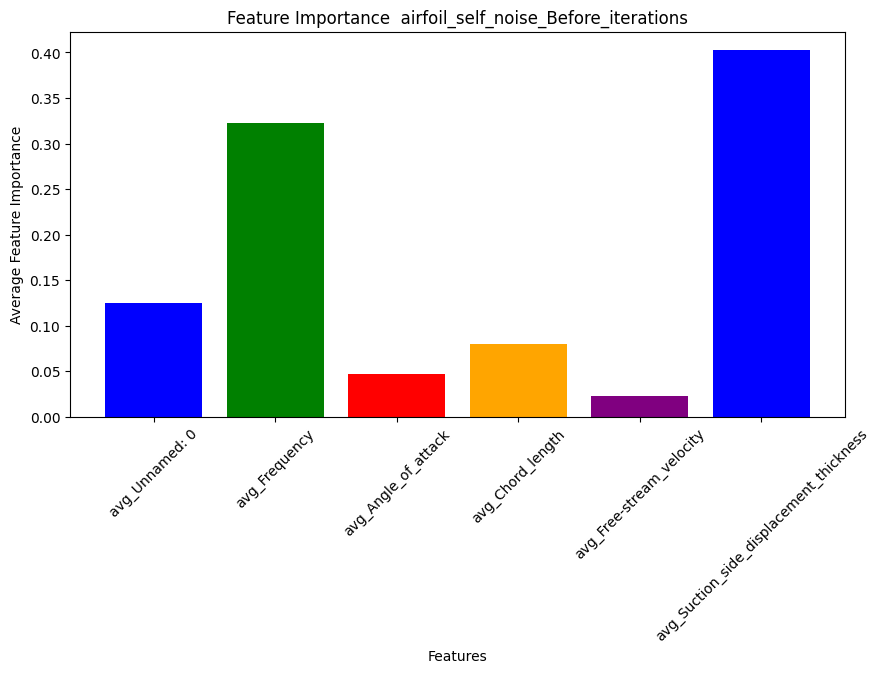

[25.363956938704295, 23.522267696877066, 21.743894336511623, 21.57845538438537, 21.549236949302315]


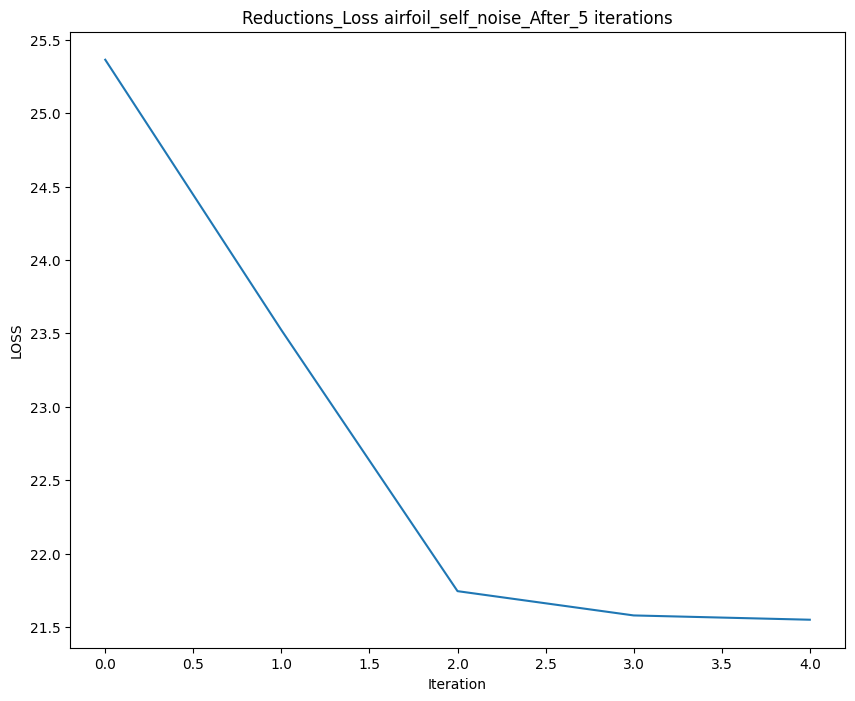

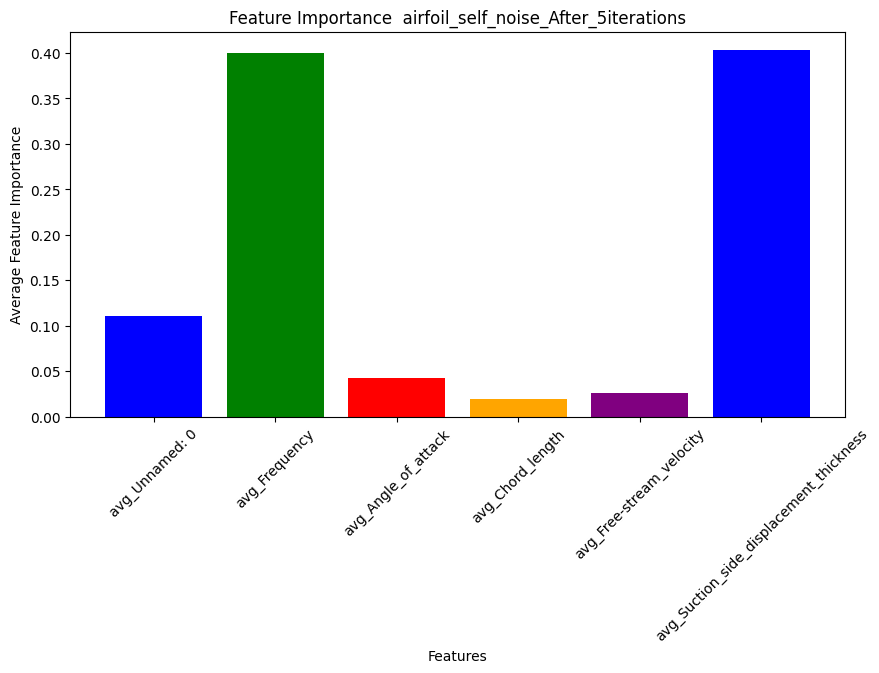

[21.549236949302315, 21.455235053787362, 21.455235053787362, 19.834178872691012, 19.92058285684384, 19.912316488538192, 19.242724338571424, 19.37685232036544, 19.379927863388694, 19.248420562192685]


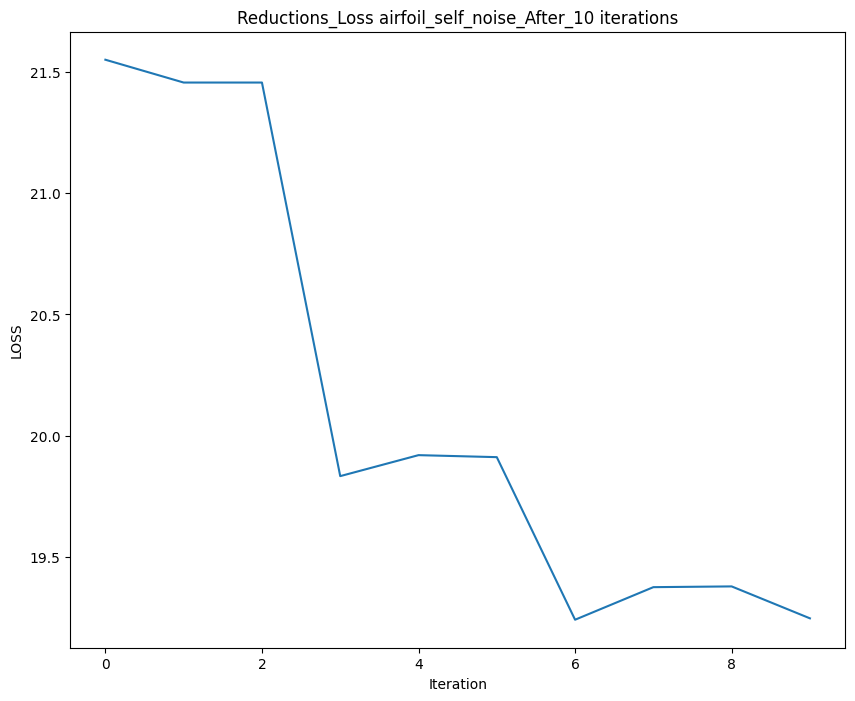

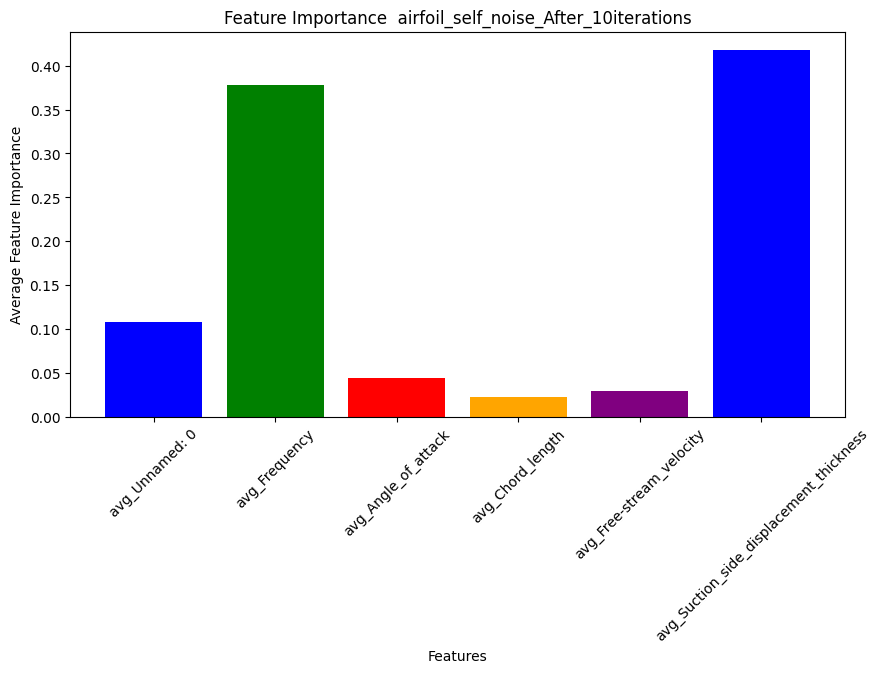

[19.24608483136212, 19.148720820697665, 19.148720820697665, 19.163687147807302, 19.24368140039867, 19.274068255249166, 19.245241275548167, 19.385210299401983, 19.387392271362117, 19.256509413222588, 19.304211742691027, 19.30430311554817, 19.292778690531556, 18.485221795980063, 18.487048934451824, 18.490132526644512, 18.645454983455142, 18.546675765946837, 18.76433552990033, 18.85475328465116]


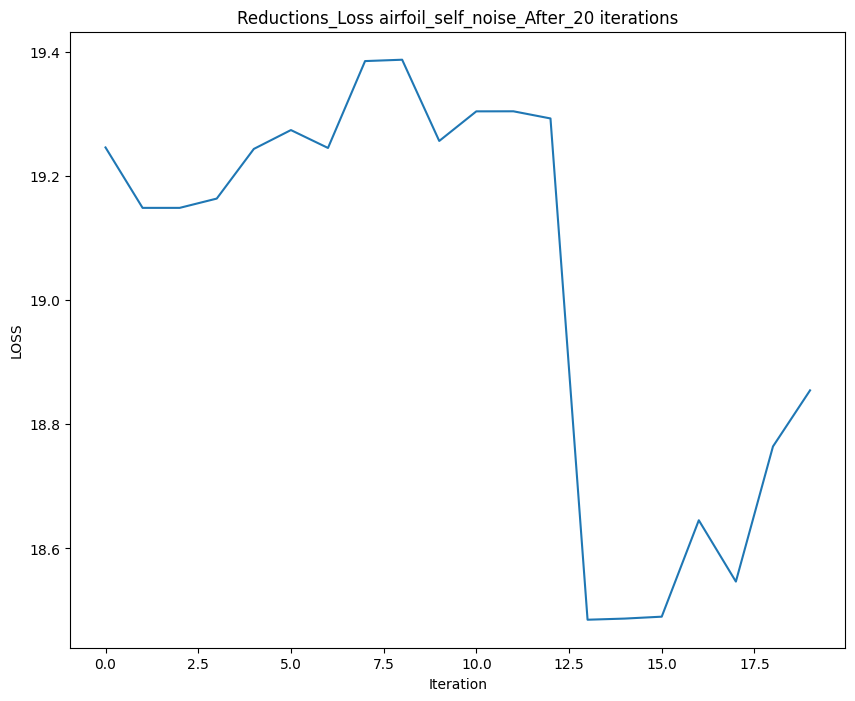

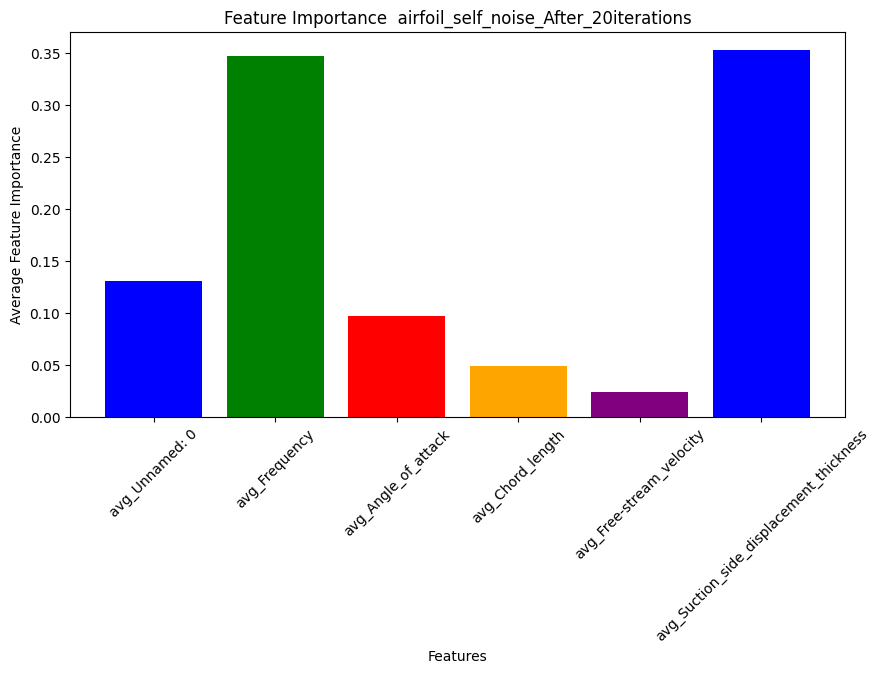

[18.797320697475087, 18.545450271694353, 18.662939385880392, 18.701686251196005, 18.497930252026578, 18.530665431029902, 18.472661790531564, 18.590703263754147, 18.589618743089694, 18.48090715903654, 18.536934884983385, 18.545018956644512, 18.487531948073084, 16.96077350109633, 16.9723130532558, 16.96955600611294, 16.921812841461776, 16.777277547242505, 16.851884715282374, 17.019749011495, 17.117131499003307, 16.891746366611283, 16.594073665481712, 16.69841734255813, 16.24494254252491, 16.334840232657804, 16.30319372681063, 16.428805949468437, 16.409554912491693, 16.6590990410299, 16.981972086345515, 17.377552594850496, 17.768210887275742, 17.53800760372093, 17.313805335083057, 17.375761867475084, 17.489179139036537, 17.585978133122918, 17.880501263488366, 17.89280852774085, 17.87560235415282, 18.09043569279069, 18.09826890411959, 18.024565457940184, 17.62706887039866, 17.425157434252483, 16.983450506112955, 17.099127223787377, 16.922244380299002, 17.088429907707635]


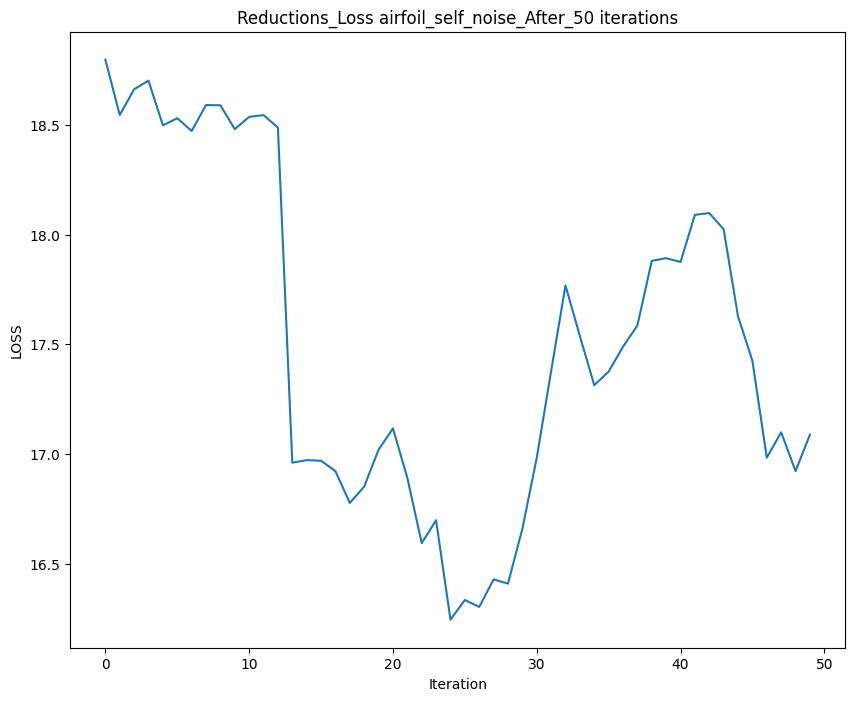

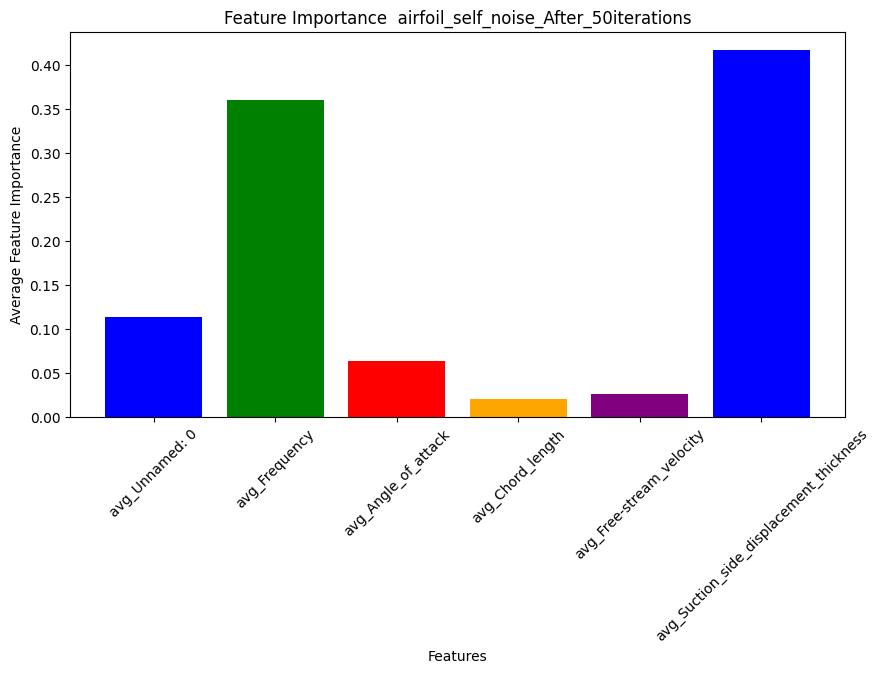

Data Name :B.Housing


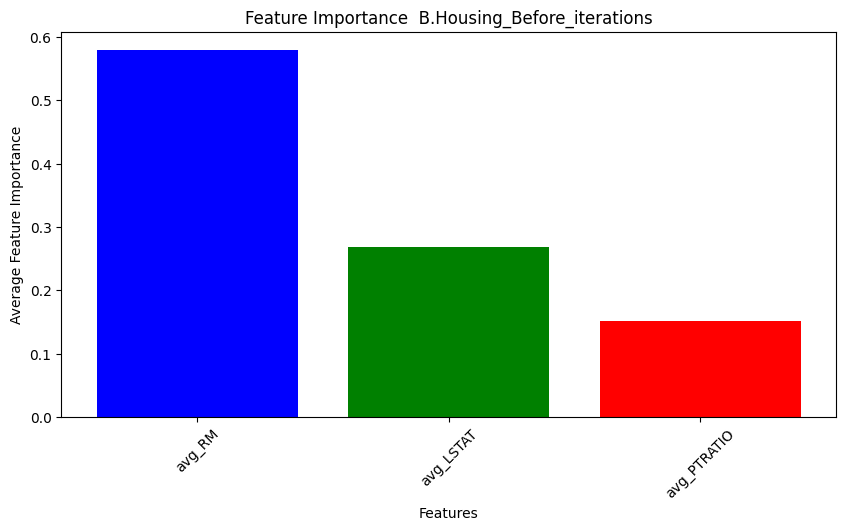

[8092265850.0, 7725784950.0, 7716443400.0, 7505519400.0, 7429885650.0]


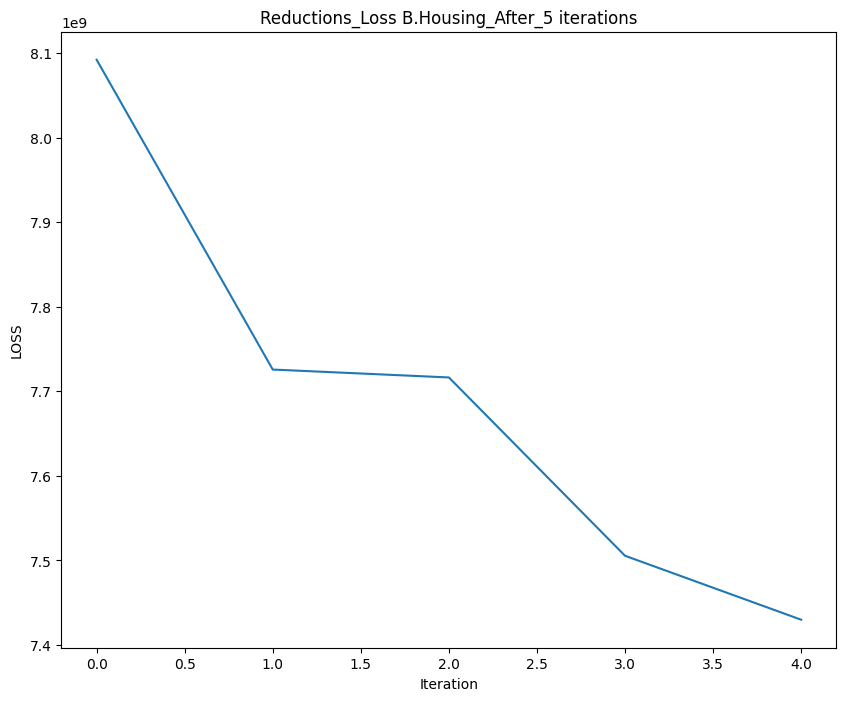

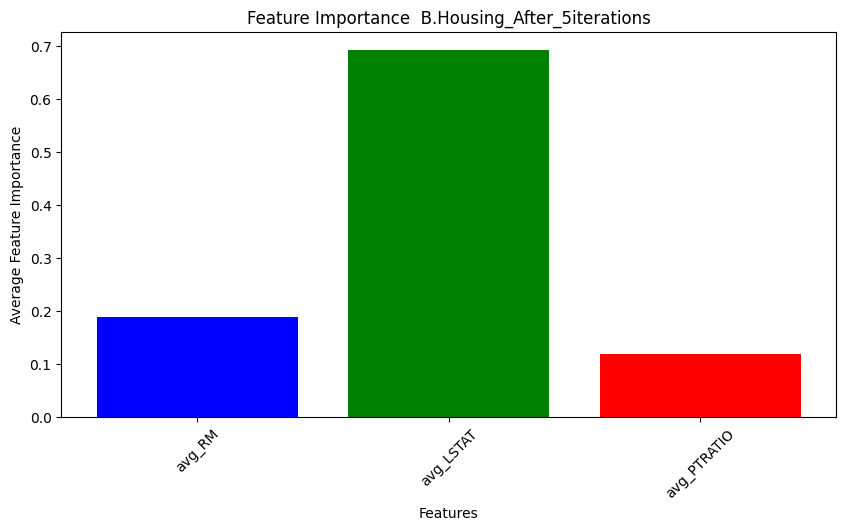

[7376418000.0, 7344225900.0, 7397165250.0, 7400846700.0, 7344225900.0, 7213261050.0, 7180281900.0, 7200034200.0, 7144596450.0, 7135785900.0]


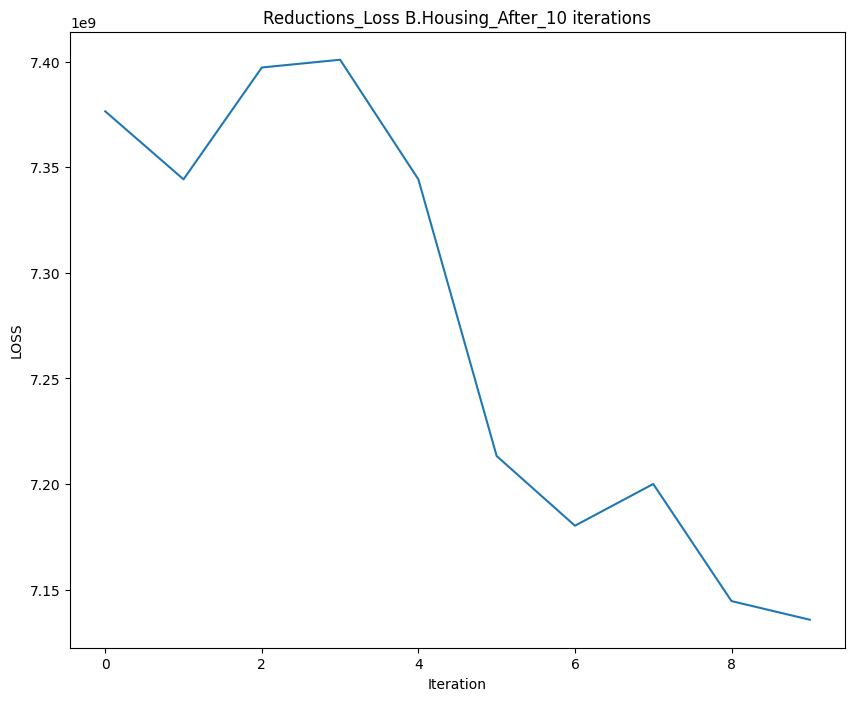

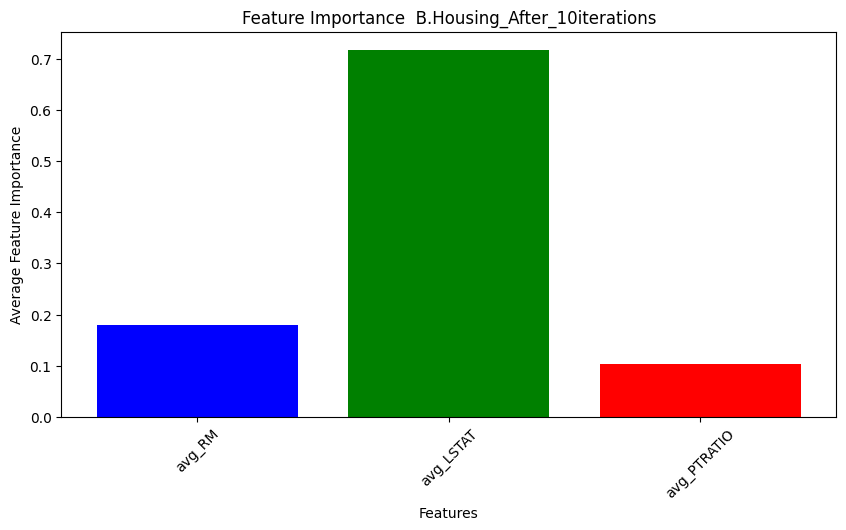

[7143953400.0, 7210922850.0, 7221717000.0, 7223594400.0, 7156498050.0, 7133705100.0, 7116686550.0, 7172565300.0, 7162854300.0, 7162854300.0, 7091274600.0, 7273582200.0, 7249847400.0, 7133808600.0, 7127603550.0, 7109053200.0, 7141937850.0, 7128578700.0, 7128075600.0, 7138120050.0]


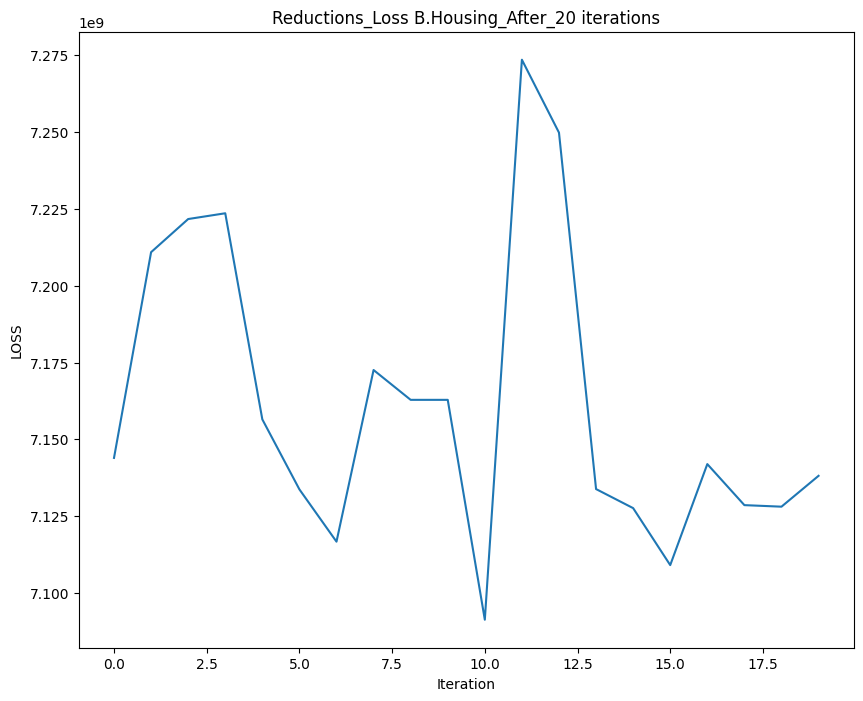

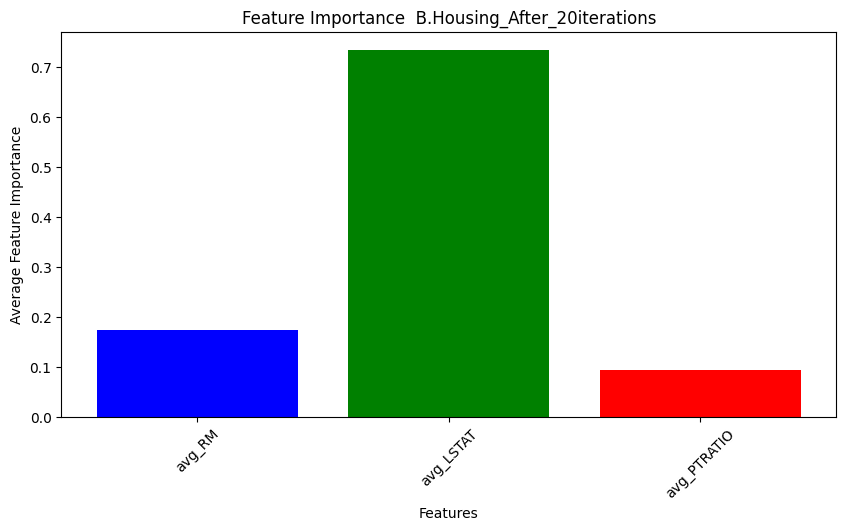

[7133566050.0, 7179516900.0, 7200138150.0, 7204351050.0, 7138674900.0, 7292907000.0, 7651313100.0, 7637807250.0, 7686831150.0, 7828893900.0, 7774342650.0, 7952398650.0, 7973730450.0, 7851902850.0, 7857725400.0, 7837490250.0, 7871203800.0, 7869455550.0, 7868621250.0, 7891448400.0, 7854074100.0, 7513236000.0, 7472064150.0, 7799969700.0, 7852565250.0, 7484353200.0, 7384219650.0, 7648319250.0, 7824000600.0, 7847304300.0, 7888382550.0, 7935416100.0, 7935784650.0, 7951757400.0, 7951681350.0, 7937055000.0, 8010389700.0, 7951112550.0, 7918092450.0, 7968860550.0, 8017210350.0, 7978029750.0, 8139223800.0, 8134696350.0, 8126012700.0, 7886218500.0, 8185305600.0, 8130285900.0, 8096470200.0, 8025966450.0]


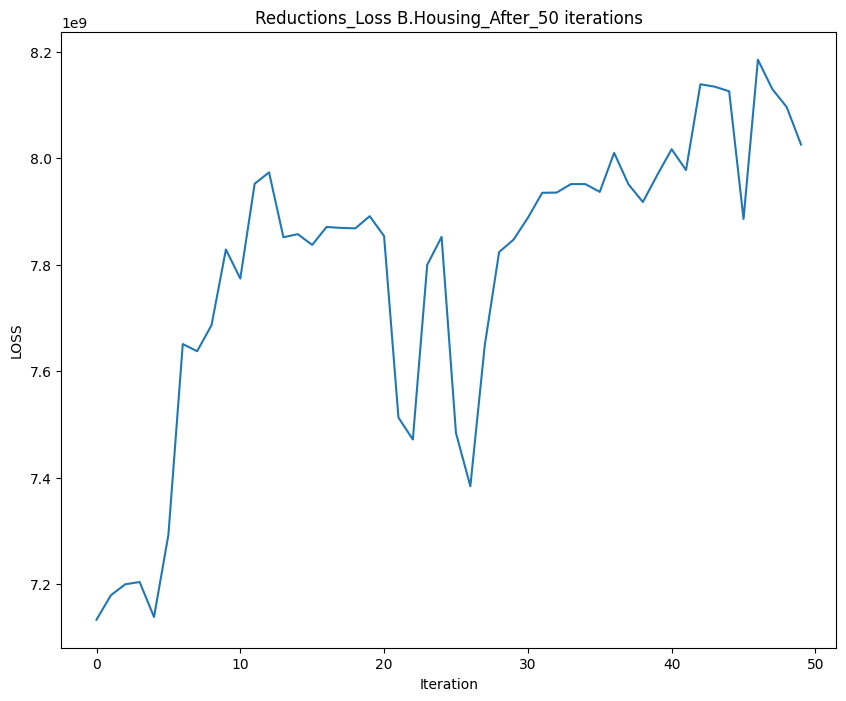

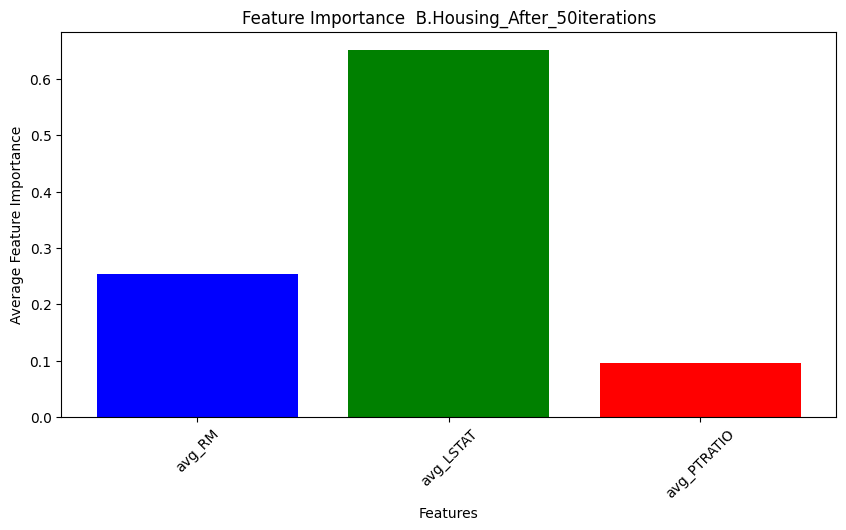

Data Name :Abalone


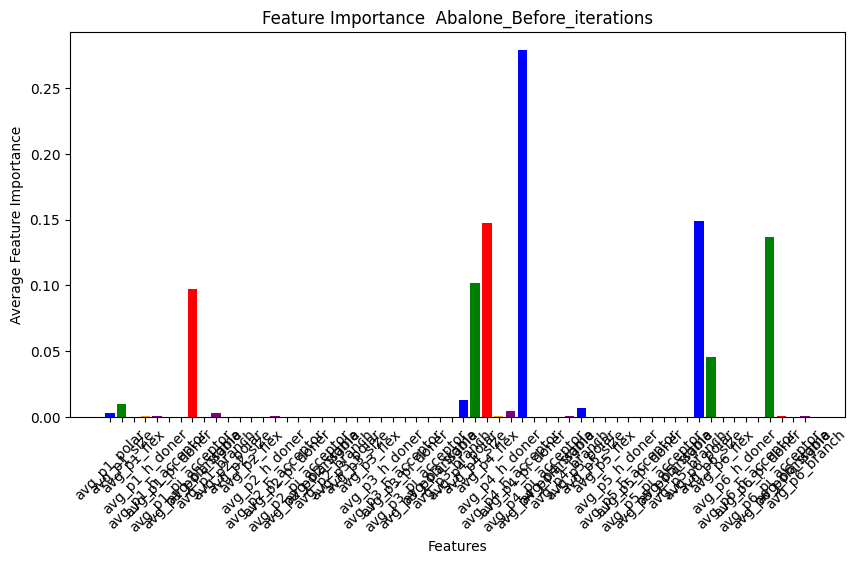

[0.01782845972972974, 0.017698046216216214, 0.018154000810810825, 0.016683733783783794, 0.015904249189189194]


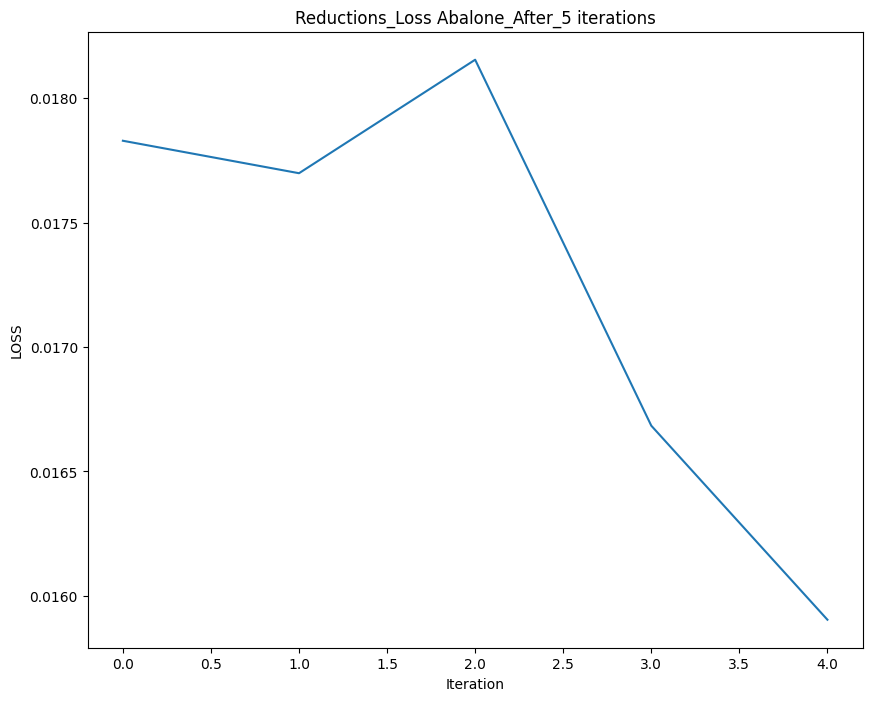

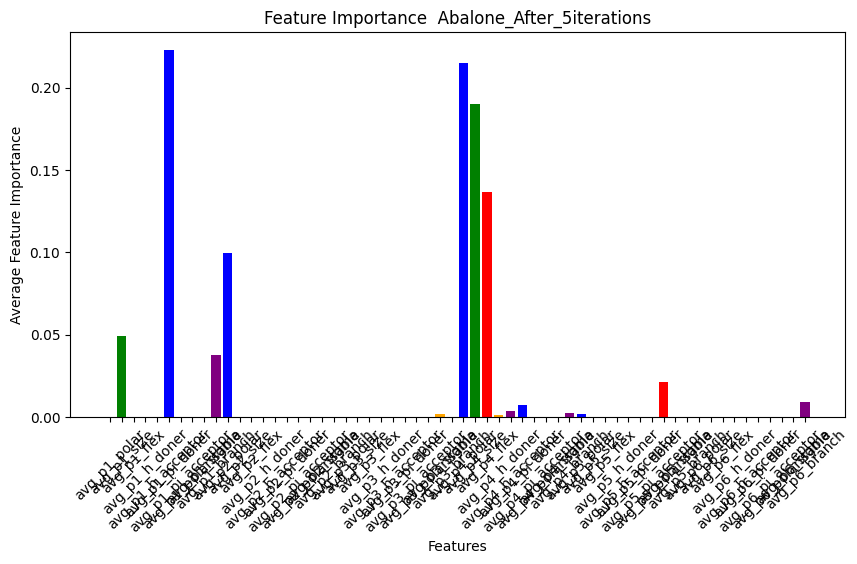

[0.01632399864864865, 0.016175854864864864, 0.016683733783783794, 0.015783820810810822, 0.014889555675675679, 0.01425152162162163, 0.01439436837837838, 0.014700177837837844, 0.01474880540540541, 0.014915616756756761]


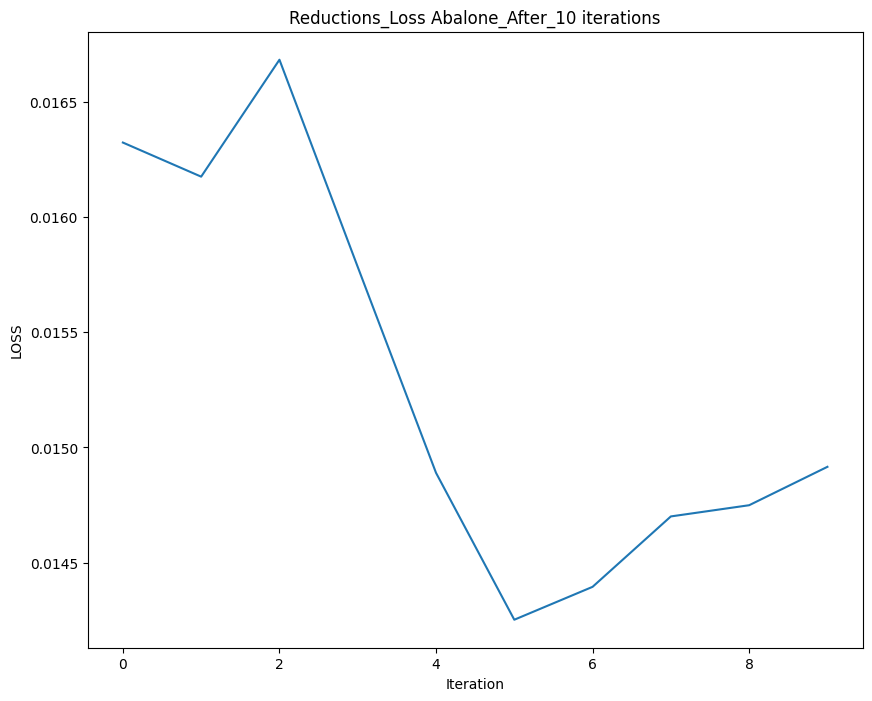

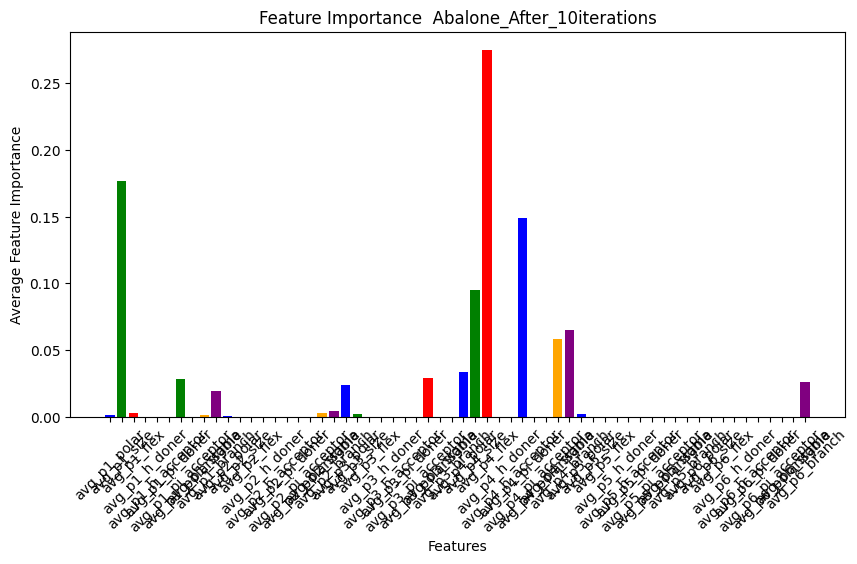

[0.01434878648648649, 0.014788697297297301, 0.0161869645945946, 0.01544784378378379, 0.015350332702702701, 0.016163815675675673, 0.016587556756756765, 0.01617249000000001, 0.01648725263513514, 0.016651551554054057, 0.017279599932432436, 0.017378785608108113, 0.016661022094594597, 0.015422737770270274, 0.015672359391891898, 0.015339689121621626, 0.014538116418918926, 0.014078569121621625, 0.014448972635135133, 0.014963400472972975]


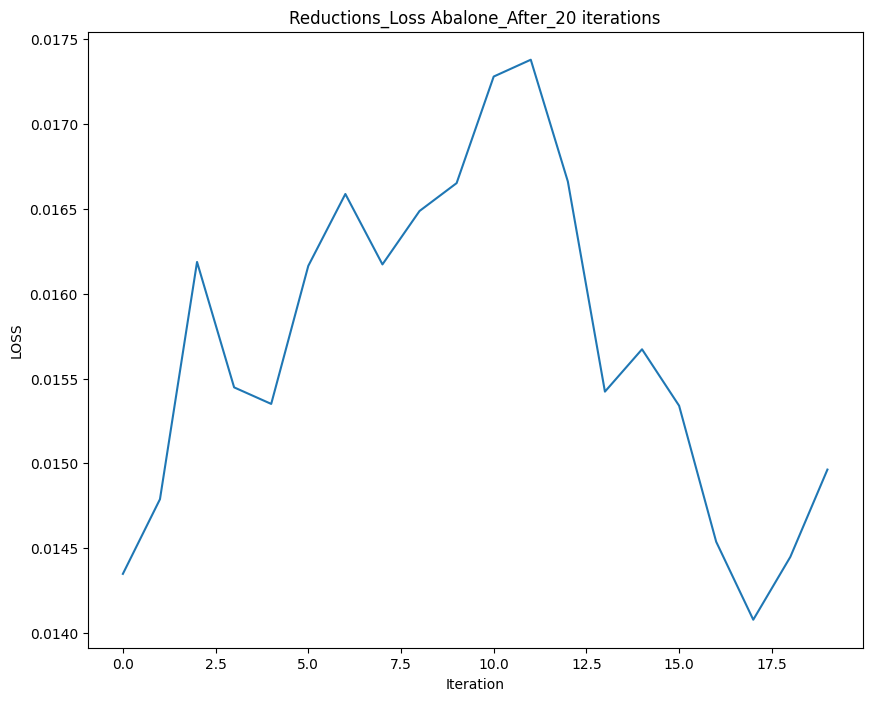

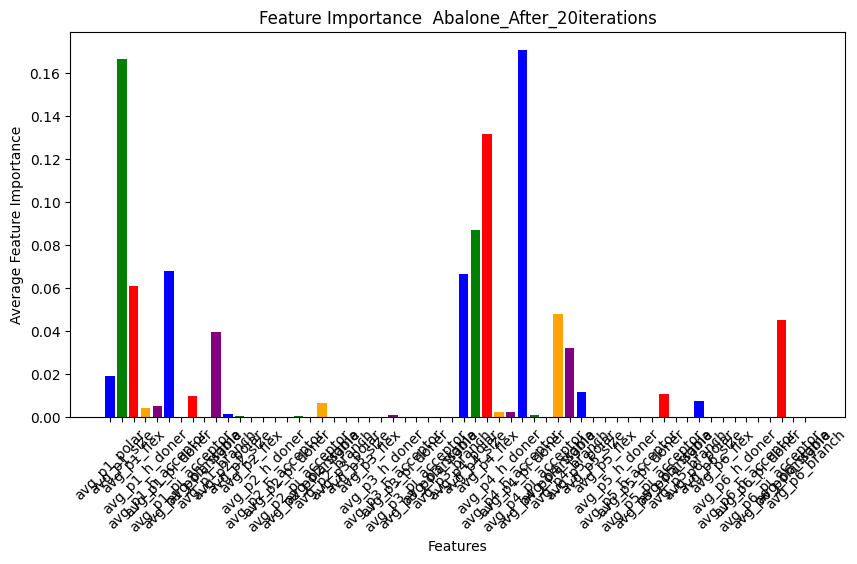

[0.014831971081081084, 0.015376118108108116, 0.01557612452702703, 0.014765621283783786, 0.014812283716216219, 0.015605723716216218, 0.0159173347972973, 0.015601997162162169, 0.015784917770270277, 0.01550054472972973, 0.01507165189189189, 0.01433019506756757, 0.014608541216216214, 0.014477569054054054, 0.014707516351351351, 0.014889028175675674, 0.013836379527027029, 0.015054145202702705, 0.01573021060810811, 0.013992875135135132, 0.013882653783783784, 0.014429897432432438, 0.014776587702702708, 0.016715090878378382, 0.01751051263513514, 0.01764085817567568, 0.016749286486486492, 0.016335282702702705, 0.01665412614864865, 0.017488646283783788, 0.01820286925675676, 0.01799310790540541, 0.018090180337837842, 0.01817247790540541, 0.01868494195945946, 0.018077809797297305, 0.01770727952702703, 0.017704670270270274, 0.015648193513513518, 0.015077160000000004, 0.013520313783783785, 0.012094165000000004, 0.012634272837837841, 0.013738876081081087, 0.013330890945945946, 0.013279088513513514, 0.

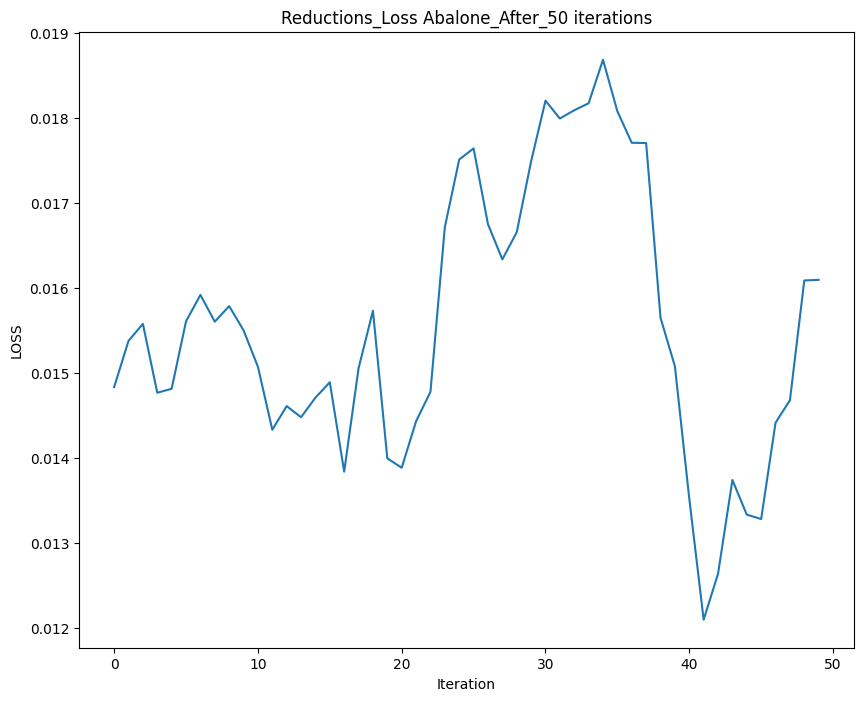

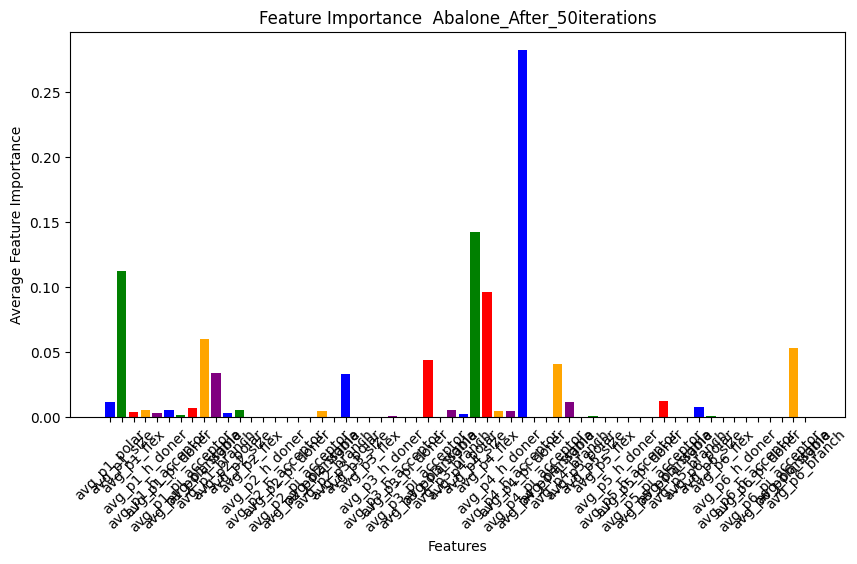

Data Name :bank8FM


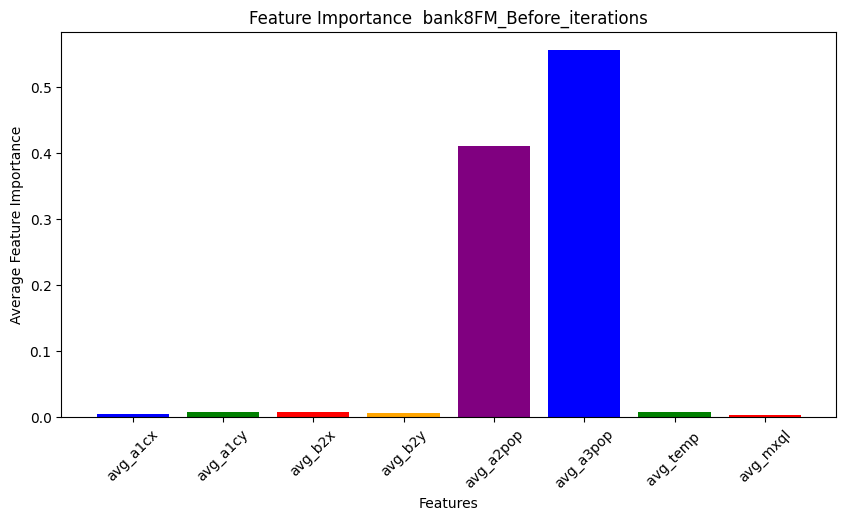

[0.003408112036947467, 0.0034101357566105003, 0.003080126851715389, 0.0027838287660735786, 0.0027094150927613895]


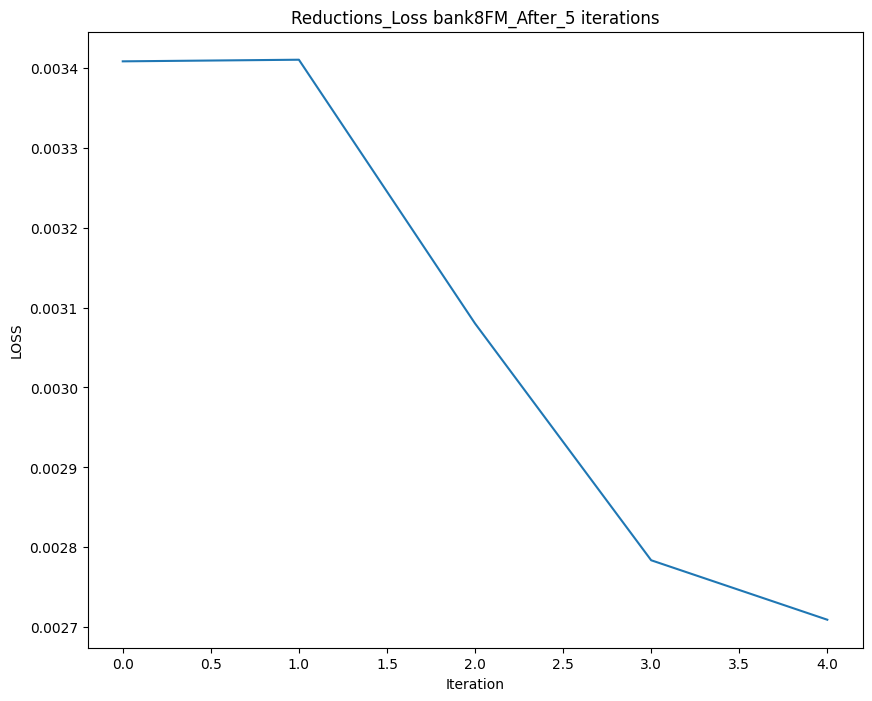

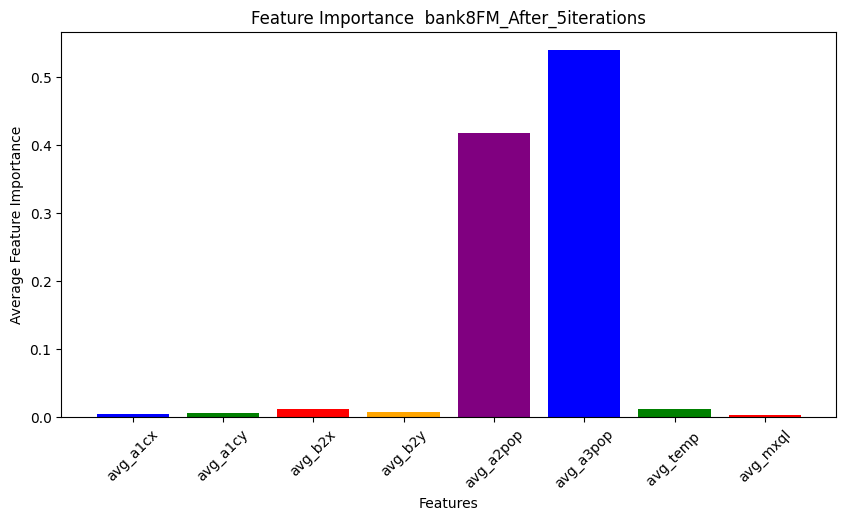

[0.002765666909392867, 0.0027838287660735786, 0.002591442283228633, 0.0024303943484044557, 0.0023772984816140224, 0.002387002972729833, 0.0023923273352725555, 0.002177155511077, 0.0022154835107752887, 0.002188129268902778]


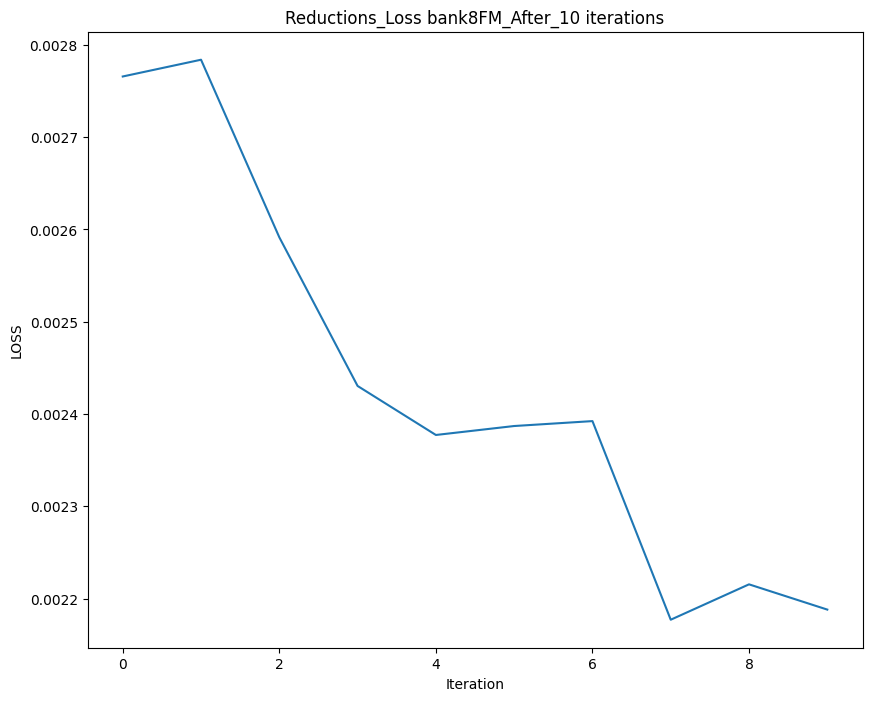

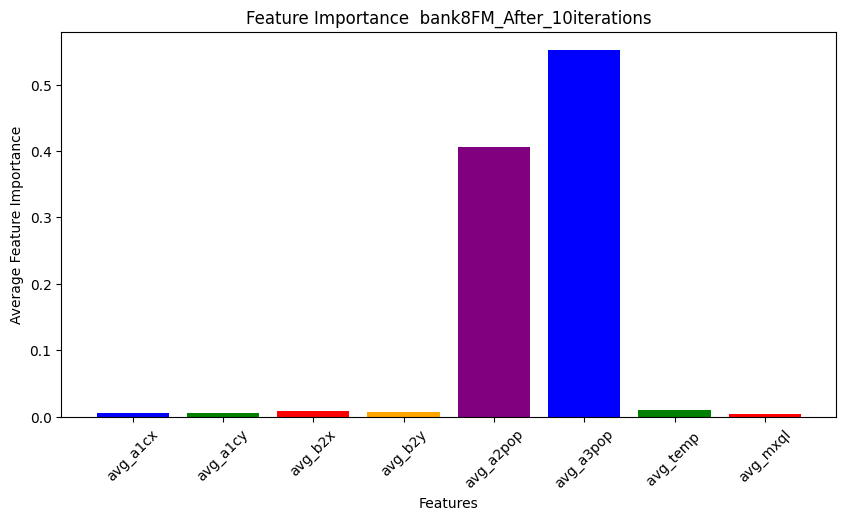

[0.002173023206596689, 0.0020353510949211, 0.0020421099275801666, 0.0020353510949211, 0.0020437917713163334, 0.0020578586118941444, 0.002050108007902167, 0.002067969367715, 0.0019675802895459996, 0.001948792355927122, 0.0019626191949910776, 0.001980364999367544, 0.0019908857101087443, 0.001974613228218045, 0.0019787023165071774, 0.001980843382043311, 0.001991528524934433, 0.001983598188040533, 0.001989191687464233, 0.0019880453617651]


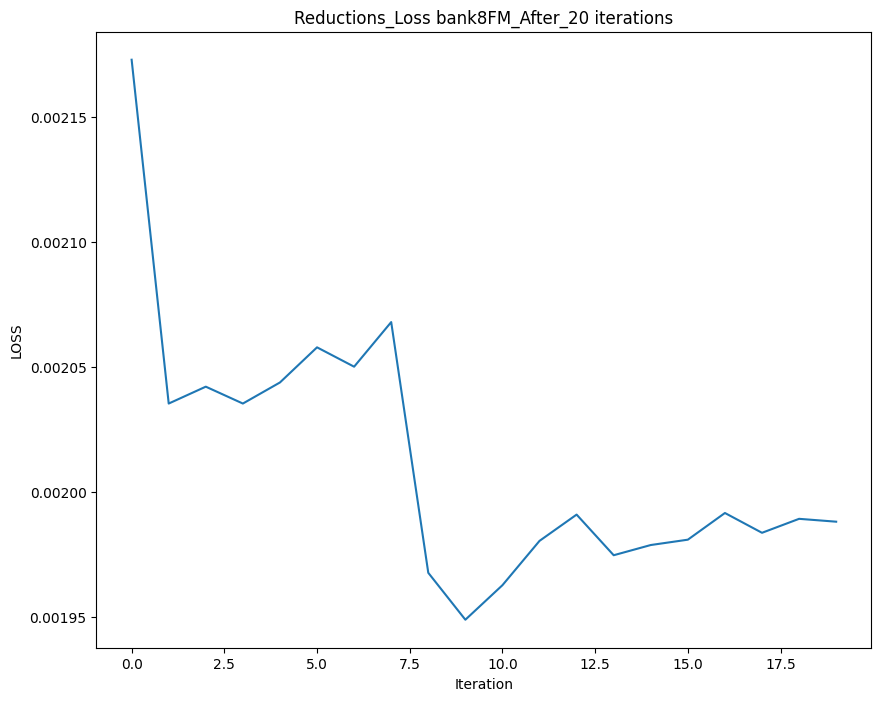

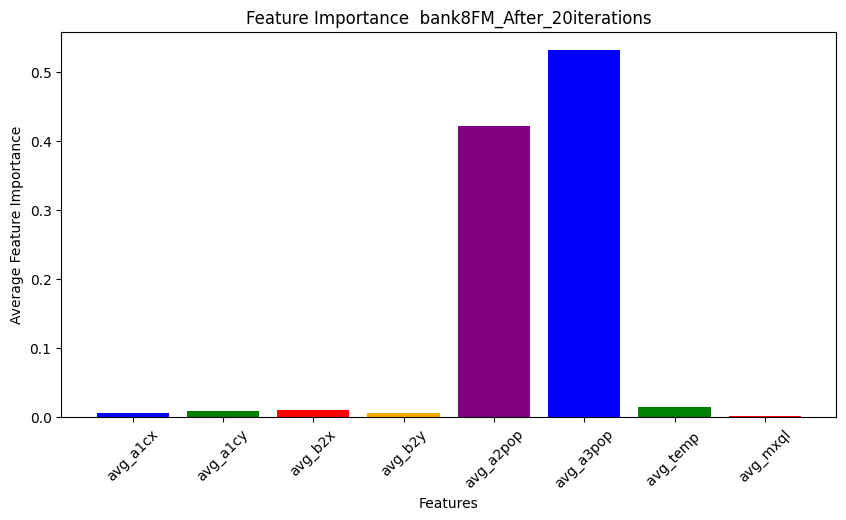

[0.001976215812253611, 0.0019714187520668, 0.001967006229739911, 0.001961878638326278, 0.0019385678654375111, 0.0019235697111447002, 0.0019073941064864889, 0.0019286297114623218, 0.0019451391279213775, 0.0019496793914680886, 0.0019455752521766777, 0.001963091498089978, 0.001972748412638911, 0.0019690282426916223, 0.0019723694135969777, 0.0019746702089095333, 0.001984886528081855, 0.0019775496061777333, 0.001982681464707833, 0.001972432384849133, 0.0019635909466149556, 0.001978261332086589, 0.001968050757533589, 0.0019773886169308667, 0.0019071499966622667, 0.0018807739937479779, 0.0018938430453686002, 0.001893204420591745, 0.0018891975519751444, 0.0018745757530824556, 0.0018665884148297224, 0.0018598197721381446, 0.0018580723844933444, 0.0018528183754655775, 0.001852687017550411, 0.0018588280063265448, 0.0018649894581560448, 0.0018319934718990893, 0.0017985633907816447, 0.0018032717330725668, 0.001809745627807289, 0.0018061661304568223, 0.0018210818312368777, 0.0018507134004812447, 0.0

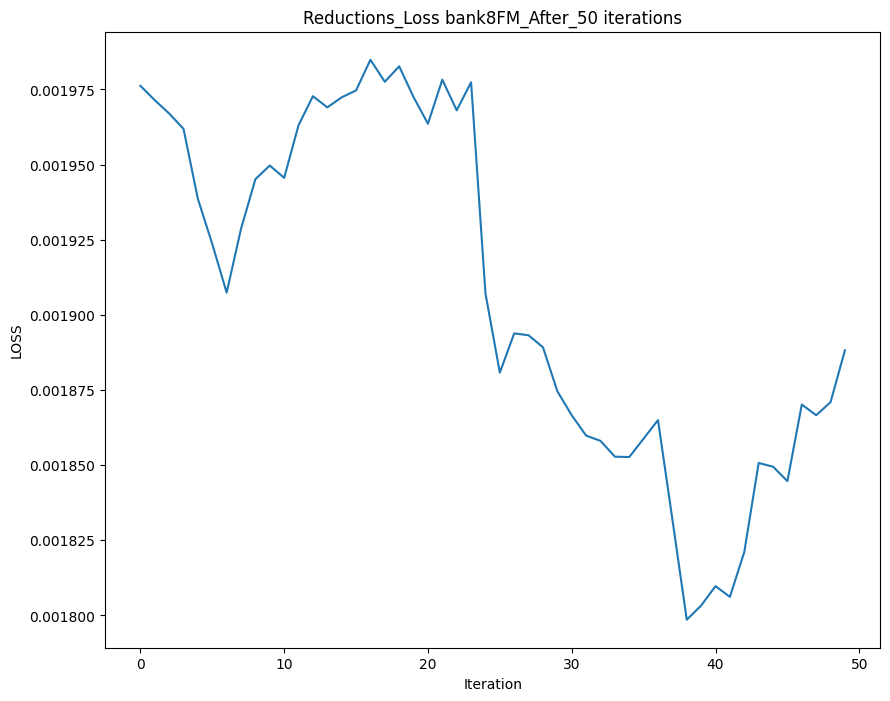

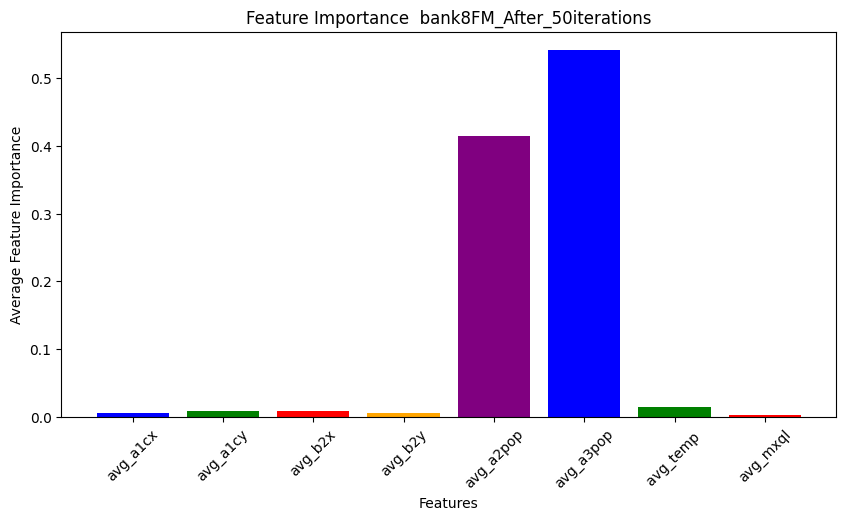

Data Name :cart_delve


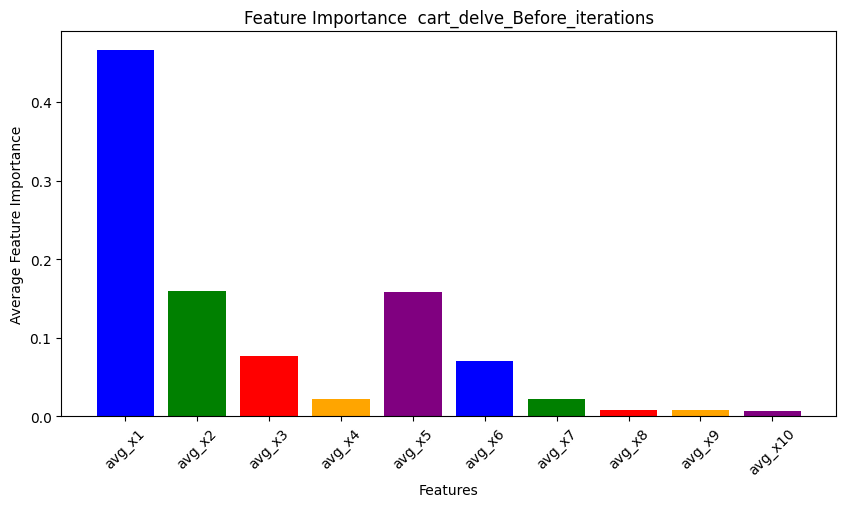

[1.907022789738658, 1.7731175779631452, 1.6619769675845644, 1.5600653834046128, 1.5613603654422252]


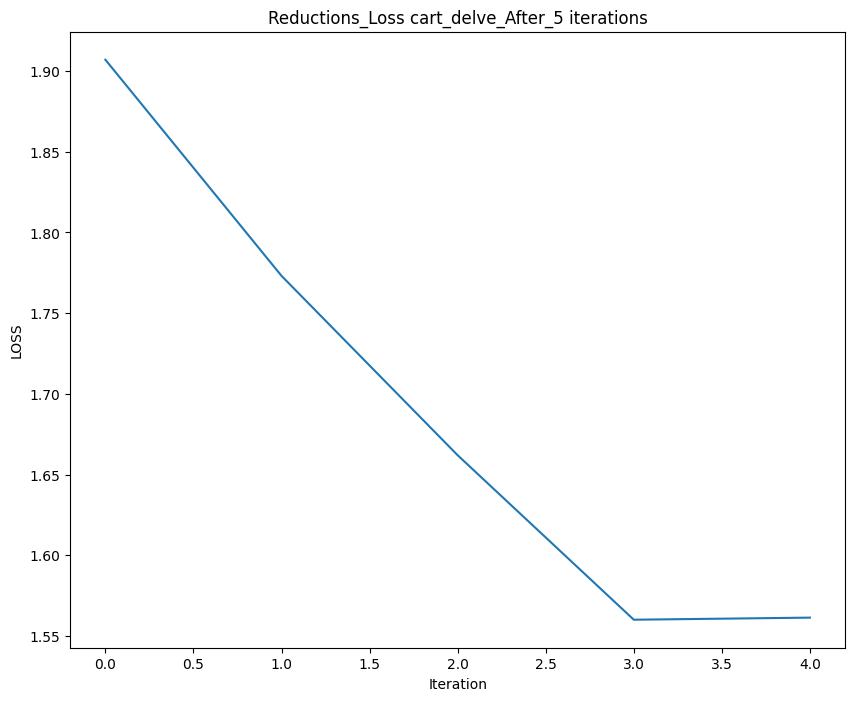

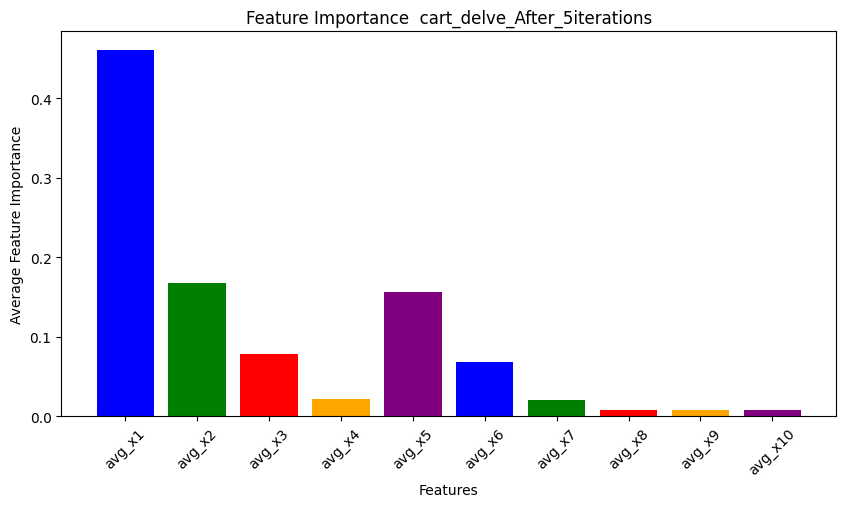

[1.5615848779407526, 1.56294854652186, 1.5615848779407526, 1.5603112513328325, 1.5615848779407526, 1.5632502822940157, 1.562471743534956, 1.4782496346504843, 1.476449743773329, 1.4765377051947952]


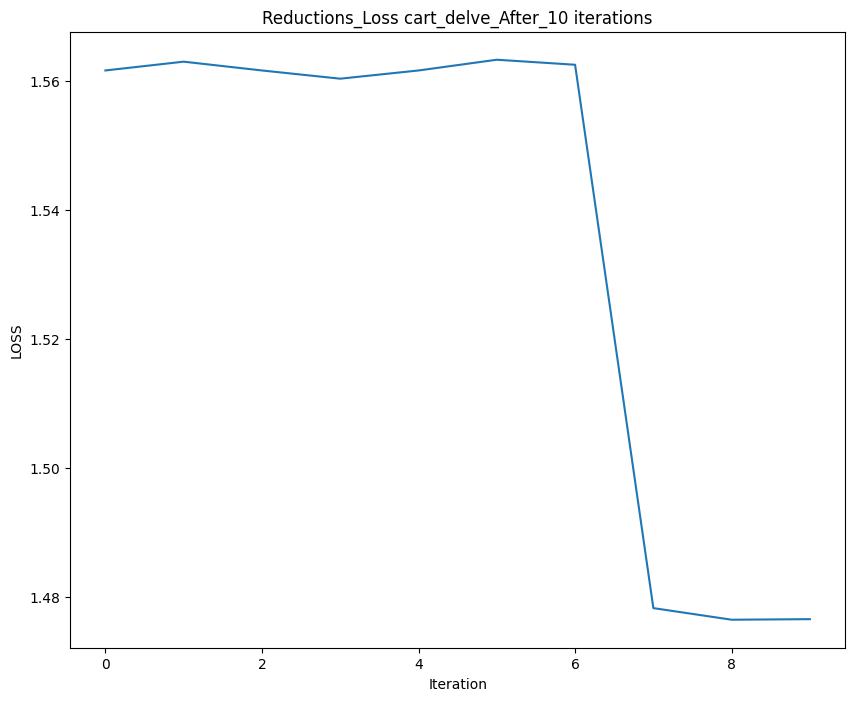

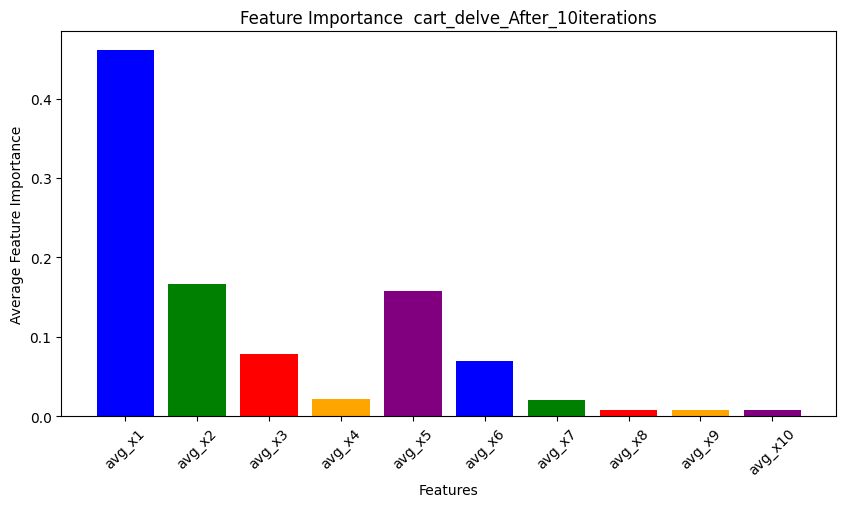

[1.4776547405266192, 1.477320705091909, 1.4761743025207237, 1.4766658793018017, 1.4777906201887032, 1.4792616406594643, 1.4782496346504843, 1.4782496346504843, 1.476449743773329, 1.4765377051947952, 1.47497825937981, 1.4748968952703654, 1.4759635012802623, 1.4769860475010115, 1.475879042779773, 1.4130081635464602, 1.4123429283606632, 1.4116557911435672, 1.4139101736314428, 1.3656302853937157]


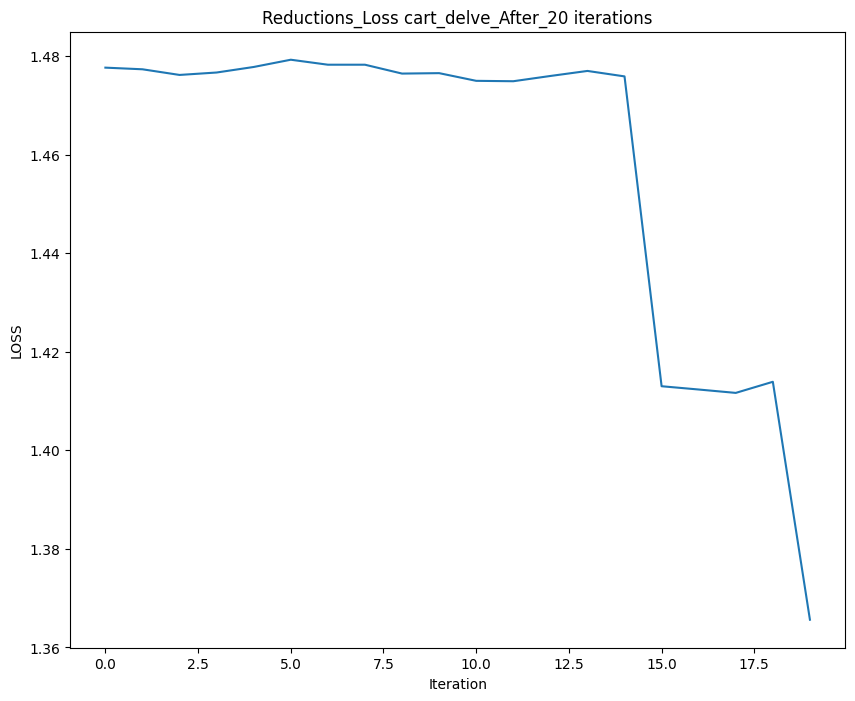

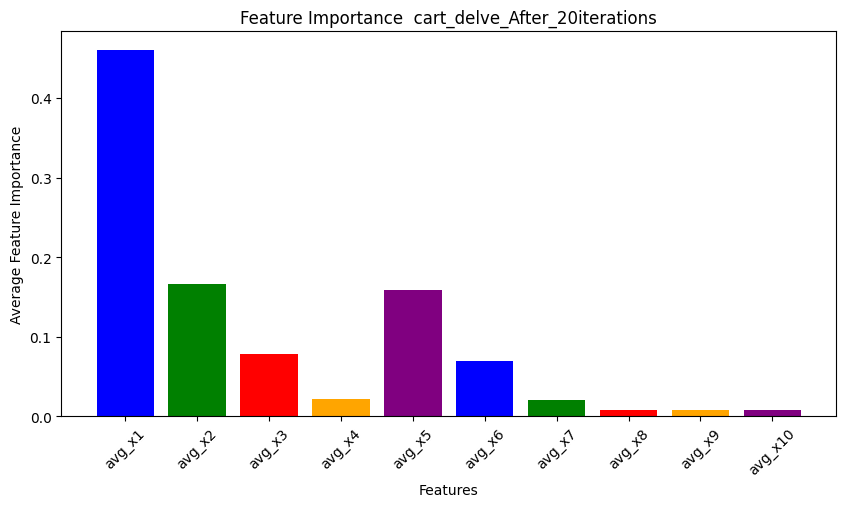

[1.3667162666812633, 1.3669368040745842, 1.3666689942590158, 1.3658623070311111, 1.366742098752024, 1.367198373139796, 1.3656725369034448, 1.3672368707240277, 1.3677215954358966, 1.3685618242827842, 1.367281706655593, 1.3674170658092342, 1.369013198215937, 1.369560972707966, 1.3678068263503387, 1.367289619572981, 1.3650203877261984, 1.3642199144524856, 1.3625455700234643, 1.3272674545215464, 1.3285311075977337, 1.328719515523797, 1.3290064210708827, 1.315561574427199, 1.3154854045992372, 1.3158446556344203, 1.317885603338211, 1.3186283525901832, 1.3185465957978932, 1.3178736068060097, 1.3172667525236013, 1.3179154165037479, 1.316791903131991, 1.3168740225393945, 1.3172400113501488, 1.317177872471449, 1.3181506418288855, 1.316807519073267, 1.3156159431590808, 1.3165840524967596, 1.3154972142296104, 1.3157104141140061, 1.3165885382971962, 1.3166941775677732, 1.3147790821221679, 1.3158988589736444, 1.3142479664655788, 1.315091644641116, 1.3150941628619983, 1.3144999506192432]


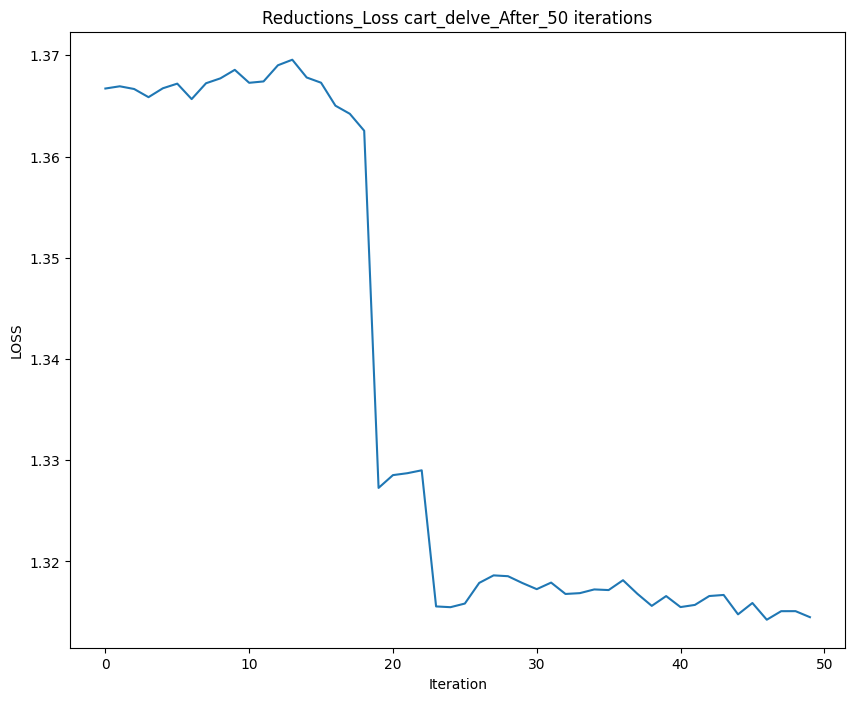

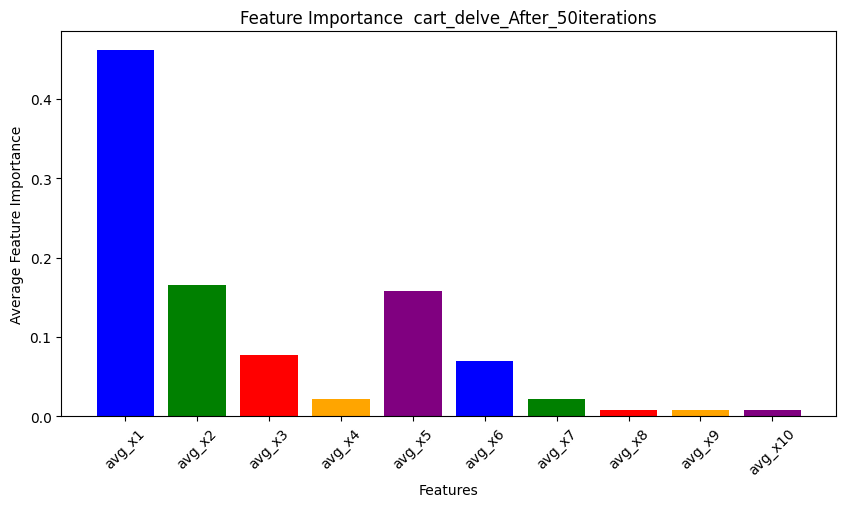

Data Name :fried_delve


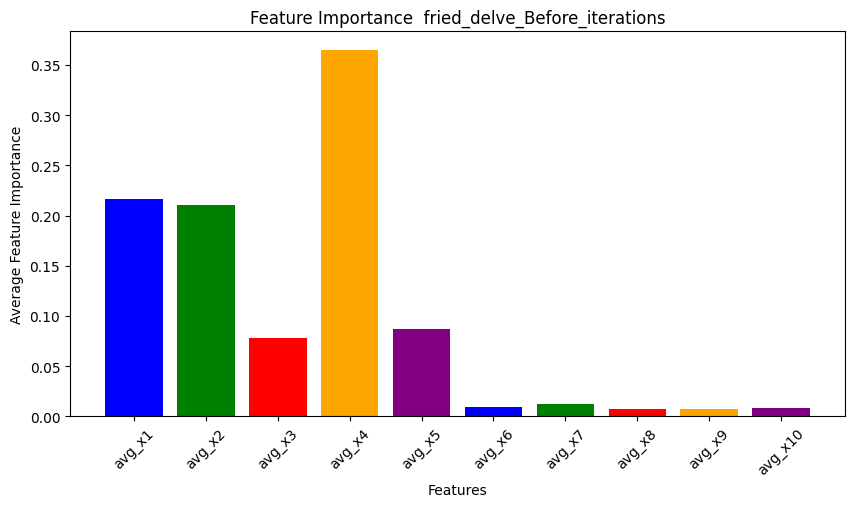

[5.521879349640667, 4.965163192038263, 4.960924710591121, 4.4218658716261965, 3.997457816432426]


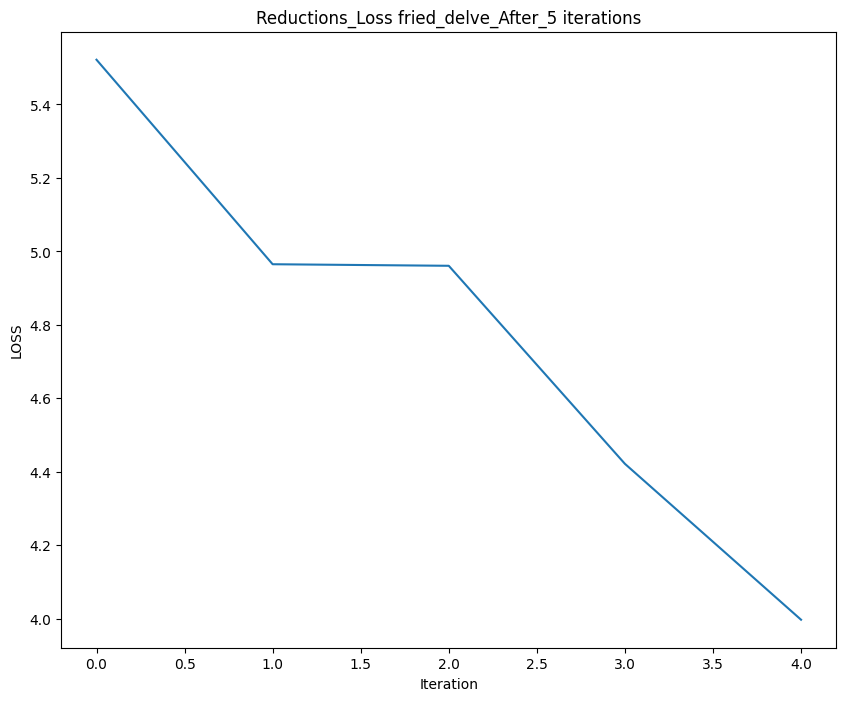

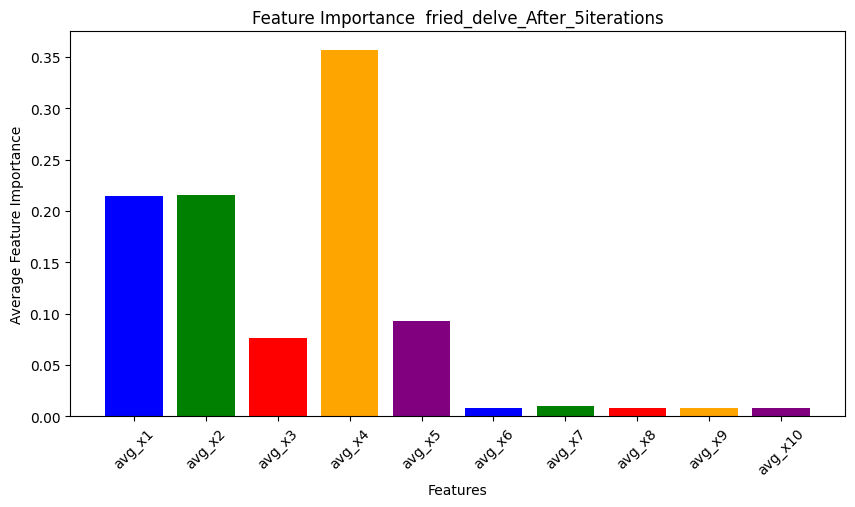

[3.6337284405163106, 3.3207733633002205, 3.114194679426048, 2.9449063442396377, 2.9443255615759143, 2.9426761279139075, 2.941694526085357, 2.947437186611479, 2.9442528945069903, 2.9481871137748343]


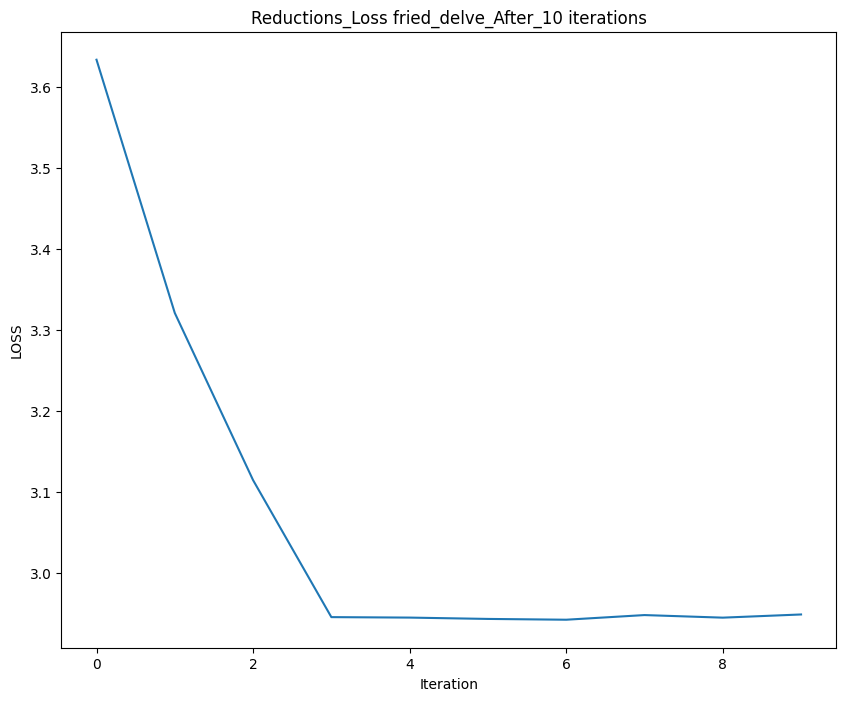

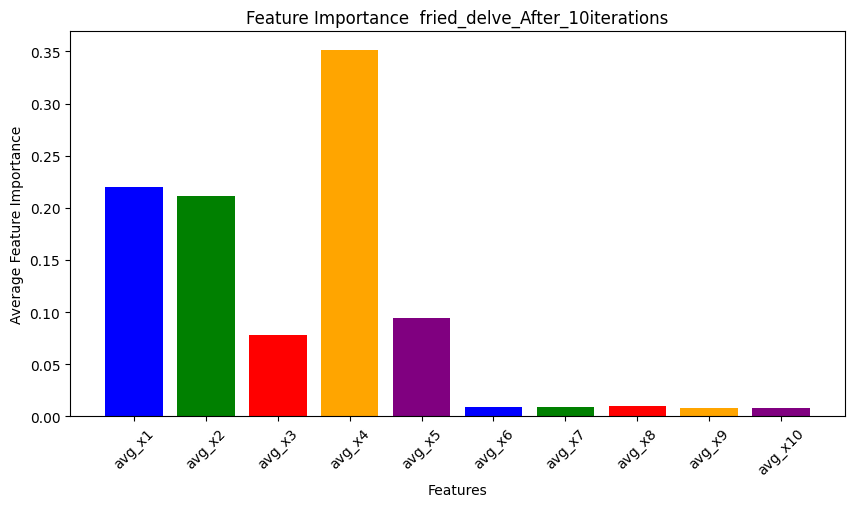

[2.946020777825607, 2.9421859809075297, 2.9421859809075297, 2.94932290566961, 2.9562870610375276, 2.9524714262435614, 2.9519669588410595, 2.944726629935001, 2.9401581248773607, 2.9431190726833454, 2.93656633843635, 2.933816267186657, 2.930047944874908, 2.930459958937944, 2.9361751110620555, 2.942747498847192, 2.945076121492519, 2.9481030747522685, 2.9439303415329903, 2.9462240126367423]


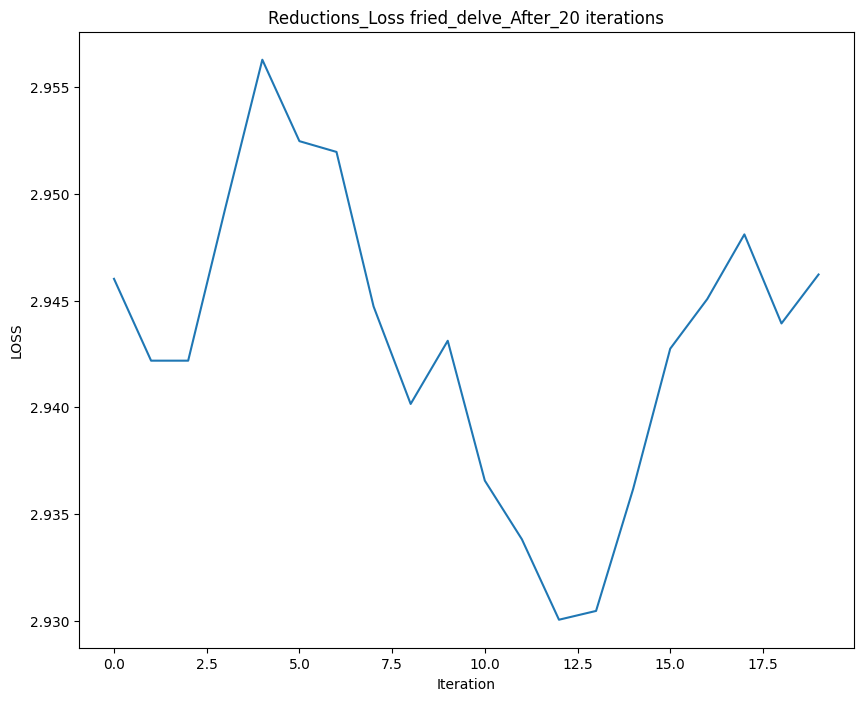

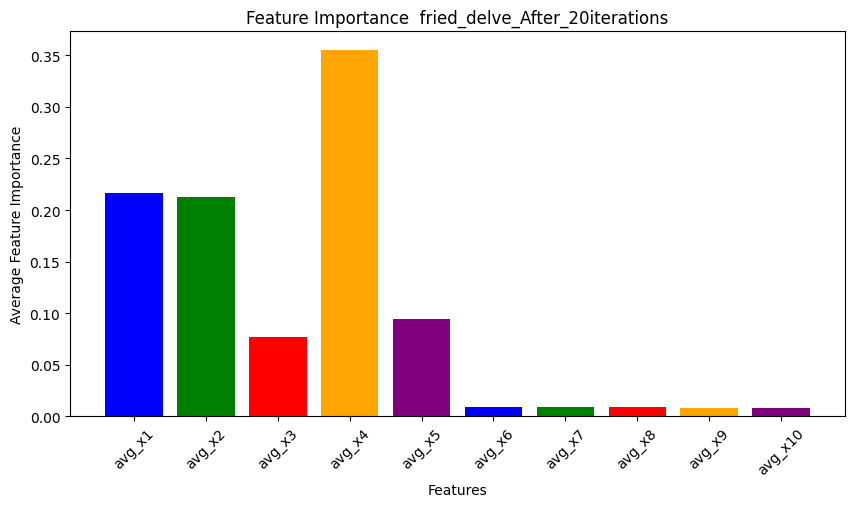

[2.9479375141071866, 2.9546141362276184, 2.9546141362276184, 2.9607826966188378, 2.9660946119610005, 2.964230772174393, 2.961390260359333, 2.95647182275325, 2.9529713377446654, 2.9560619384277653, 2.949877274570763, 2.9440037394468974, 2.941621882317881, 2.9465670065477068, 2.9572280522823156, 2.9568186369720384, 2.956750351492519, 2.959380157332597, 2.9533118296995338, 2.9556065166286483, 2.9545645854280105, 2.9615453412312975, 2.9603865354770664, 2.9462785914778027, 2.939886977852588, 2.948350462868531, 2.867549803509934, 2.858335063855776, 2.858003850929605, 2.8607685768175126, 2.8609963123657103, 2.8594804143389747, 2.859480086368653, 2.85919733705666, 2.860542718798136, 2.8631573427299486, 2.8608188414998774, 2.853144323945303, 2.861168450488104, 2.866214948043905, 2.8545657630917343, 2.864906193707383, 2.863539664283787, 2.8666396750331127, 2.858008329854059, 2.850702687236939, 2.8586269739882266, 2.862307337734854, 2.8654430756033844, 2.8737118858952657]


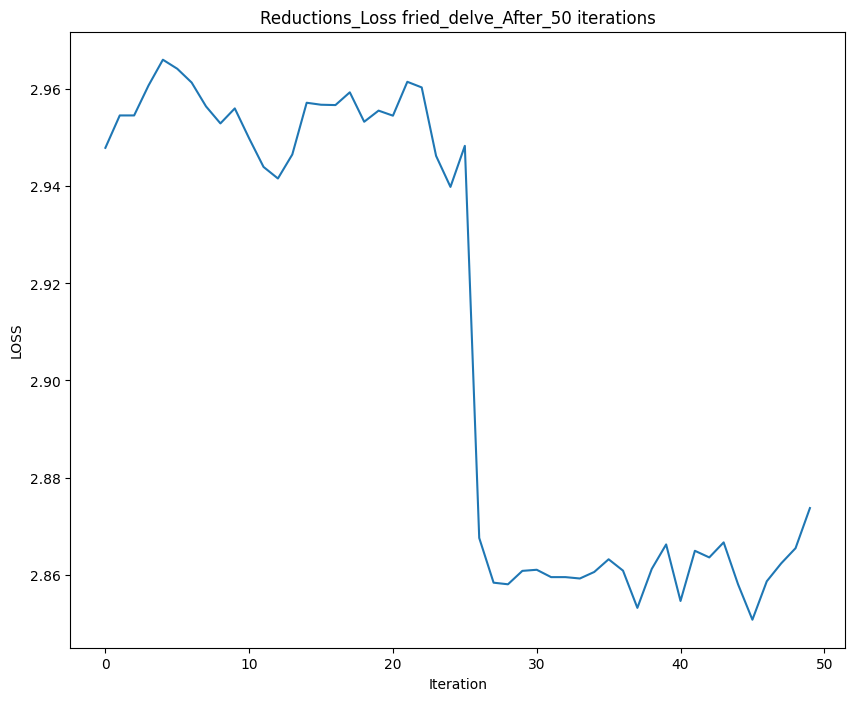

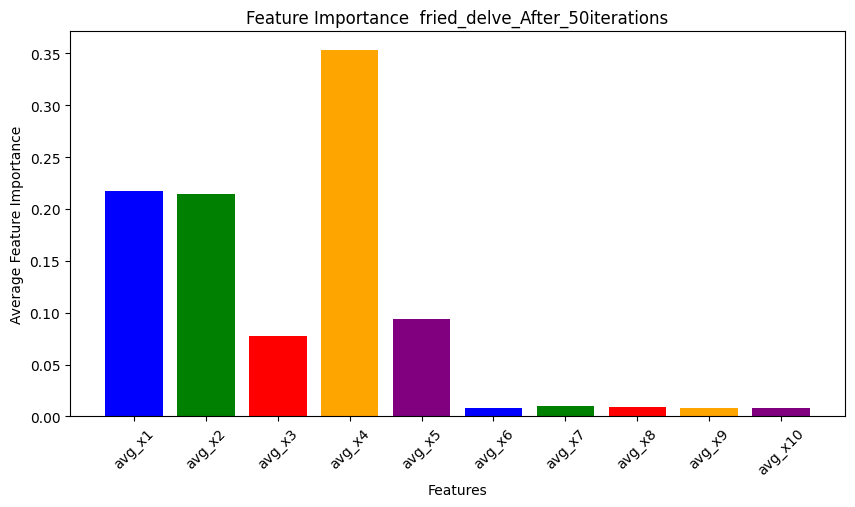

Data Name :Pole Telecom


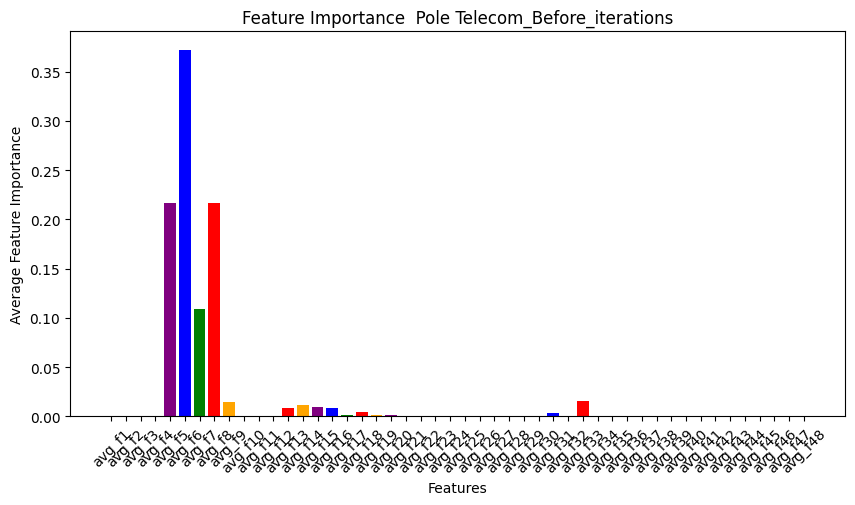

[275.045, 275.045, 275.045, 275.045, 275.045]


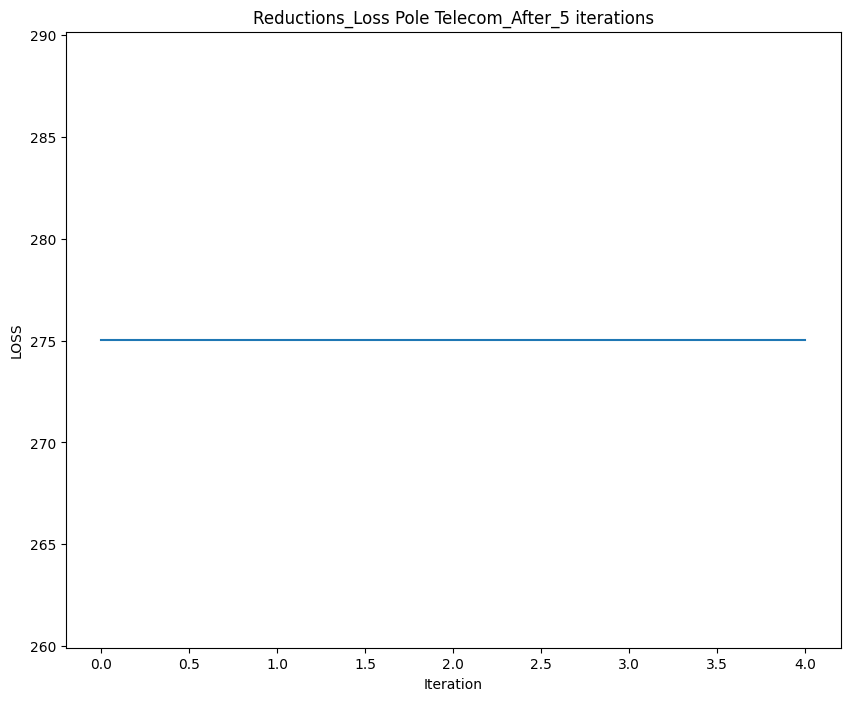

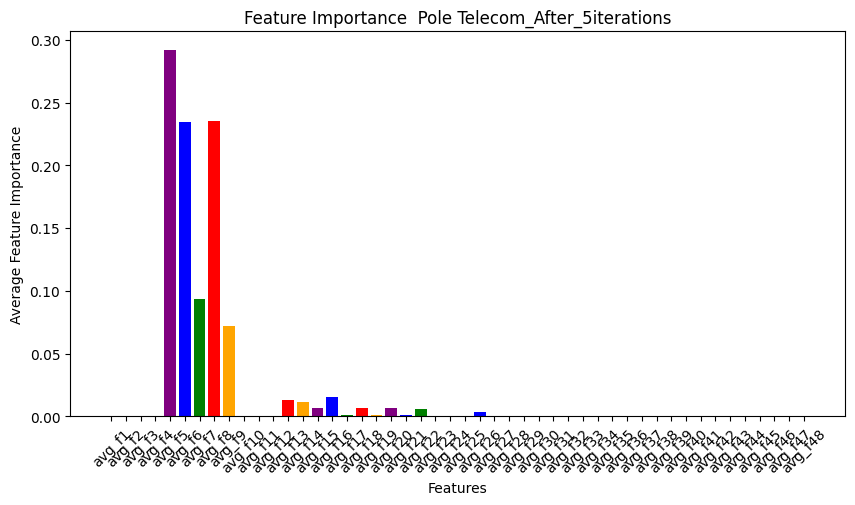

[275.045, 275.045, 275.045, 275.045, 275.045, 275.534, 275.045, 251.025, 233.186, 210.066]


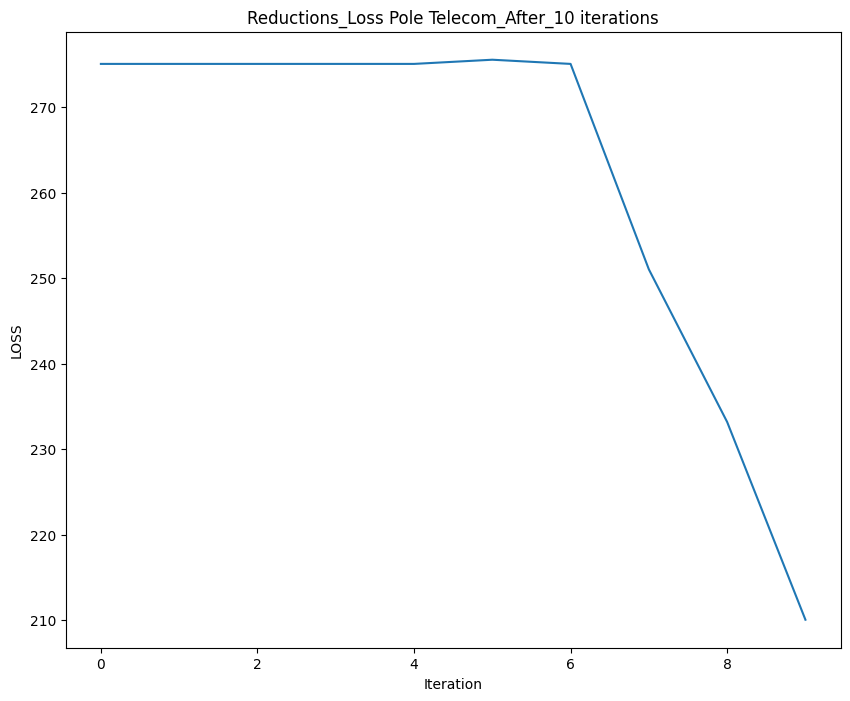

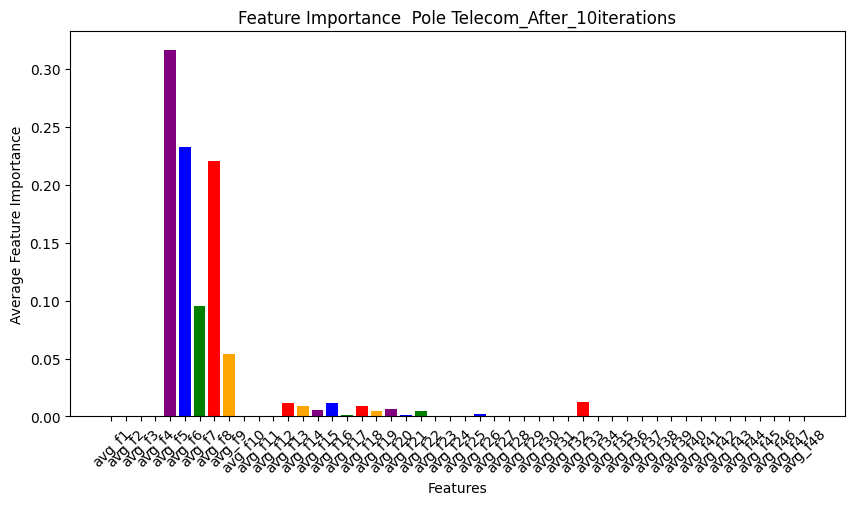

[210.066, 210.066, 210.066, 210.066, 210.066, 210.679, 210.066, 210.066, 210.066, 198.887, 198.491, 182.25, 181.89, 182.699, 182.699, 182.699, 182.699, 183.175, 183.175, 183.175]


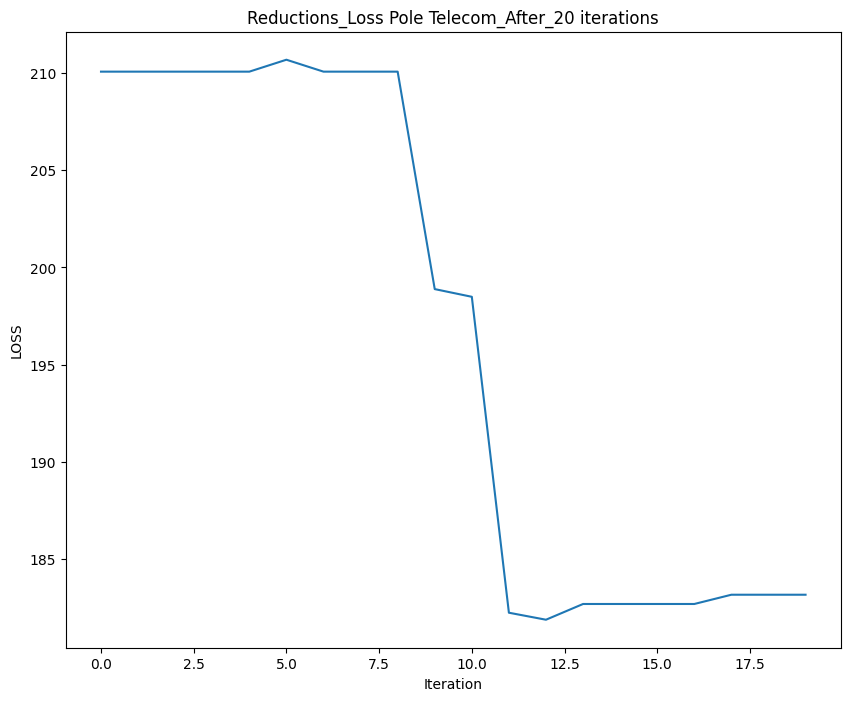

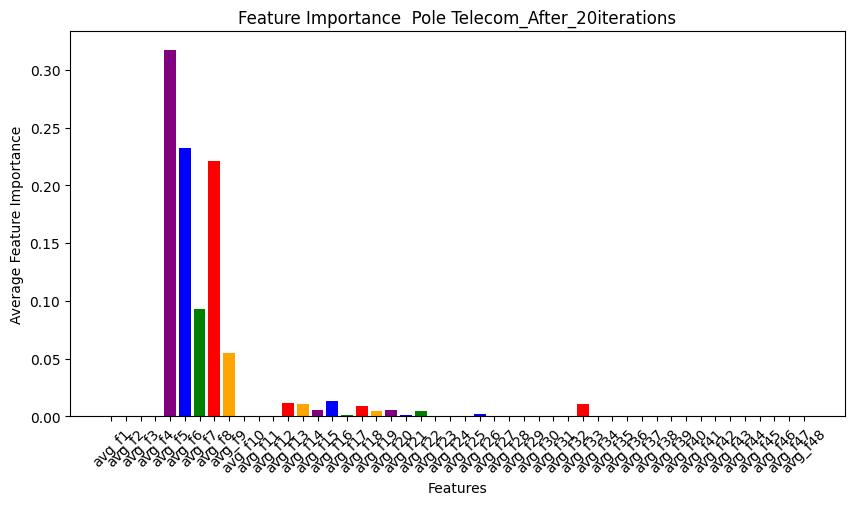

[183.175, 183.175, 183.175, 183.175, 183.175, 184.352, 184.352, 182.906, 182.838, 181.995, 182.486, 182.733, 182.335, 183.182, 183.182, 183.182, 183.182, 183.678, 183.678, 183.678, 183.678, 183.678, 183.678, 183.678, 183.678, 184.857, 184.476, 183.225, 183.225, 184.616, 184.616, 184.58, 184.689, 165.839, 165.875, 165.875, 165.875, 164.595, 164.595, 164.595, 164.315, 160.256, 160.256, 160.256, 160.256, 160.256, 160.256, 160.256, 160.256, 160.256]


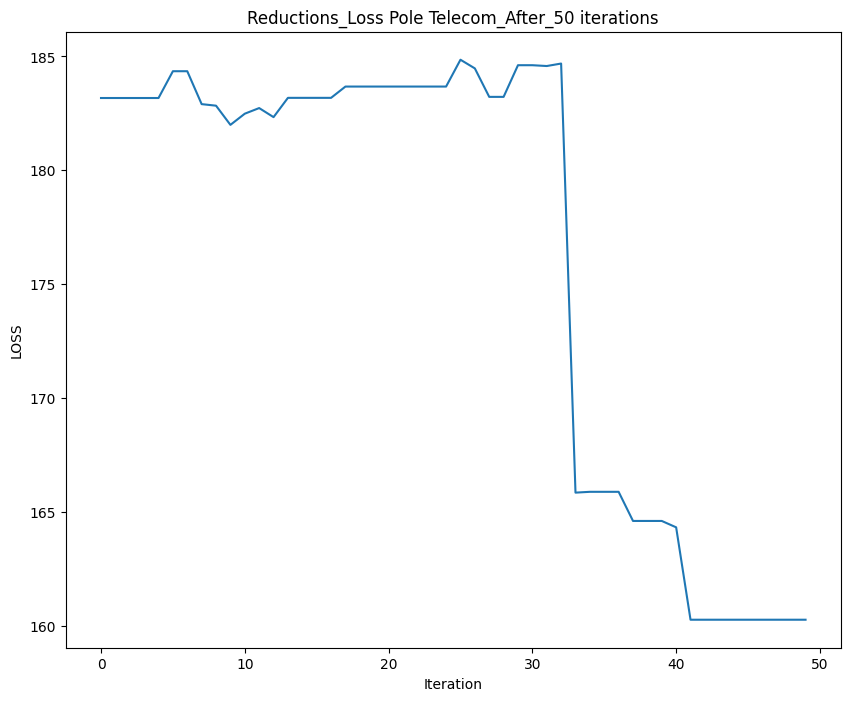

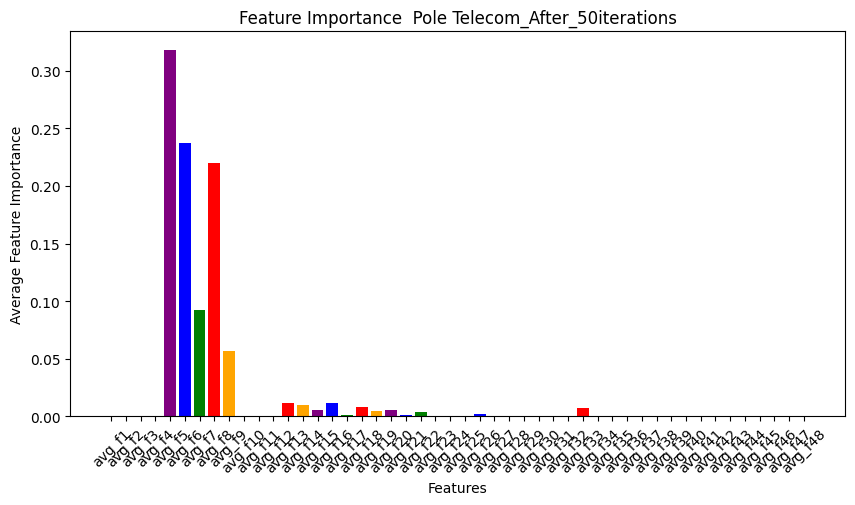

Data Name :puma8NH


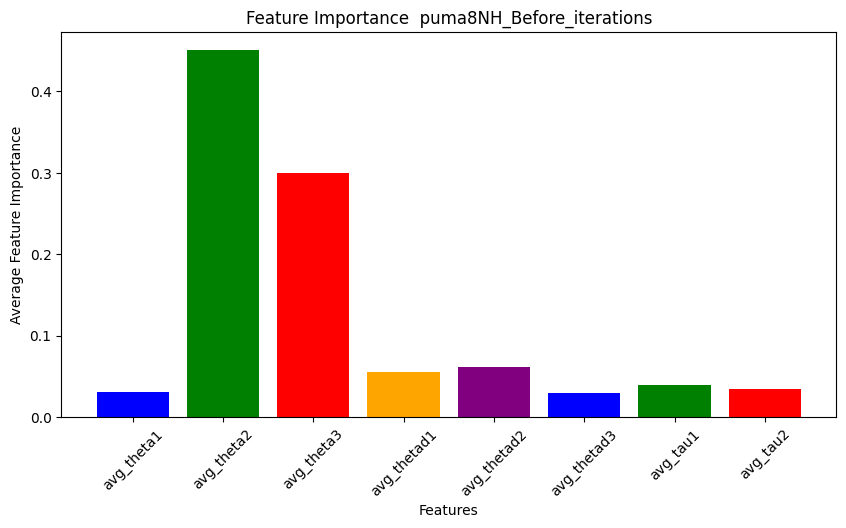

[19.473655761670607, 18.302047661375763, 18.300544005884294, 16.905831390781177, 16.832867204120767]


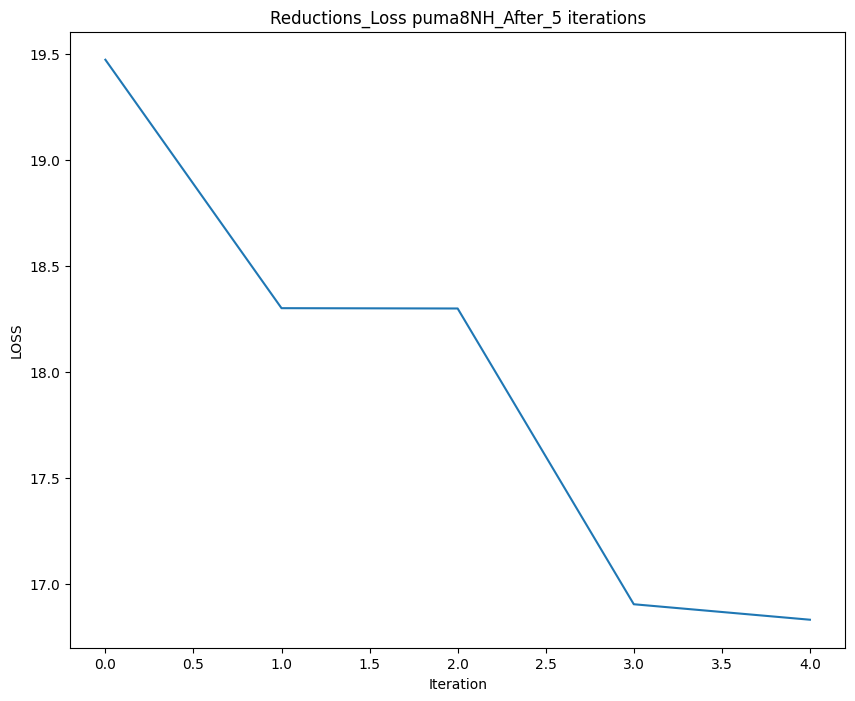

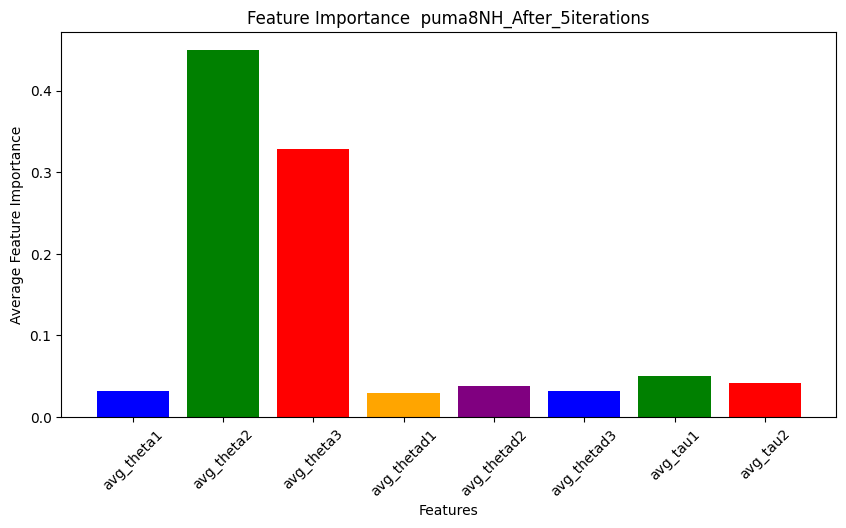

[15.518507379400157, 15.57974305927205, 15.594704598139643, 15.584682454516336, 15.52065325507607, 15.553264799432062, 15.544676963212062, 15.559769039314274, 14.618375526453278, 14.680872869842299]


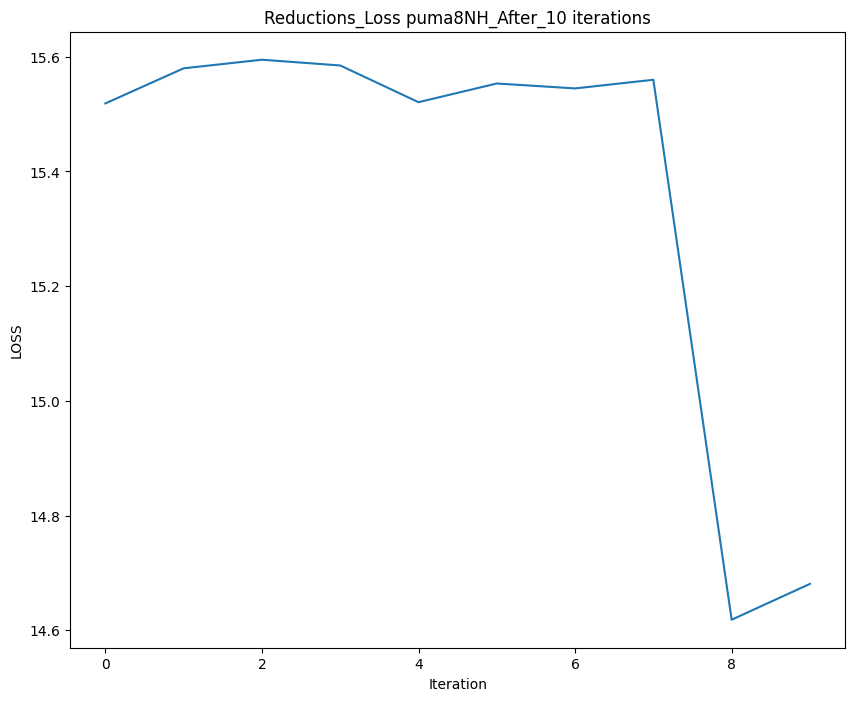

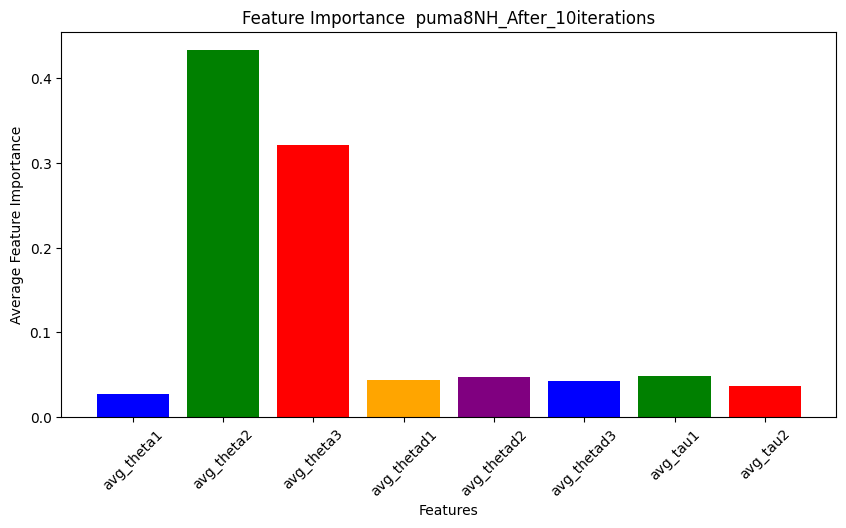

[14.664380910782238, 14.688853062798241, 14.764153837715586, 14.098479249984463, 14.038821292697511, 14.046415771094333, 13.994832046643937, 14.001360462088128, 13.96329193005628, 13.940083086323359, 13.379715017187914, 13.355616165320978, 13.312739863179244, 12.870600044465007, 12.69694817153428, 12.657493499475773, 12.74670082207698, 12.632324765927615, 12.477480638692622, 12.534173171052624]


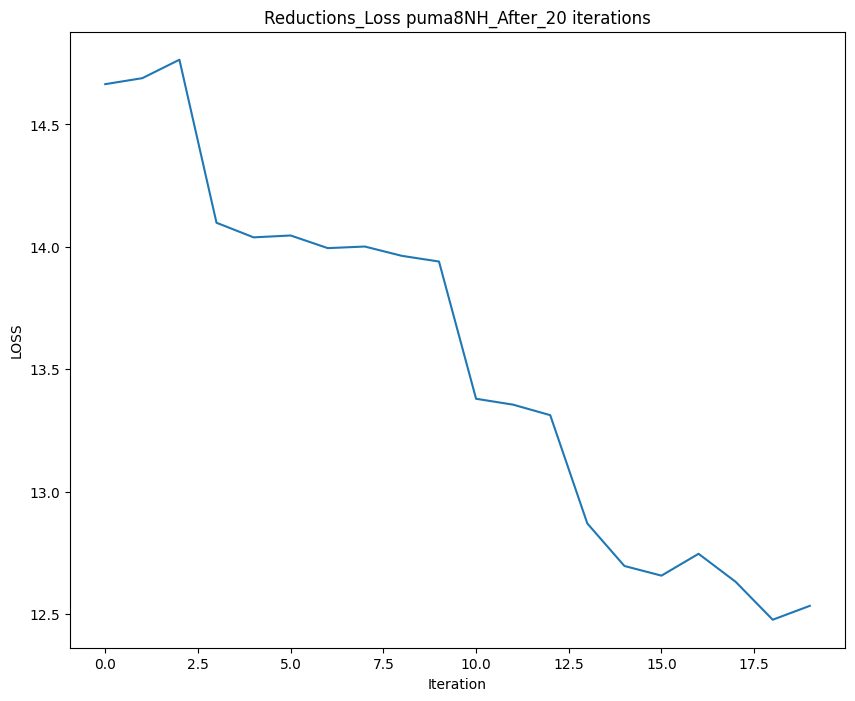

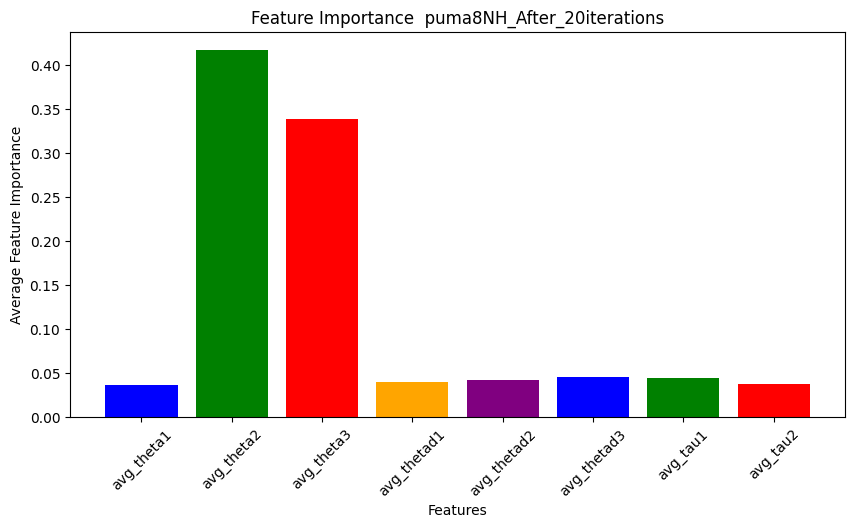

[12.58434268806167, 12.670022243333806, 12.61951203067323, 12.800184889440997, 12.750633899014046, 12.773366653857046, 12.7578514020096, 12.766120503925485, 12.74159115248295, 12.744984589820492, 12.755139392517998, 12.760607243160393, 12.716026131774386, 12.738522341001831, 12.738522341001831, 12.716026131774386, 12.80364130087595, 12.709928205388364, 12.524021970518314, 12.541423479377602, 12.527271857954155, 12.533740546875764, 12.536332819313463, 12.4619366371126, 12.510119324554285, 12.45225974317716, 12.47249004506671, 12.489832701332698, 12.478934566221243, 12.504294765868227, 12.575776143890916, 12.701273216396435, 12.812805992105353, 12.739131338374172, 12.80393861331725, 12.682637536377296, 12.74537194398996, 12.79071486919807, 12.788403006635171, 12.826952077686101, 12.813531131031407, 12.811271832275104, 12.8258825444797, 12.831334024749296, 12.87007507117884, 12.962494374863757, 12.942322915689019, 12.916873011071603, 12.906955570281506, 12.80311231862736]


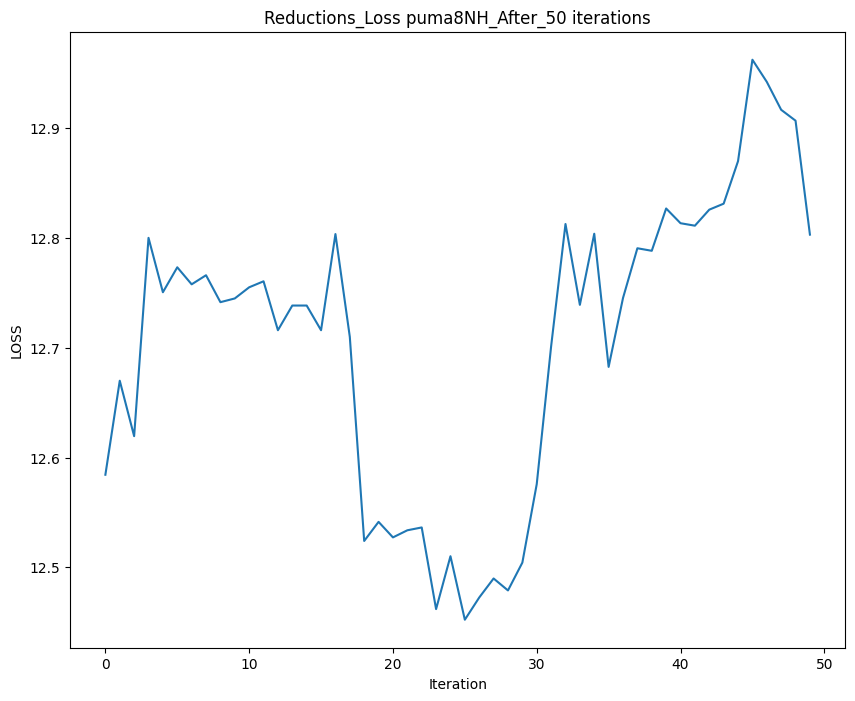

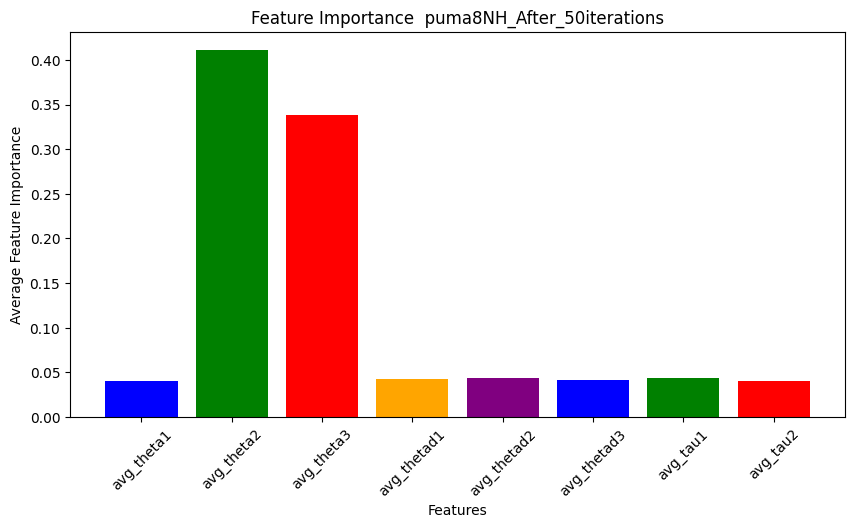

Data Name :puma8NH


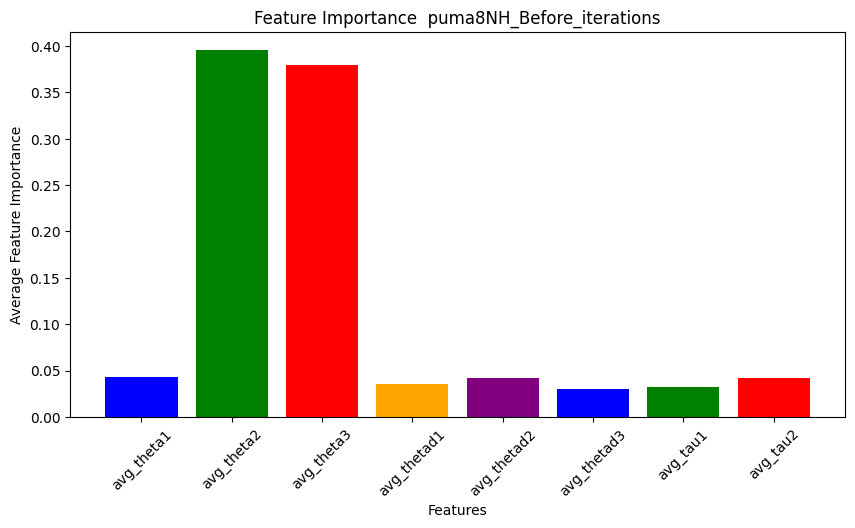

[20.866978700125635, 19.68776058953767, 19.643930564655843, 18.27062244942369, 17.306416804967192]


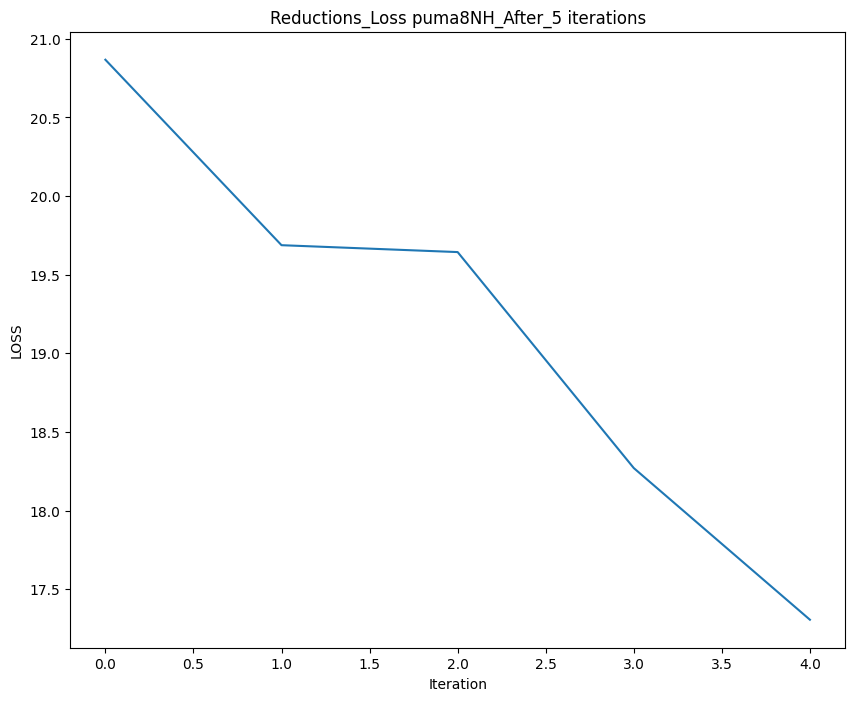

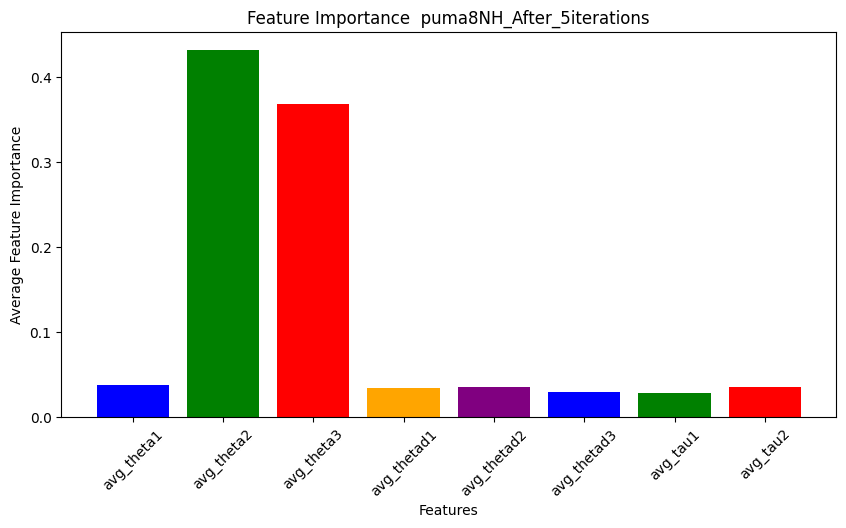

[16.280790404267574, 15.56759885961264, 15.010131987063462, 15.077306945567997, 15.014850361628875, 14.991101818018254, 14.53179492050415, 14.501353129060517, 14.447325249530367, 14.39488646815682]


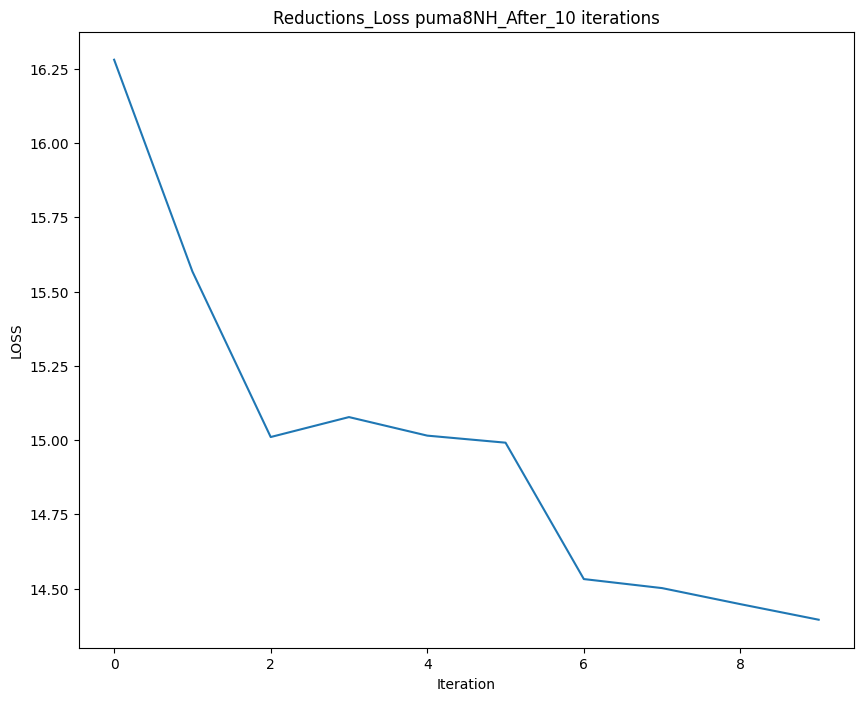

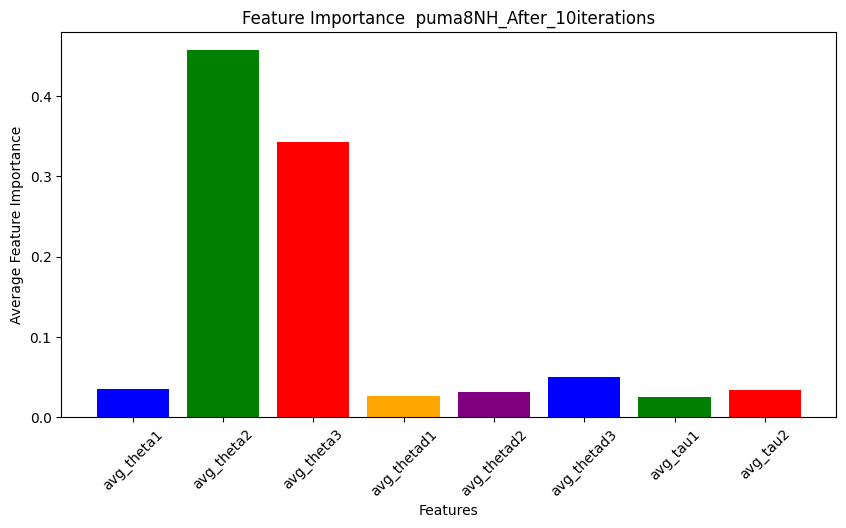

[14.473710793525488, 14.463432627464867, 14.519889389703705, 14.571879361475805, 14.491859035359028, 14.492081329285757, 14.479388035933951, 14.486455506175254, 14.441971119566041, 14.391183542482679, 14.450993906022026, 14.57580138728887, 14.51887022607735, 14.50267091931833, 14.548876045823617, 14.600711051023438, 14.596922728628671, 14.547194296711035, 14.473532787391695, 14.468268684583851]


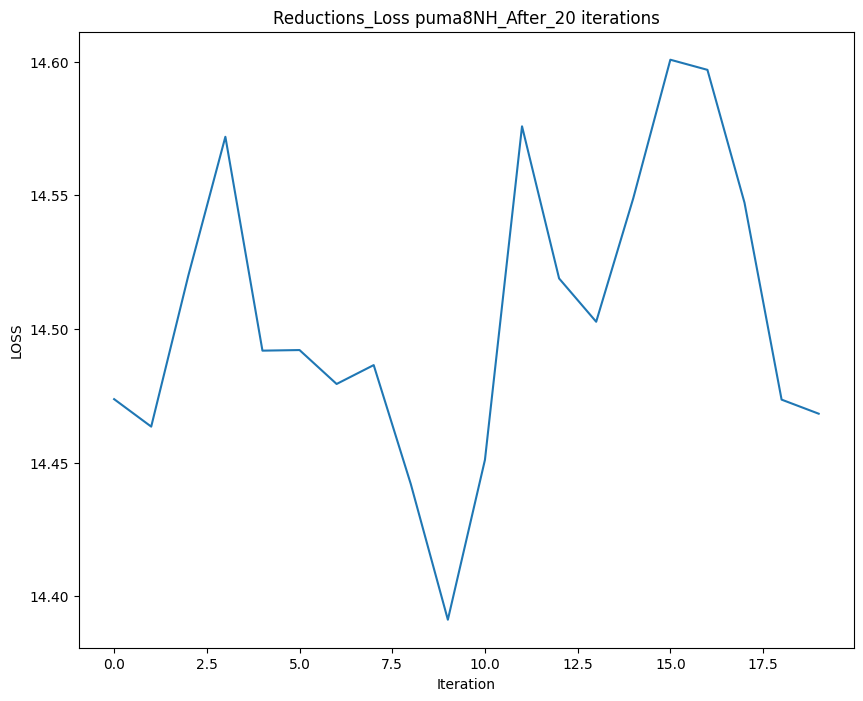

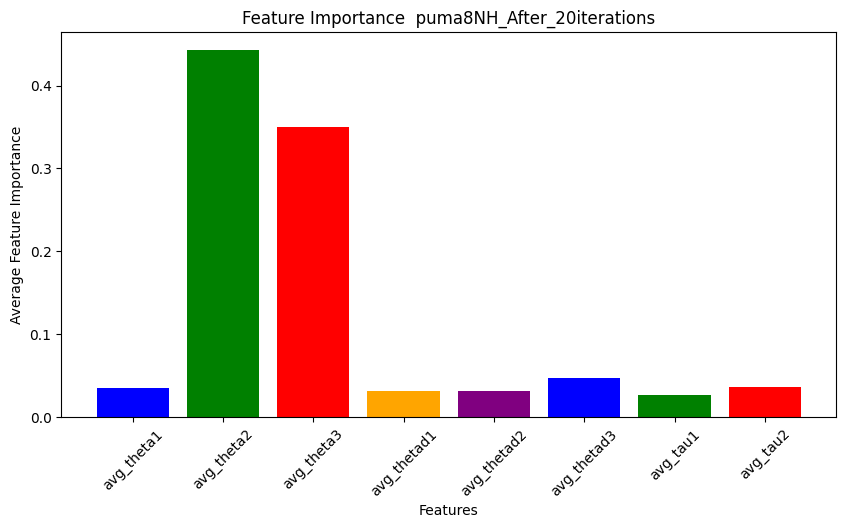

[14.406912400380621, 14.443733350810318, 14.429563931668191, 14.363049093253547, 14.336337727645299, 14.29695736514087, 14.297679426124564, 14.34715913109795, 14.290981094020818, 14.245165224290227, 14.294576298426394, 14.420105744729472, 14.441567306260373, 14.425549733634393, 14.465575075087985, 14.49535862099661, 14.473532787391695, 14.412838678804642, 14.414344721826929, 14.407355180726057, 14.35001750874407, 14.280515397086848, 14.269235154791023, 14.337370133232511, 14.368793710751714, 14.302927102839561, 14.286768616826448, 14.29894765613854, 14.278655592033257, 14.280259559320115, 14.204922086251795, 14.230300166961888, 14.212553934322662, 14.301357601606687, 14.40157211086901, 14.48520837033868, 14.488550428842371, 14.445085313457373, 14.494202705235505, 14.469497931750483, 14.434479902874676, 14.374219552113578, 14.421943010666617, 14.441652429242245, 14.372728620813719, 14.304582306629515, 14.159323398669413, 14.143871641093812, 14.16535093340207, 14.207455422151652]


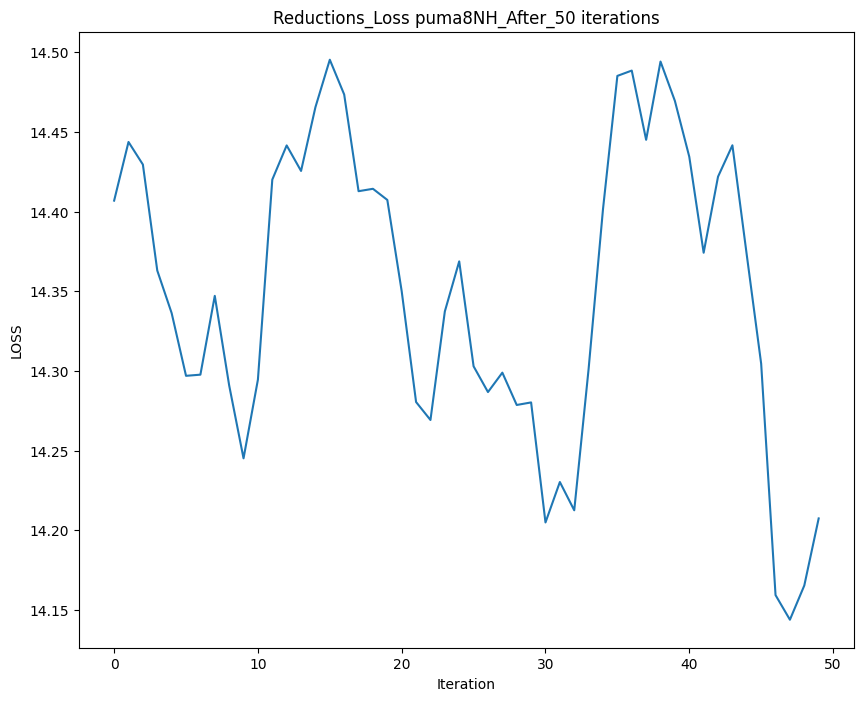

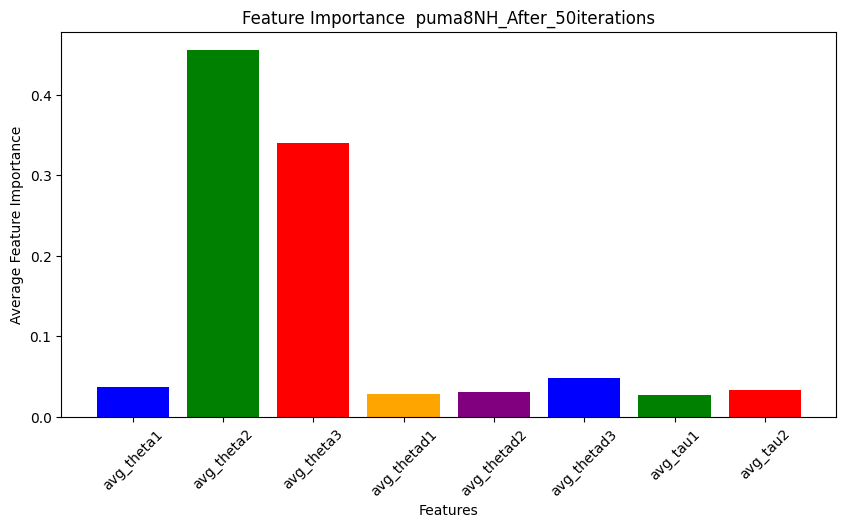

Data Name :Stock Prices


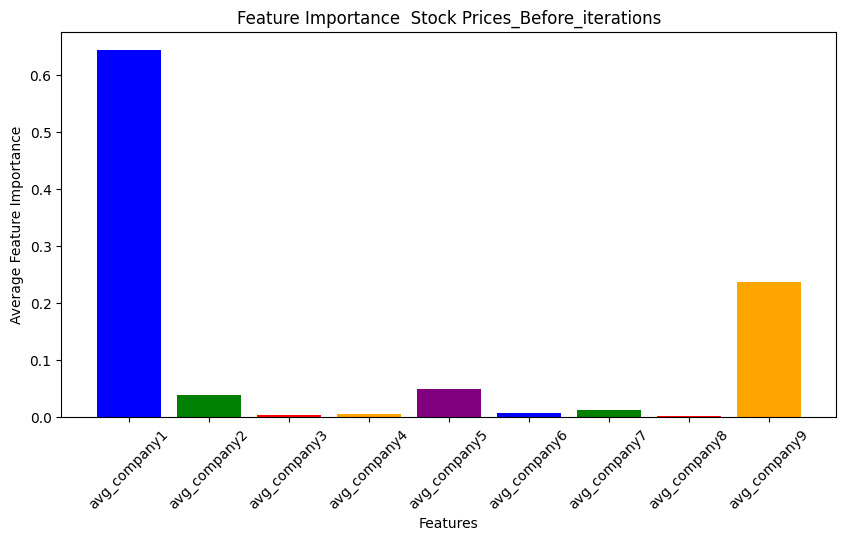

[2.737925164473684, 2.659280427631579, 2.6204070723684207, 2.631013157894737, 2.4235509868421063]


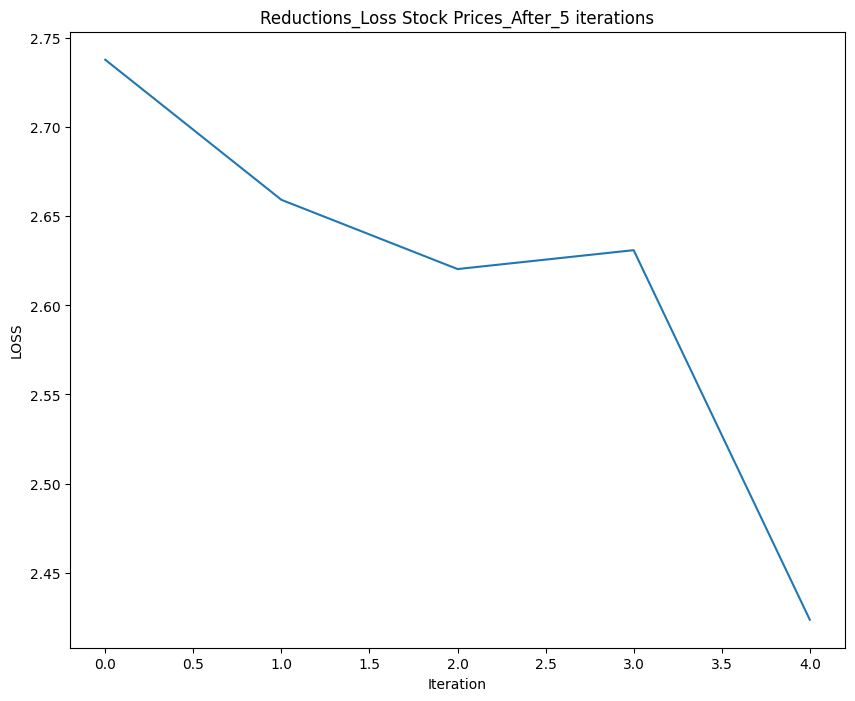

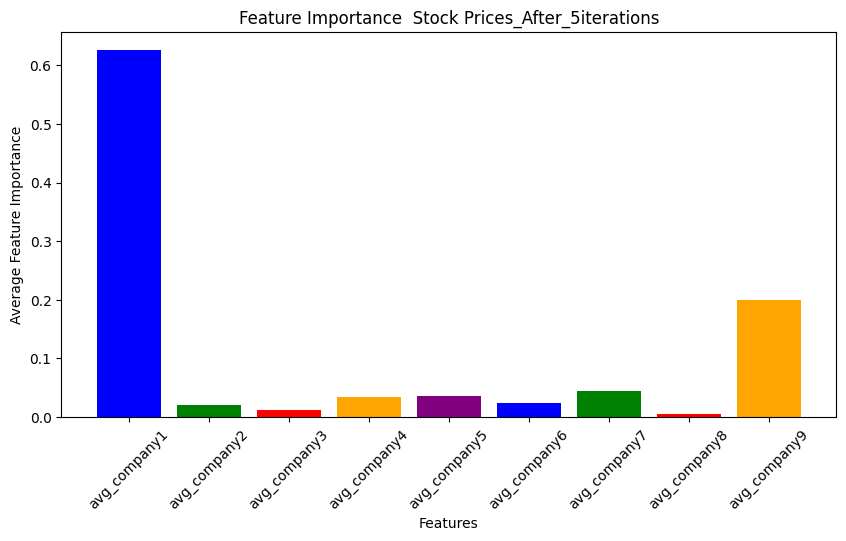

[2.37010115131579, 2.373473684210527, 2.3006044407894737, 2.303023026315789, 2.3006044407894737, 2.2758470394736845, 2.2810625, 2.2909934210526313, 2.3030518092105265, 2.318754111842106]


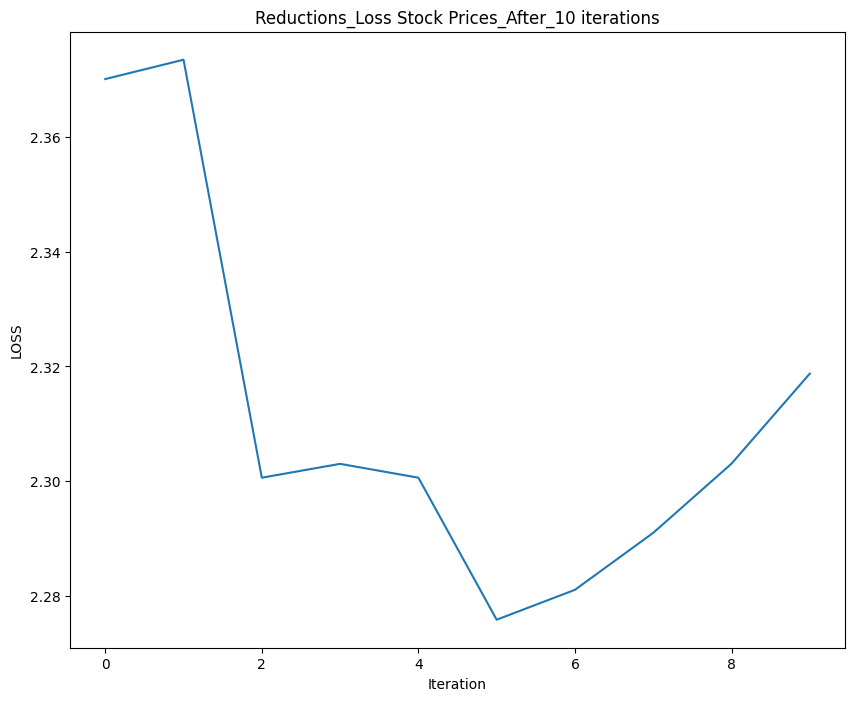

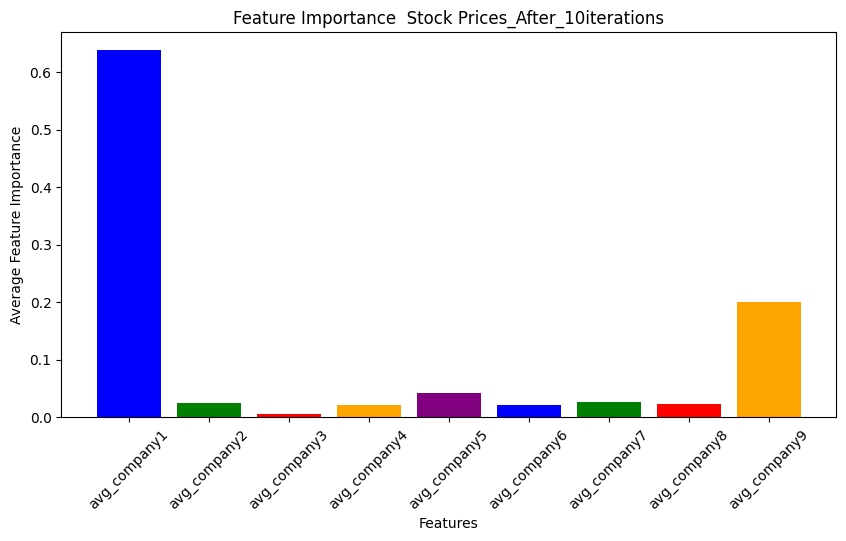

[2.3052993421052643, 2.3290041118421057, 2.3194161184210538, 2.318754111842106, 2.3074342105263157, 2.3016282894736846, 2.292836348684211, 2.297015625000001, 2.299986842105263, 2.299986842105263, 2.2809424342105267, 2.2678906249999997, 2.2691381578947367, 2.2883379934210524, 2.2921784539473684, 2.280186677631579, 2.266111019736842, 2.241689144736842, 2.2531472039473686, 2.2503445723684217]


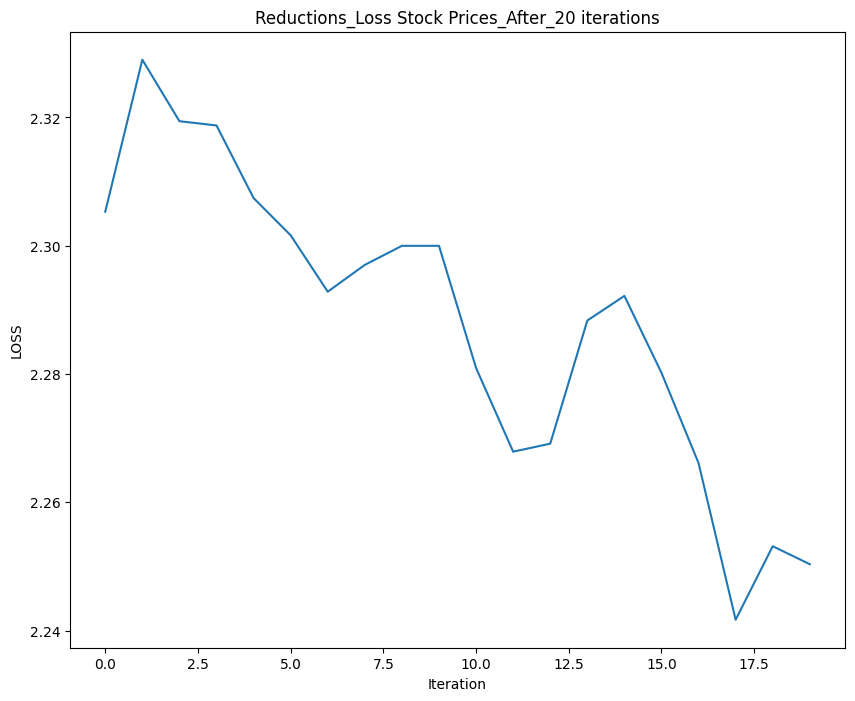

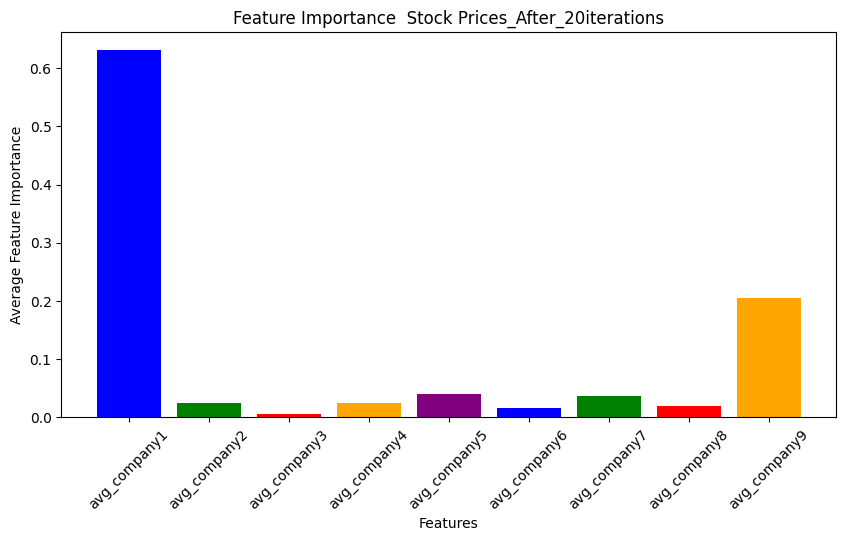

[2.2747648026315797, 2.274370065789474, 2.2709103618421054, 2.267700657894737, 2.258282072368421, 2.2742277960526316, 2.2639416118421054, 2.268948190789474, 2.2677746710526323, 2.3912705592105263, 2.3746422697368414, 2.3600411184210524, 2.3606299342105257, 2.3849827302631574, 2.388364309210526, 2.377040296052631, 2.3628338815789465, 2.444175164473685, 2.4549210526315792, 2.4704202302631577, 2.3627870065789476, 2.4017055921052637, 2.413270559210527, 2.4154383223684217, 2.3804893092105264, 2.3659177631578943, 2.3493725328947366, 2.3684004934210527, 2.2793445723684207, 2.2816077302631577, 2.3325222039473683, 2.321972039473684, 2.3153100328947365, 2.32346134868421, 2.3221422697368417, 2.325239309210526, 2.318879111842105, 2.308736019736842, 2.2971217105263166, 2.2944333881578958, 2.3045148026315796, 2.2887845394736845, 2.3023273026315794, 2.292642269736842, 2.2988807565789475, 2.2733240131578945, 2.2934819078947366, 2.2723231907894736, 2.2644769736842107, 2.260463815789474]


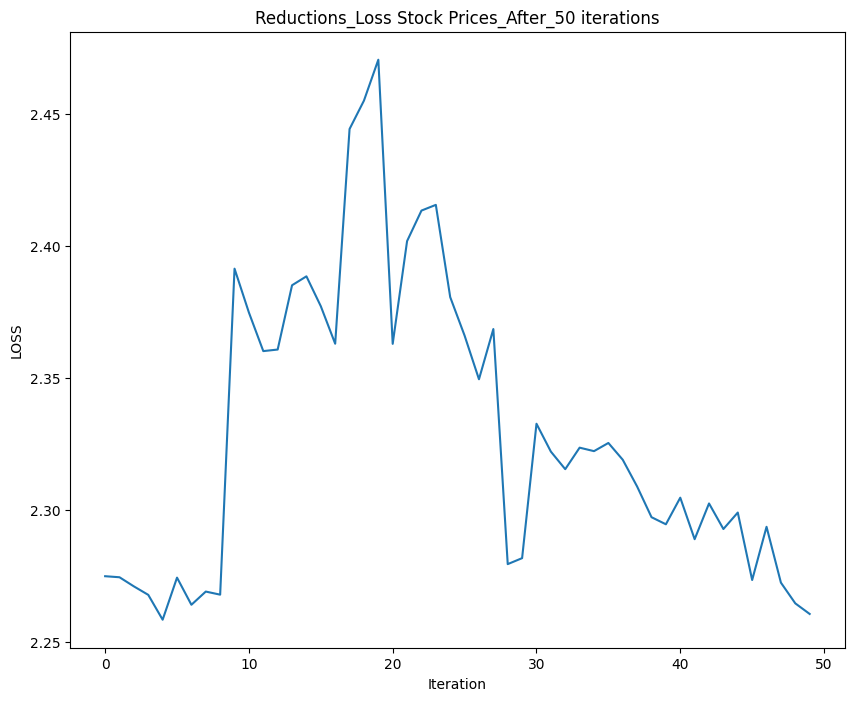

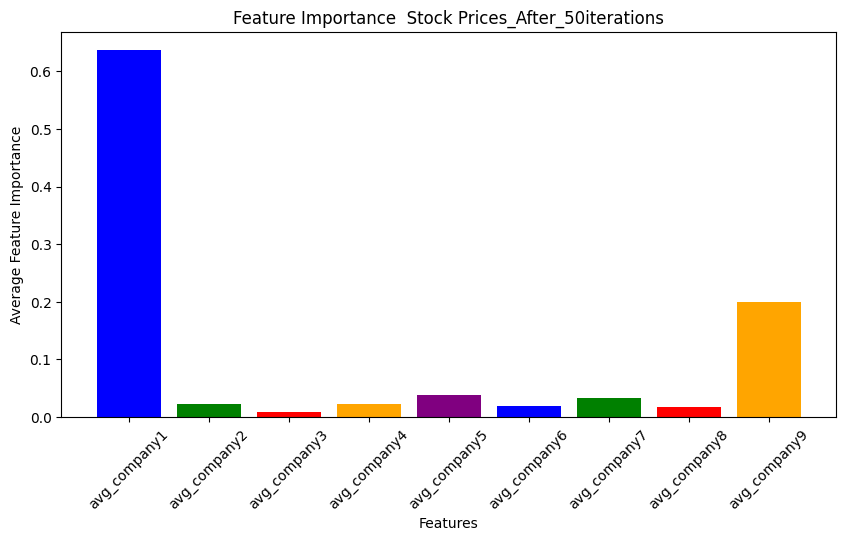

Data Name :triazines


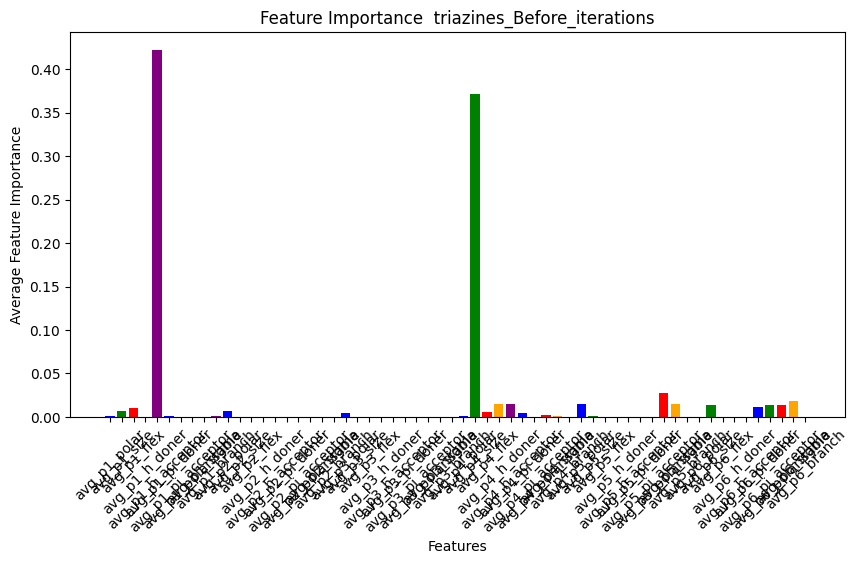

[0.025360550270270277, 0.02248796270270271, 0.021307722162162167, 0.022187431351351358, 0.02124409864864865]


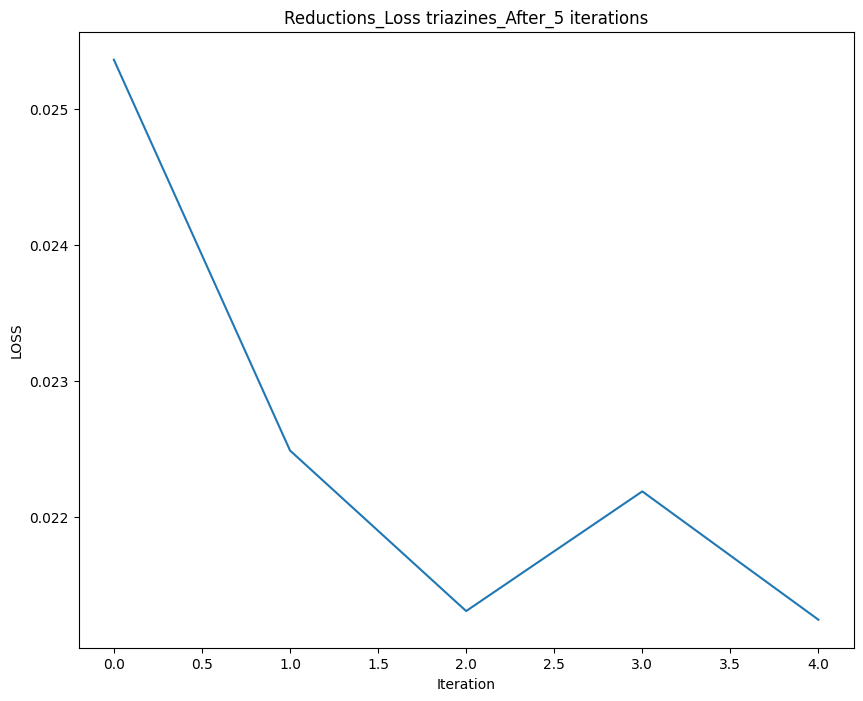

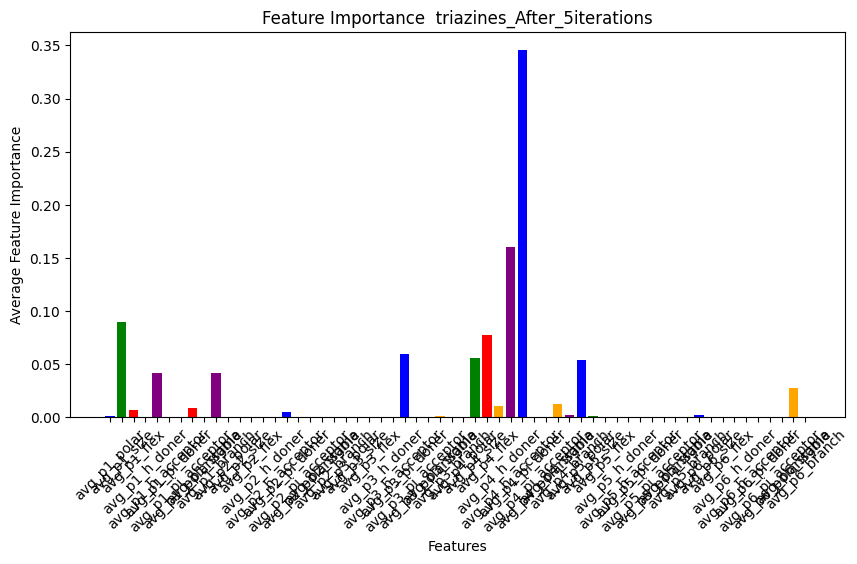

[0.02164542567567568, 0.02064134351351352, 0.02036469540540541, 0.02124409864864865, 0.02124409864864865, 0.018960030000000006, 0.01856074, 0.01776734621621622, 0.018076827567567566, 0.018837937567567565]


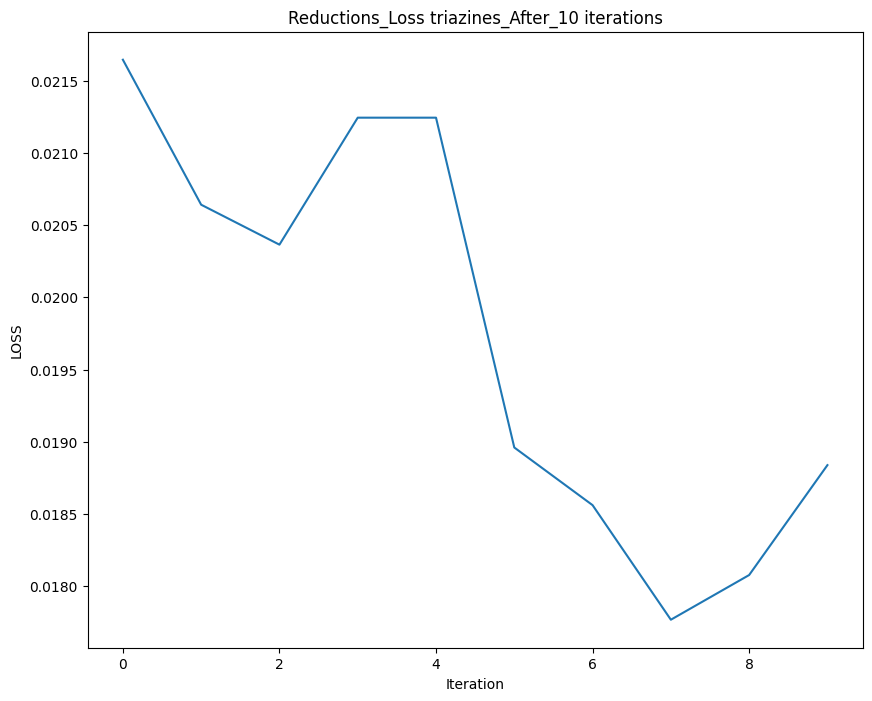

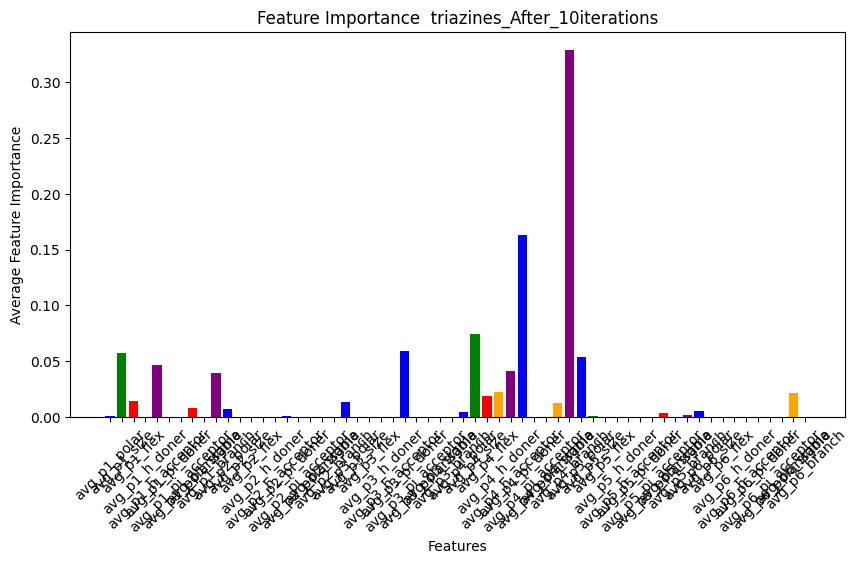

[0.017952698648648645, 0.0171604472972973, 0.01772767324324325, 0.018806568918918926, 0.018331500000000004, 0.019162154594594596, 0.01924549189189189, 0.01861423405405406, 0.018594514054054056, 0.019358529459459456, 0.01971776081081081, 0.019051345405405404, 0.018646105945945946, 0.01845571675675676, 0.019999672432432437, 0.0204644072972973, 0.020092720270270273, 0.01829487054054054, 0.01770449864864865, 0.017772919459459458]


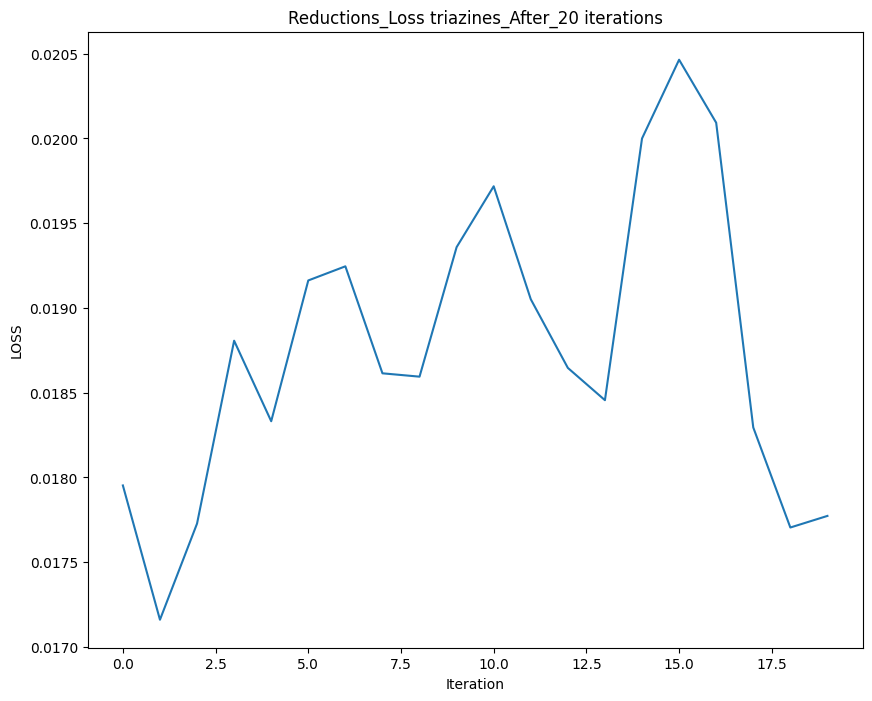

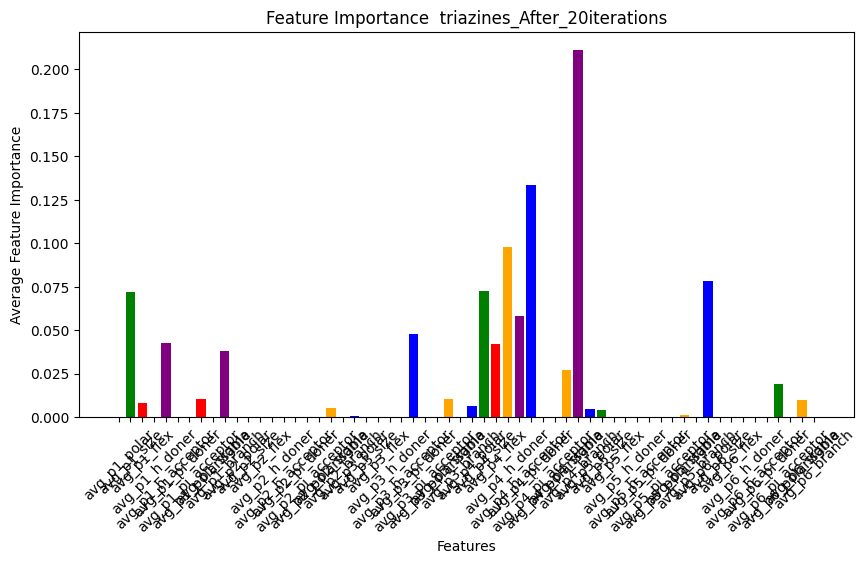

[0.018030487027027028, 0.017730995405405403, 0.017508445135135133, 0.018613995945945948, 0.018153057837837838, 0.01905159972972973, 0.019020899459459457, 0.018388401081081085, 0.018722461891891893, 0.019533876216216217, 0.019907867567567565, 0.019194053243243248, 0.018773207297297298, 0.01845571675675676, 0.019999672432432437, 0.0204644072972973, 0.020092720270270273, 0.01829487054054054, 0.01770449864864865, 0.017772919459459458, 0.017827380270270272, 0.01785901135135135, 0.018171236486486487, 0.018356661621621622, 0.017822243243243246, 0.018085148378378383, 0.01728654486486486, 0.017187146756756755, 0.017789437837837842, 0.018519081621621625, 0.01863606648648649, 0.018824739459459467, 0.01862777243243244, 0.018873312162162165, 0.019494331081081083, 0.019741138108108115, 0.019920571891891888, 0.019743836486486487, 0.01966113783783784, 0.019895722162162163, 0.01975905513513514, 0.018544810000000005, 0.018087350000000006, 0.017874578648648654, 0.018044611081081085, 0.018040876216216223,

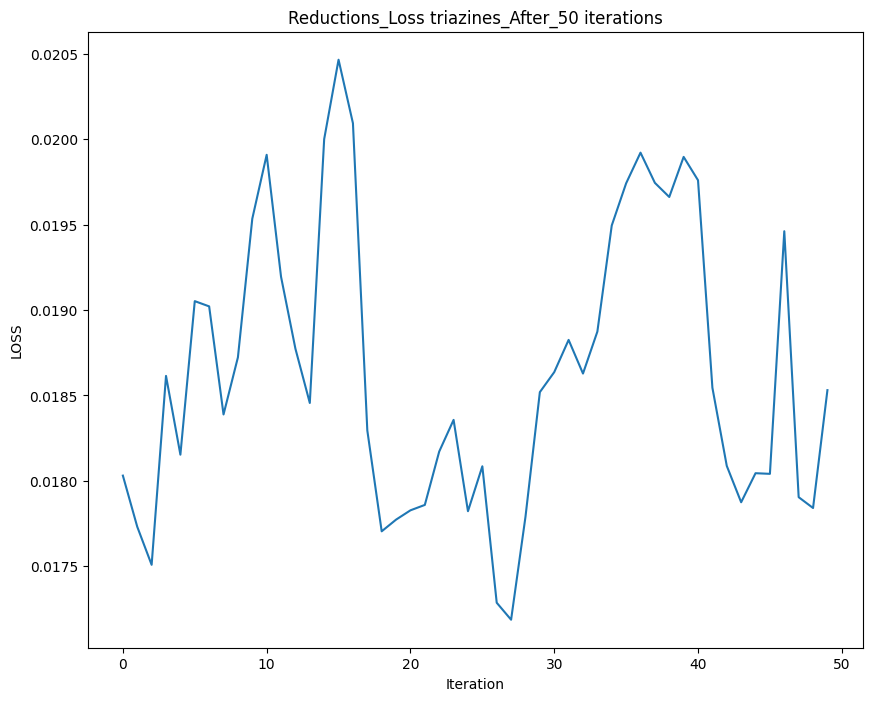

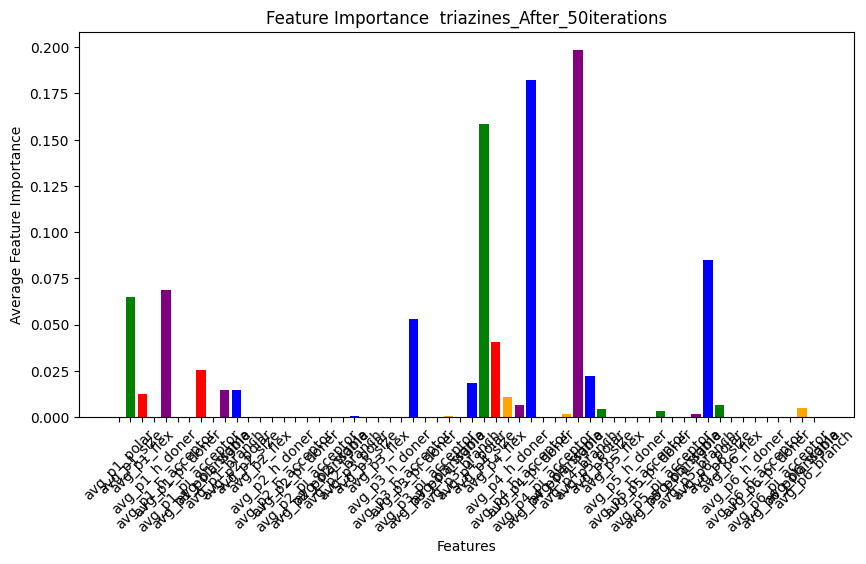

Data Name : Red wine quality


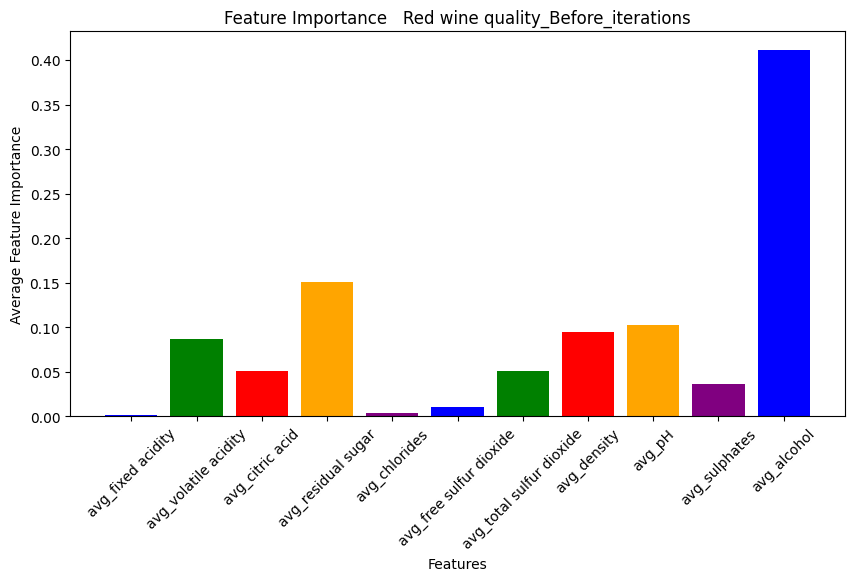

[0.76246875, 0.7687812500000001, 0.7133437499999999, 0.73140625, 0.67984375]


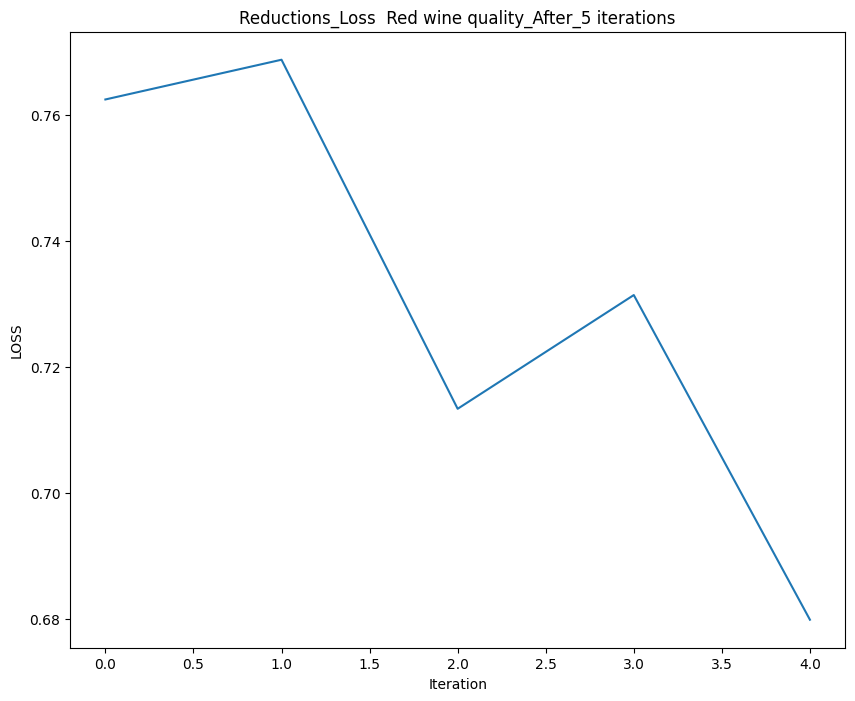

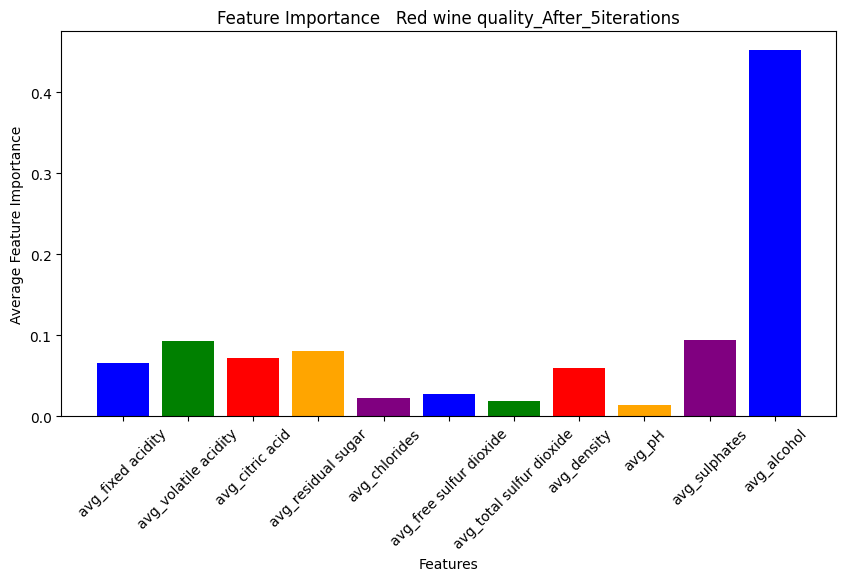

[0.67246875, 0.67984375, 0.6624062499999999, 0.67984375, 0.6623124999999999, 0.6628437500000001, 0.627875, 0.6254687499999999, 0.62728125, 0.626875]


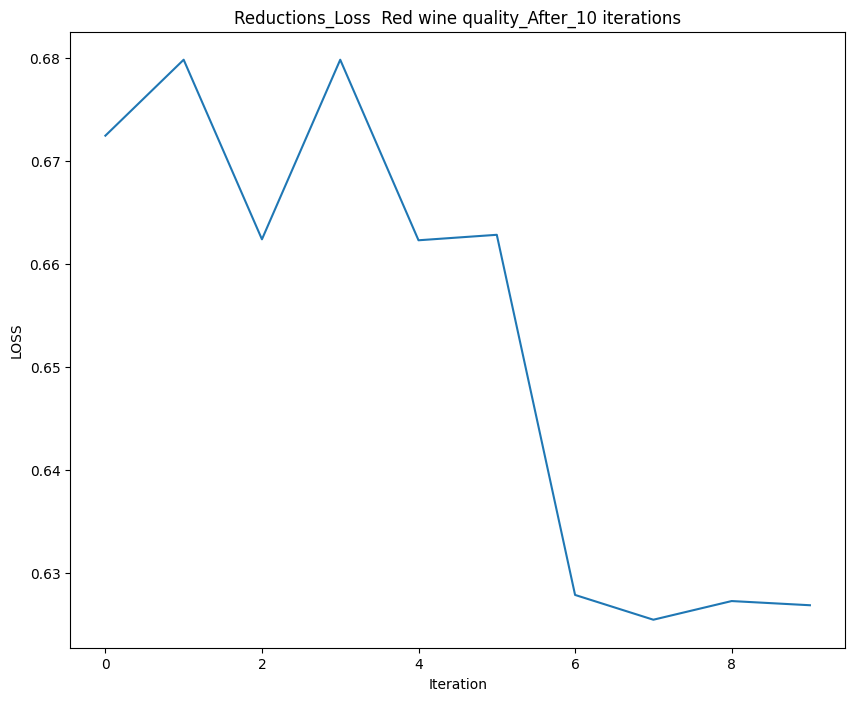

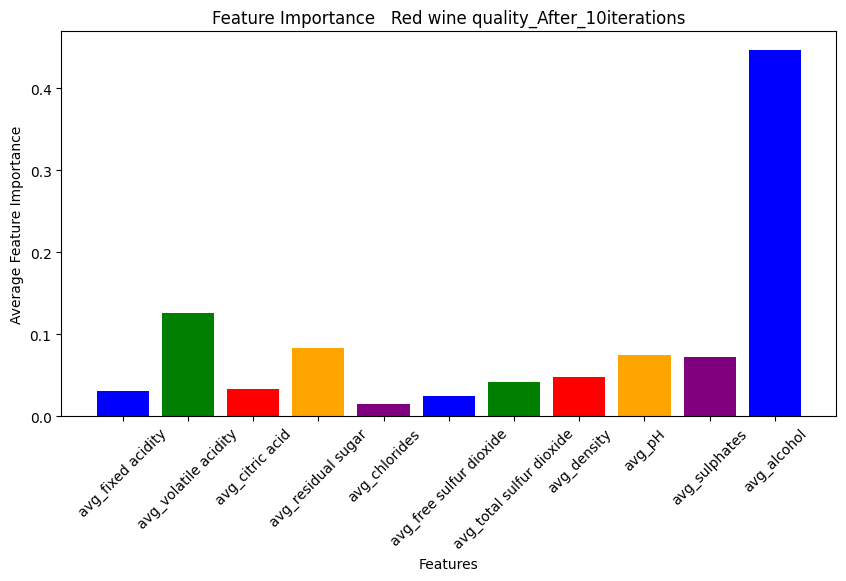

[0.61834375, 0.6258437499999999, 0.58721875, 0.60215625, 0.588375, 0.5881875, 0.5881875, 0.5859687499999999, 0.58653125, 0.5854062499999999, 0.56365625, 0.5672499999999999, 0.56784375, 0.5653437499999999, 0.5656249999999999, 0.5658124999999999, 0.5660624999999999, 0.5665625000000001, 0.55978125, 0.55796875]


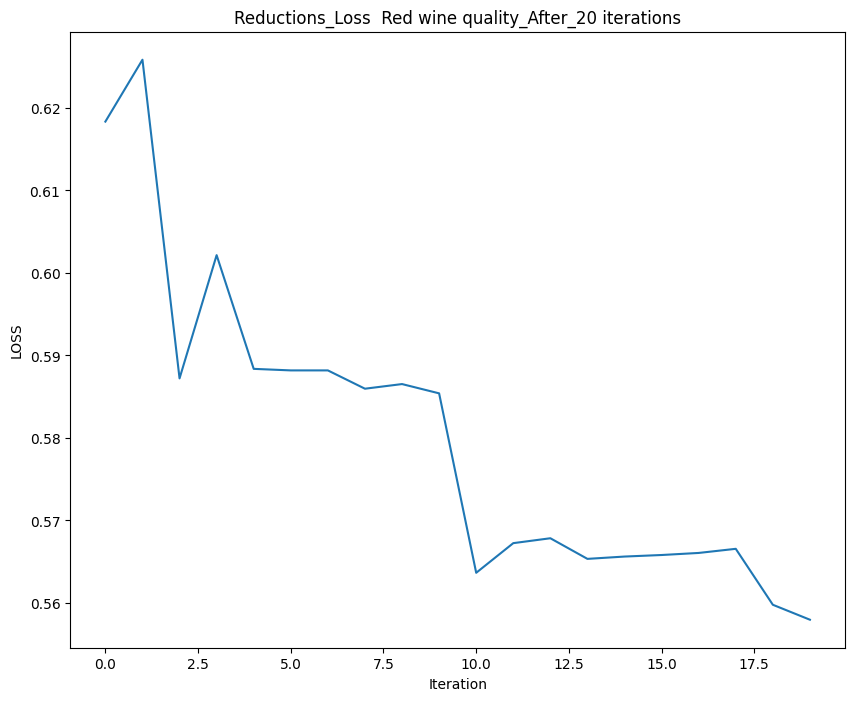

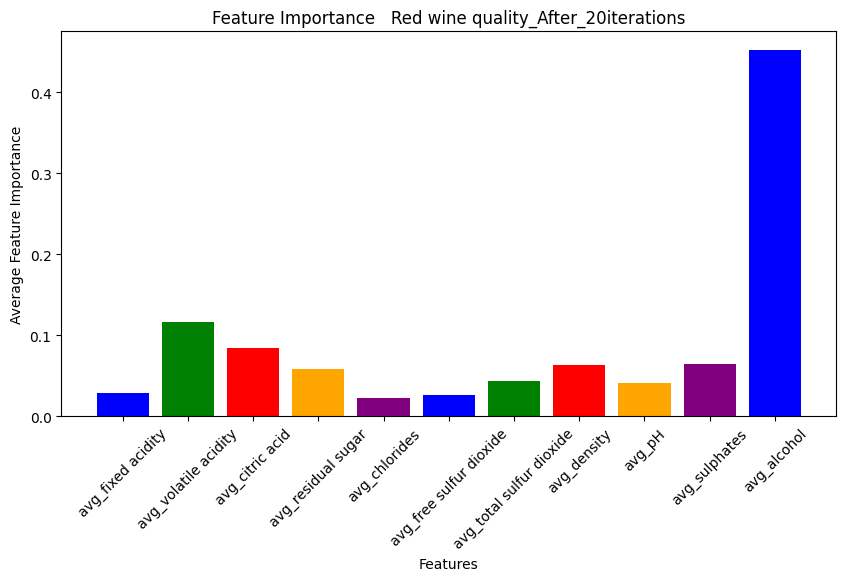

[0.55046875, 0.55746875, 0.5621875000000001, 0.57725, 0.57646875, 0.563125, 0.56509375, 0.5633125, 0.562875, 0.5633437499999999, 0.5583750000000001, 0.56034375, 0.5609999999999999, 0.5639062499999999, 0.5641874999999998, 0.563875, 0.564125, 0.564625, 0.55796875, 0.55734375, 0.56359375, 0.54334375, 0.54246875, 0.5539999999999999, 0.5426875, 0.5418749999999999, 0.5418749999999999, 0.5312187500000001, 0.5312187500000001, 0.53315625, 0.5319375, 0.54525, 0.54434375, 0.5330625, 0.53125, 0.532875, 0.52809375, 0.5233437500000001, 0.52496875, 0.52496875, 0.52328125, 0.52328125, 0.5248125, 0.5248125, 0.5266875000000001, 0.5281874999999999, 0.53321875, 0.5343125000000001, 0.5301875, 0.5301875]


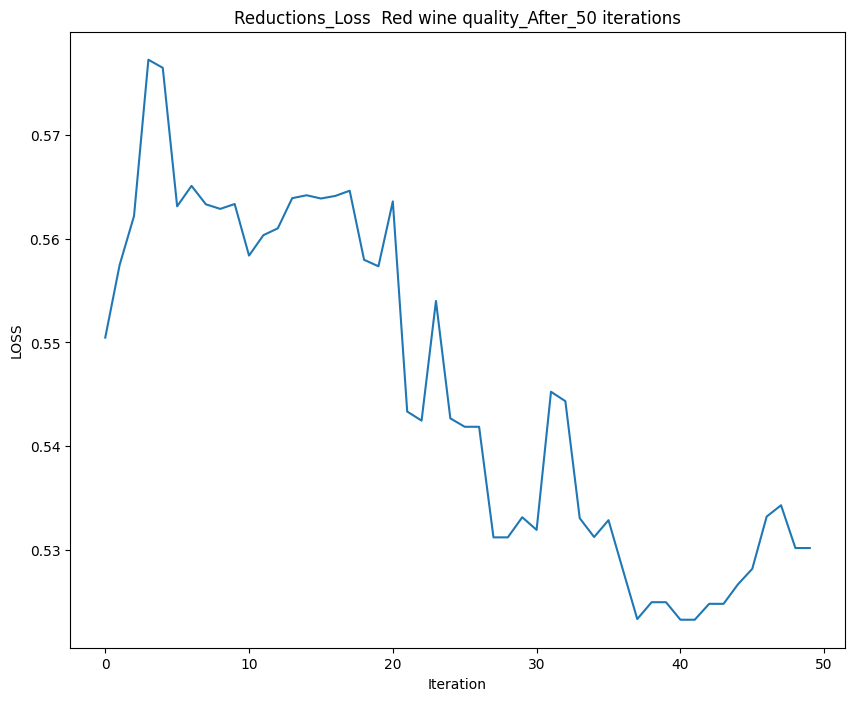

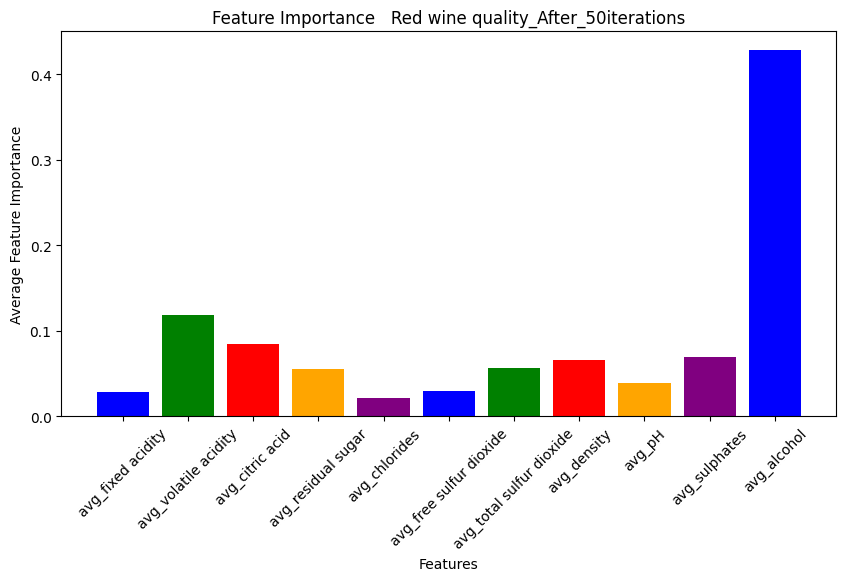

In [ ]:

if __name__ == "__main__":
  setup(DIR)
  # load the datasets data
  datasets  = load_datasets_data(Datasets_path)
  for v in datasets:
    dataset_name= datasets[v]['name']
    print("Data Name :" +dataset_name)
    file_path = datasets[v]['path']
    Target = datasets[v]['Target']
    plot_filename = os.path.join(DIR,dataset_name)
    setup(plot_filename)
    metal_model(dataset_name,file_path,Target,plot_filename,list_iter)
